# Sentiment Analysis on Social media data

This notebook provides a comprehensive, production-quality sentiment analysis pipeline on the Tweets.csv dataset using modern transformer models and traditional ML approaches.

## Project Overview
- **Dataset**: Tweets.csv (from Kaggle)
- **Task**: 3-class sentiment classification (Negative/Neutral/Positive)
- **Models**: TF-IDF + Logistic Regression, LSTM (Bidirectional), Multinomial Naive Bayes, GloVe + LSTM
- **Evaluation**: Accuracy, Precision, Recall, F1-score (macro/weighted), Confusion Matrices
- **Visualizations**: EDA plots, model comparisons, training curves


# 1. Installation and Setup

In [1]:
# Install required packages (works in Colab and local Jupyter)
import subprocess
import sys

packages = [
    'contractions', 'emoji', 'transformers', 'datasets', 'evaluate', 
    'requests', 'tqdm', 'wordcloud', 'seaborn', 'plotly', 'nltk',
    'scikit-learn', 'tensorflow', 'pandas', 'numpy', 'matplotlib'
]
for pkg in packages:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', pkg])
    
print("✓ All packages installed successfully!")

✓ All packages installed successfully!


In [ ]:
import os
import re
import json
import warnings
from pathlib import Path
from collections import Counter
from typing import Dict, List, Tuple
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import contractions
import emoji

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report
)
from sklearn.preprocessing import LabelEncoder
import joblib

# TensorFlow/Keras for LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create results directory
os.makedirs('../results', exist_ok=True)
os.makedirs('../results/models', exist_ok=True)
os.makedirs('../results/figures', exist_ok=True)

# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("✓ All imports successful!")
print(f"TensorFlow version: {tf.__version__}")
print("✓ Using traditional ML and deep learning models (LSTM)")


✓ All imports successful!
TensorFlow version: 2.20.0
✓ Using traditional ML and deep learning models (LSTM)


# 2. Load Tweets.csv Dataset


In [ ]:
import pandas as pd

# Define the path to the CSV file (local file in the same directory)
file_path = 'Tweets.csv'

# Read the CSV file into a DataFrame
try:
    df = pd.read_csv(file_path, encoding='ISO-8859-1', header=None)
    print("\n✓ Dataset loaded successfully from local file!")
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found. Please ensure it exists in the current directory.")
except Exception as e:
    print(f"An error occurred while reading the file: {e}")

# Download the missing NLTK resource 'punkt_tab' to resolve the error in the EDA section
import nltk
nltk.download('punkt_tab', quiet=True)



✓ Dataset loaded successfully from local file!


True

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
1,570306133677760513,neutral,1.0,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
2,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
3,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
4,570301031407624196,negative,1.0,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)


In [5]:
headers = df.iloc[0]
df  = pd.DataFrame(df.values[1:], columns=headers)
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0,Can't Tell,1.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [6]:
# Use the actual column names from the dataset
# Dataset columns: tweet_id, airline_sentiment, airline_sentiment_confidence, negativereason,
# negativereason_confidence, airline, airline_sentiment_gold, name, negativereason_gold,
# retweet_count, text, tweet_coord, tweet_created, tweet_location, user_timezone

# The text column is 'text' and sentiment column is 'airline_sentiment'
print("Using dataset columns:")
print(f"  Text column: 'text'")
print(f"  Sentiment column: 'airline_sentiment'")

# Verify columns exist
if 'text' not in df.columns:
    raise ValueError("Column 'text' not found in dataset!")
if 'airline_sentiment' not in df.columns:
    raise ValueError("Column 'airline_sentiment' not found in dataset!")

# Rename for consistency (keep 'text' as is, rename 'airline_sentiment' to 'sentiment')
df = df.rename(columns={'airline_sentiment': 'sentiment'})

print(f"\n✓ Columns ready!")
print(f"Dataset shape: {df.shape}")
print(f"\nDataset info:")
print(df.info())
print(f"\nSentiment distribution (airline_sentiment):")
print(df['sentiment'].value_counts())
print(f"\nSample data:")
df[['text', 'sentiment', 'airline', 'negativereason']].head(10)


Using dataset columns:
  Text column: 'text'
  Sentiment column: 'airline_sentiment'

✓ Columns ready!
Dataset shape: (14640, 15)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   tweet_id                      14640 non-null  object
 1   sentiment                     14640 non-null  object
 2   airline_sentiment_confidence  14640 non-null  object
 3   negativereason                9178 non-null   object
 4   negativereason_confidence     10522 non-null  object
 5   airline                       14640 non-null  object
 6   airline_sentiment_gold        40 non-null     object
 7   name                          14640 non-null  object
 8   negativereason_gold           32 non-null     object
 9   retweet_count                 14640 non-null  object
 10  text                          14640 non-null 

,text,sentiment,airline,negativereason
0,@VirginAmerica What @dhepburn said.,neutral,Virgin America,NaN
1,@VirginAmerica plus you've added commercials t...,positive,Virgin America,NaN
2,@VirginAmerica I didn't today... Must mean I n...,neutral,Virgin America,NaN
3,@VirginAmerica it's really aggressive to blast...,negative,Virgin America,Bad Flight
4,@VirginAmerica and it's a really big bad thing...,negative,Virgin America,Can't Tell
5,@VirginAmerica seriously would pay $30 a fligh...,negative,Virgin America,Can't Tell
6,"@VirginAmerica yes, nearly every time I fly VX...",positive,Virgin America,NaN
7,@VirginAmerica Really missed a prime opportuni...,neutral,Virgin America,NaN
8,"@virginamerica Well, I didn'tâ¦but NOW I DO! :-D",positive,Virgin America,NaN
9,"@VirginAmerica it was amazing, and arrived an ...",positive,Virgin America,NaN


# 3. Data Preprocessing


In [7]:
def preprocess_tweet(tweet: str, remove_stopwords: bool = False) -> str:
    """
    Comprehensive preprocessing for Twitter data.

    Args:
        tweet: Raw tweet text
        remove_stopwords: Whether to remove stopwords

    Returns:
        Preprocessed tweet
    """
    if pd.isna(tweet) or tweet == '':
        return ''

    # Convert to string
    tweet = str(tweet)

    # Expand contractions (e.g., "don't" -> "do not")
    tweet = contractions.fix(tweet)

    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)

    # Remove user mentions
    tweet = re.sub(r'@\w+', '', tweet)

    # Remove hashtag symbols but keep the text (optional: remove entirely)
    tweet = re.sub(r'#', '', tweet)

    # Convert emojis to text descriptions
    tweet = emoji.demojize(tweet, delimiters=(" ", " "))

    # Remove special characters and numbers (keep only letters and spaces)
    tweet = re.sub(r'[^a-zA-Z\s]', '', tweet)

    # Convert to lowercase
    tweet = tweet.lower()

    # Remove extra whitespace
    tweet = re.sub(r'\s+', ' ', tweet).strip()

    # Remove stopwords if requested
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        tokens = word_tokenize(tweet)
        tweet = ' '.join([word for word in tokens if word not in stop_words])

    return tweet

print("✓ Preprocessing function defined!")


✓ Preprocessing function defined!


In [8]:
# Show before/after examples
print("Preprocessing Examples:")
print("="*80)

sample_tweets = df['text'].head(5).tolist()

for i, original in enumerate(sample_tweets, 1):
    processed = preprocess_tweet(original)
    print(f"\nExample {i}:")
    print(f"Original:  {original}")
    print(f"Processed: {processed}")
    print("-"*80)


Preprocessing Examples:

Example 1:
Original:  @VirginAmerica What @dhepburn said.
Processed: what said
--------------------------------------------------------------------------------

Example 2:
Original:  @VirginAmerica plus you've added commercials to the experience... tacky.
Processed: plus you have added commercials to the experience tacky
--------------------------------------------------------------------------------

Example 3:
Original:  @VirginAmerica I didn't today... Must mean I need to take another trip!
Processed: i did not today must mean i need to take another trip
--------------------------------------------------------------------------------

Example 4:
Original:  @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
Processed: it is really aggressive to blast obnoxious entertainment in your guests faces amp they have little recourse
-------------------------------------------------------------

In [9]:
# Apply preprocessing to entire dataset
print("Preprocessing all tweets...")
df['text_processed'] = df['text'].apply(preprocess_tweet)

# Remove empty tweets after preprocessing
initial_count = len(df)
df = df[df['text_processed'].str.len() > 0].copy()
final_count = len(df)

print(f"✓ Preprocessing complete!")
print(f"  Removed {initial_count - final_count} empty tweets")
print(f"  Final dataset size: {final_count:,} tweets")


Preprocessing all tweets...


✓ Preprocessing complete!
  Removed 0 empty tweets
  Final dataset size: 14,640 tweets


In [10]:
# Normalize sentiment labels from airline_sentiment column
# The airline_sentiment column typically contains: 'positive', 'negative', 'neutral'
print("Original sentiment values from 'airline_sentiment' column:")
print(df['sentiment'].value_counts())

# Convert sentiment to standardized format
def normalize_sentiment(sent):
    """Normalize sentiment labels to negative, neutral, positive"""
    if pd.isna(sent):
        return 'unknown'

    sent_str = str(sent).lower().strip()

    # Handle the airline_sentiment values (typically: 'positive', 'negative', 'neutral')
    if sent_str in ['negative', 'neg', '0', '0.0']:
        return 'negative'
    elif sent_str in ['neutral', 'neu', '1', '1.0', '2', '2.0']:
        return 'neutral'
    elif sent_str in ['positive', 'pos', '3', '3.0', '4', '4.0']:
        return 'positive'

    # Additional checks for variations
    if 'neg' in sent_str:
        return 'negative'
    elif 'neu' in sent_str:
        return 'neutral'
    elif 'pos' in sent_str:
        return 'positive'

    return sent_str  # Return as-is if can't normalize

df['sentiment_label'] = df['sentiment'].apply(normalize_sentiment)

# Filter to only keep negative, neutral, positive
initial_count = len(df)
df = df[df['sentiment_label'].isin(['negative', 'neutral', 'positive'])].copy()
final_count = len(df)

# Map to integers for models: negative=0, neutral=1, positive=2
label_to_int = {'negative': 0, 'neutral': 1, 'positive': 2}
df['sentiment_int'] = df['sentiment_label'].map(label_to_int)

print("\n✓ Sentiment labels normalized!")
print(f"  Removed {initial_count - final_count} rows with unknown/invalid sentiment")
print("\nLabel distribution:")
print(df['sentiment_label'].value_counts().sort_index())
print(f"\nTotal samples: {len(df):,}")
print(f"\nLabel distribution (integers for models):")
print(df['sentiment_int'].value_counts().sort_index())


Original sentiment values from 'airline_sentiment' column:
sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

✓ Sentiment labels normalized!
  Removed 0 rows with unknown/invalid sentiment

Label distribution:
sentiment_label
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

Total samples: 14,640

Label distribution (integers for models):
sentiment_int
0    9178
1    3099
2    2363
Name: count, dtype: int64


# 4. Exploratory Data Analysis (EDA) with Visualizations


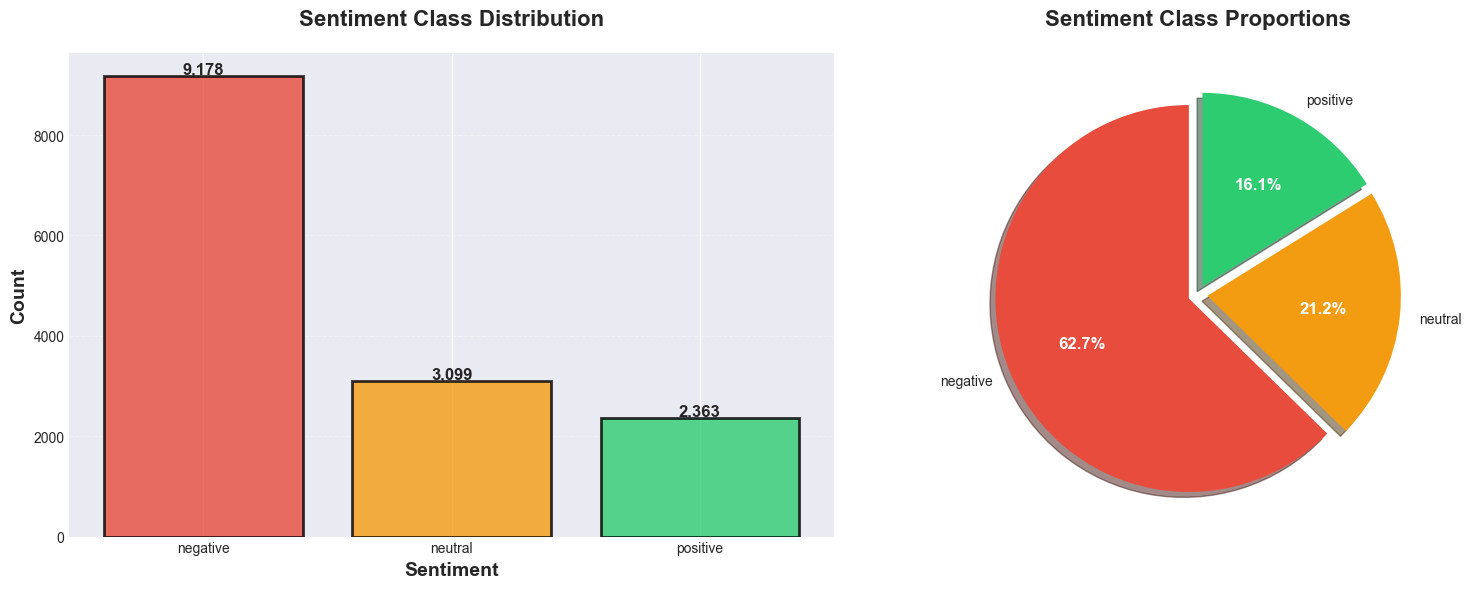


Class balance:
sentiment_label
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

Class percentages:
sentiment_label
negative    62.69
neutral     21.17
positive    16.14
Name: count, dtype: float64


In [ ]:
# 4.1 Sentiment Distribution - Visualizations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Count plot with enhanced styling
sentiment_counts = df['sentiment_label'].value_counts().sort_index()
colors = ['#e74c3c', '#f39c12', '#2ecc71']  # red, orange, green

bars = axes[0].bar(sentiment_counts.index, sentiment_counts.values, color=colors,
                   edgecolor='black', linewidth=2, alpha=0.8)
axes[0].set_title('Sentiment Class Distribution', fontsize=16, fontweight='bold', pad=20)
axes[0].set_xlabel('Sentiment', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3, linestyle='--')
for i, (bar, v) in enumerate(zip(bars, sentiment_counts.values)):
    axes[0].text(bar.get_x() + bar.get_width()/2., v, f'{v:,}',
                ha='center', va='bottom', fontweight='bold', fontsize=12)

# Enhanced pie chart
wedges, texts, autotexts = axes[1].pie(sentiment_counts.values, labels=sentiment_counts.index,
                                       autopct='%1.1f%%', colors=colors, startangle=90,
                                       explode=(0.05, 0.05, 0.05), shadow=True)
axes[1].set_title('Sentiment Class Proportions', fontsize=16, fontweight='bold', pad=20)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(12)

plt.tight_layout()
plt.savefig('../results/figures/tweets_01_sentiment_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nClass balance:")
print(sentiment_counts)
print(f"\nClass percentages:")
print((sentiment_counts / len(df) * 100).round(2))


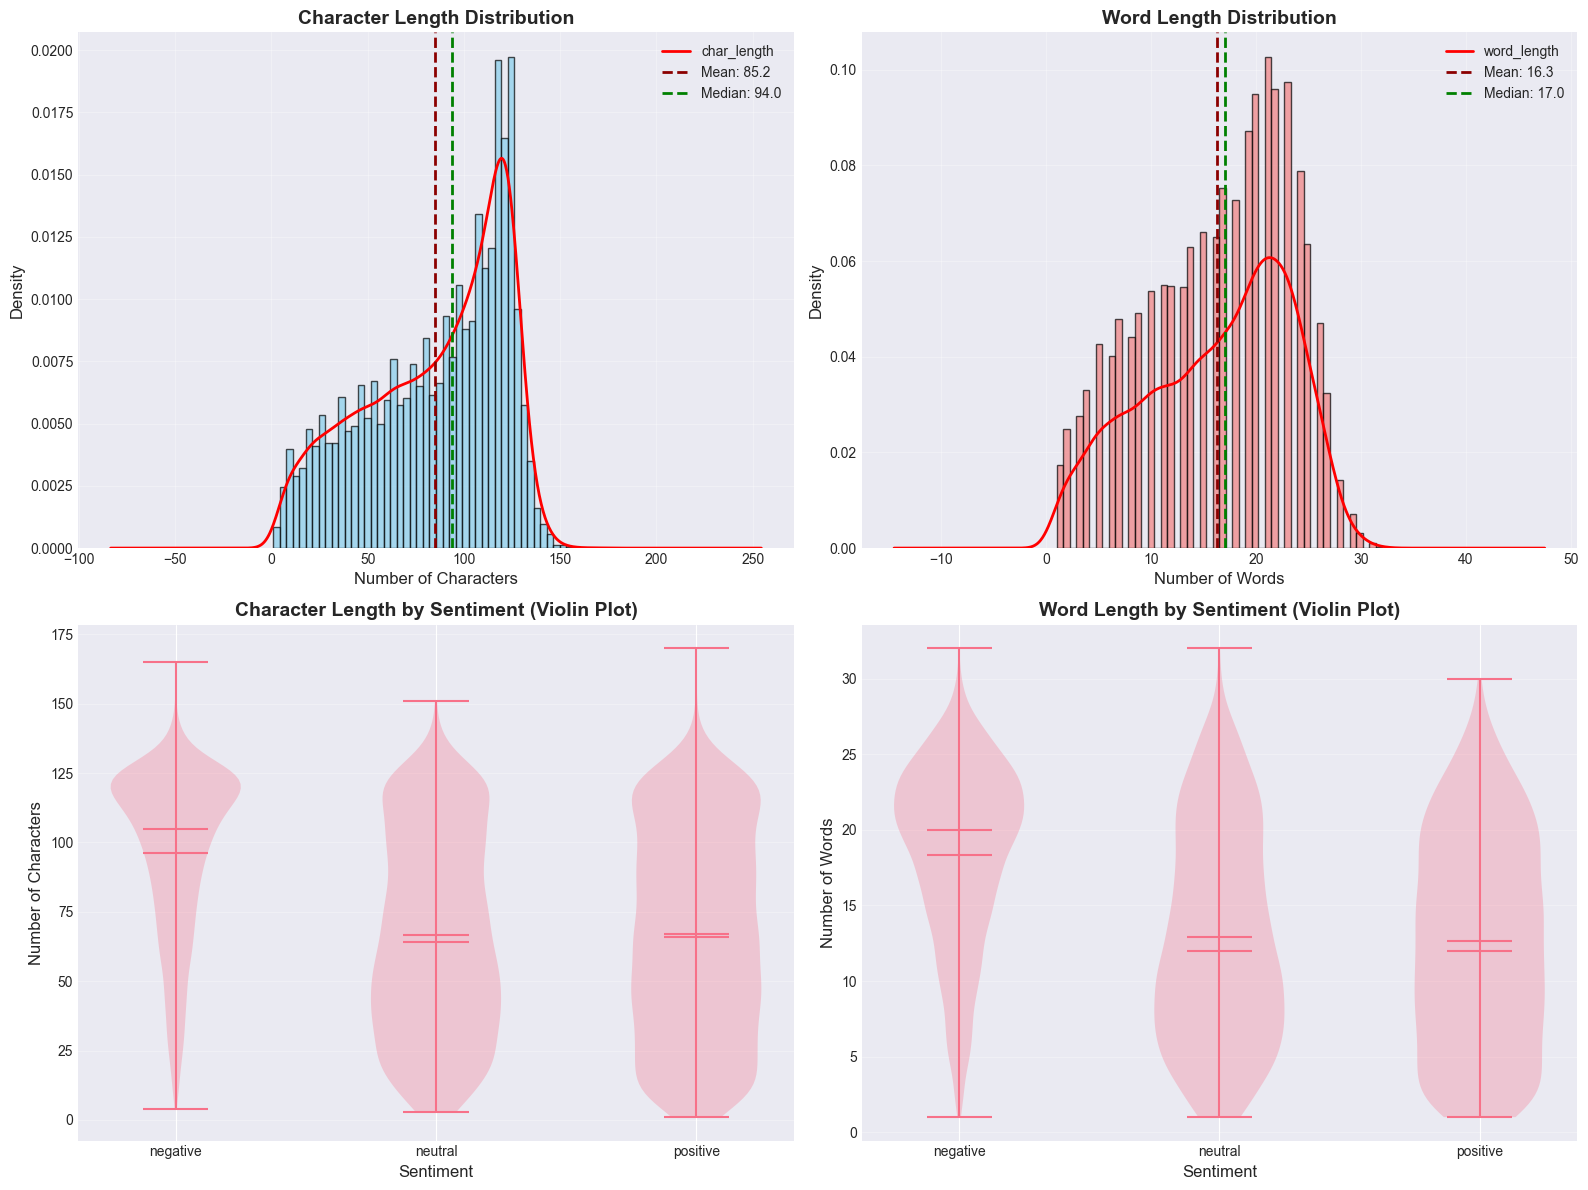


Length Statistics:
0       char_length   word_length
count  14640.000000  14640.000000
mean      85.231626     16.286407
std       35.758755      6.945909
min        1.000000      1.000000
25%       58.000000     11.000000
50%       94.000000     17.000000
75%      116.000000     22.000000
max      170.000000     32.000000


In [12]:
# 4.2 Tweet Length Analysis - Enhanced Visualizations
df['char_length'] = df['text_processed'].str.len()
df['word_length'] = df['text_processed'].str.split().str.len()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Character length distribution with KDE
axes[0, 0].hist(df['char_length'], bins=50, color='skyblue', edgecolor='black', alpha=0.7, density=True)
df['char_length'].plot(kind='kde', ax=axes[0, 0], color='red', linewidth=2)
axes[0, 0].axvline(df['char_length'].mean(), color='darkred', linestyle='--', linewidth=2,
                   label=f'Mean: {df["char_length"].mean():.1f}')
axes[0, 0].axvline(df['char_length'].median(), color='green', linestyle='--', linewidth=2,
                   label=f'Median: {df["char_length"].median():.1f}')
axes[0, 0].set_title('Character Length Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Number of Characters', fontsize=12)
axes[0, 0].set_ylabel('Density', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Word length distribution with KDE
axes[0, 1].hist(df['word_length'], bins=50, color='lightcoral', edgecolor='black', alpha=0.7, density=True)
df['word_length'].plot(kind='kde', ax=axes[0, 1], color='red', linewidth=2)
axes[0, 1].axvline(df['word_length'].mean(), color='darkred', linestyle='--', linewidth=2,
                   label=f'Mean: {df["word_length"].mean():.1f}')
axes[0, 1].axvline(df['word_length'].median(), color='green', linestyle='--', linewidth=2,
                   label=f'Median: {df["word_length"].median():.1f}')
axes[0, 1].set_title('Word Length Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Number of Words', fontsize=12)
axes[0, 1].set_ylabel('Density', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Character length by sentiment - Violin plot
sentiment_order = ['negative', 'neutral', 'positive']
data_to_plot = [df[df['sentiment_label'] == s]['char_length'].values for s in sentiment_order]
parts = axes[1, 0].violinplot(data_to_plot, positions=range(len(sentiment_order)),
                              showmeans=True, showmedians=True)
axes[1, 0].set_xticks(range(len(sentiment_order)))
axes[1, 0].set_xticklabels(sentiment_order)
axes[1, 0].set_title('Character Length by Sentiment (Violin Plot)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Sentiment', fontsize=12)
axes[1, 0].set_ylabel('Number of Characters', fontsize=12)
axes[1, 0].grid(axis='y', alpha=0.3)

# Word length by sentiment - Violin plot
data_to_plot = [df[df['sentiment_label'] == s]['word_length'].values for s in sentiment_order]
parts = axes[1, 1].violinplot(data_to_plot, positions=range(len(sentiment_order)),
                              showmeans=True, showmedians=True)
axes[1, 1].set_xticks(range(len(sentiment_order)))
axes[1, 1].set_xticklabels(sentiment_order)
axes[1, 1].set_title('Word Length by Sentiment (Violin Plot)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Sentiment', fontsize=12)
axes[1, 1].set_ylabel('Number of Words', fontsize=12)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/tweets_02_tweet_length_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nLength Statistics:")
print(df[['char_length', 'word_length']].describe())


✓ DataFrame state verified and corrected for EDA steps.


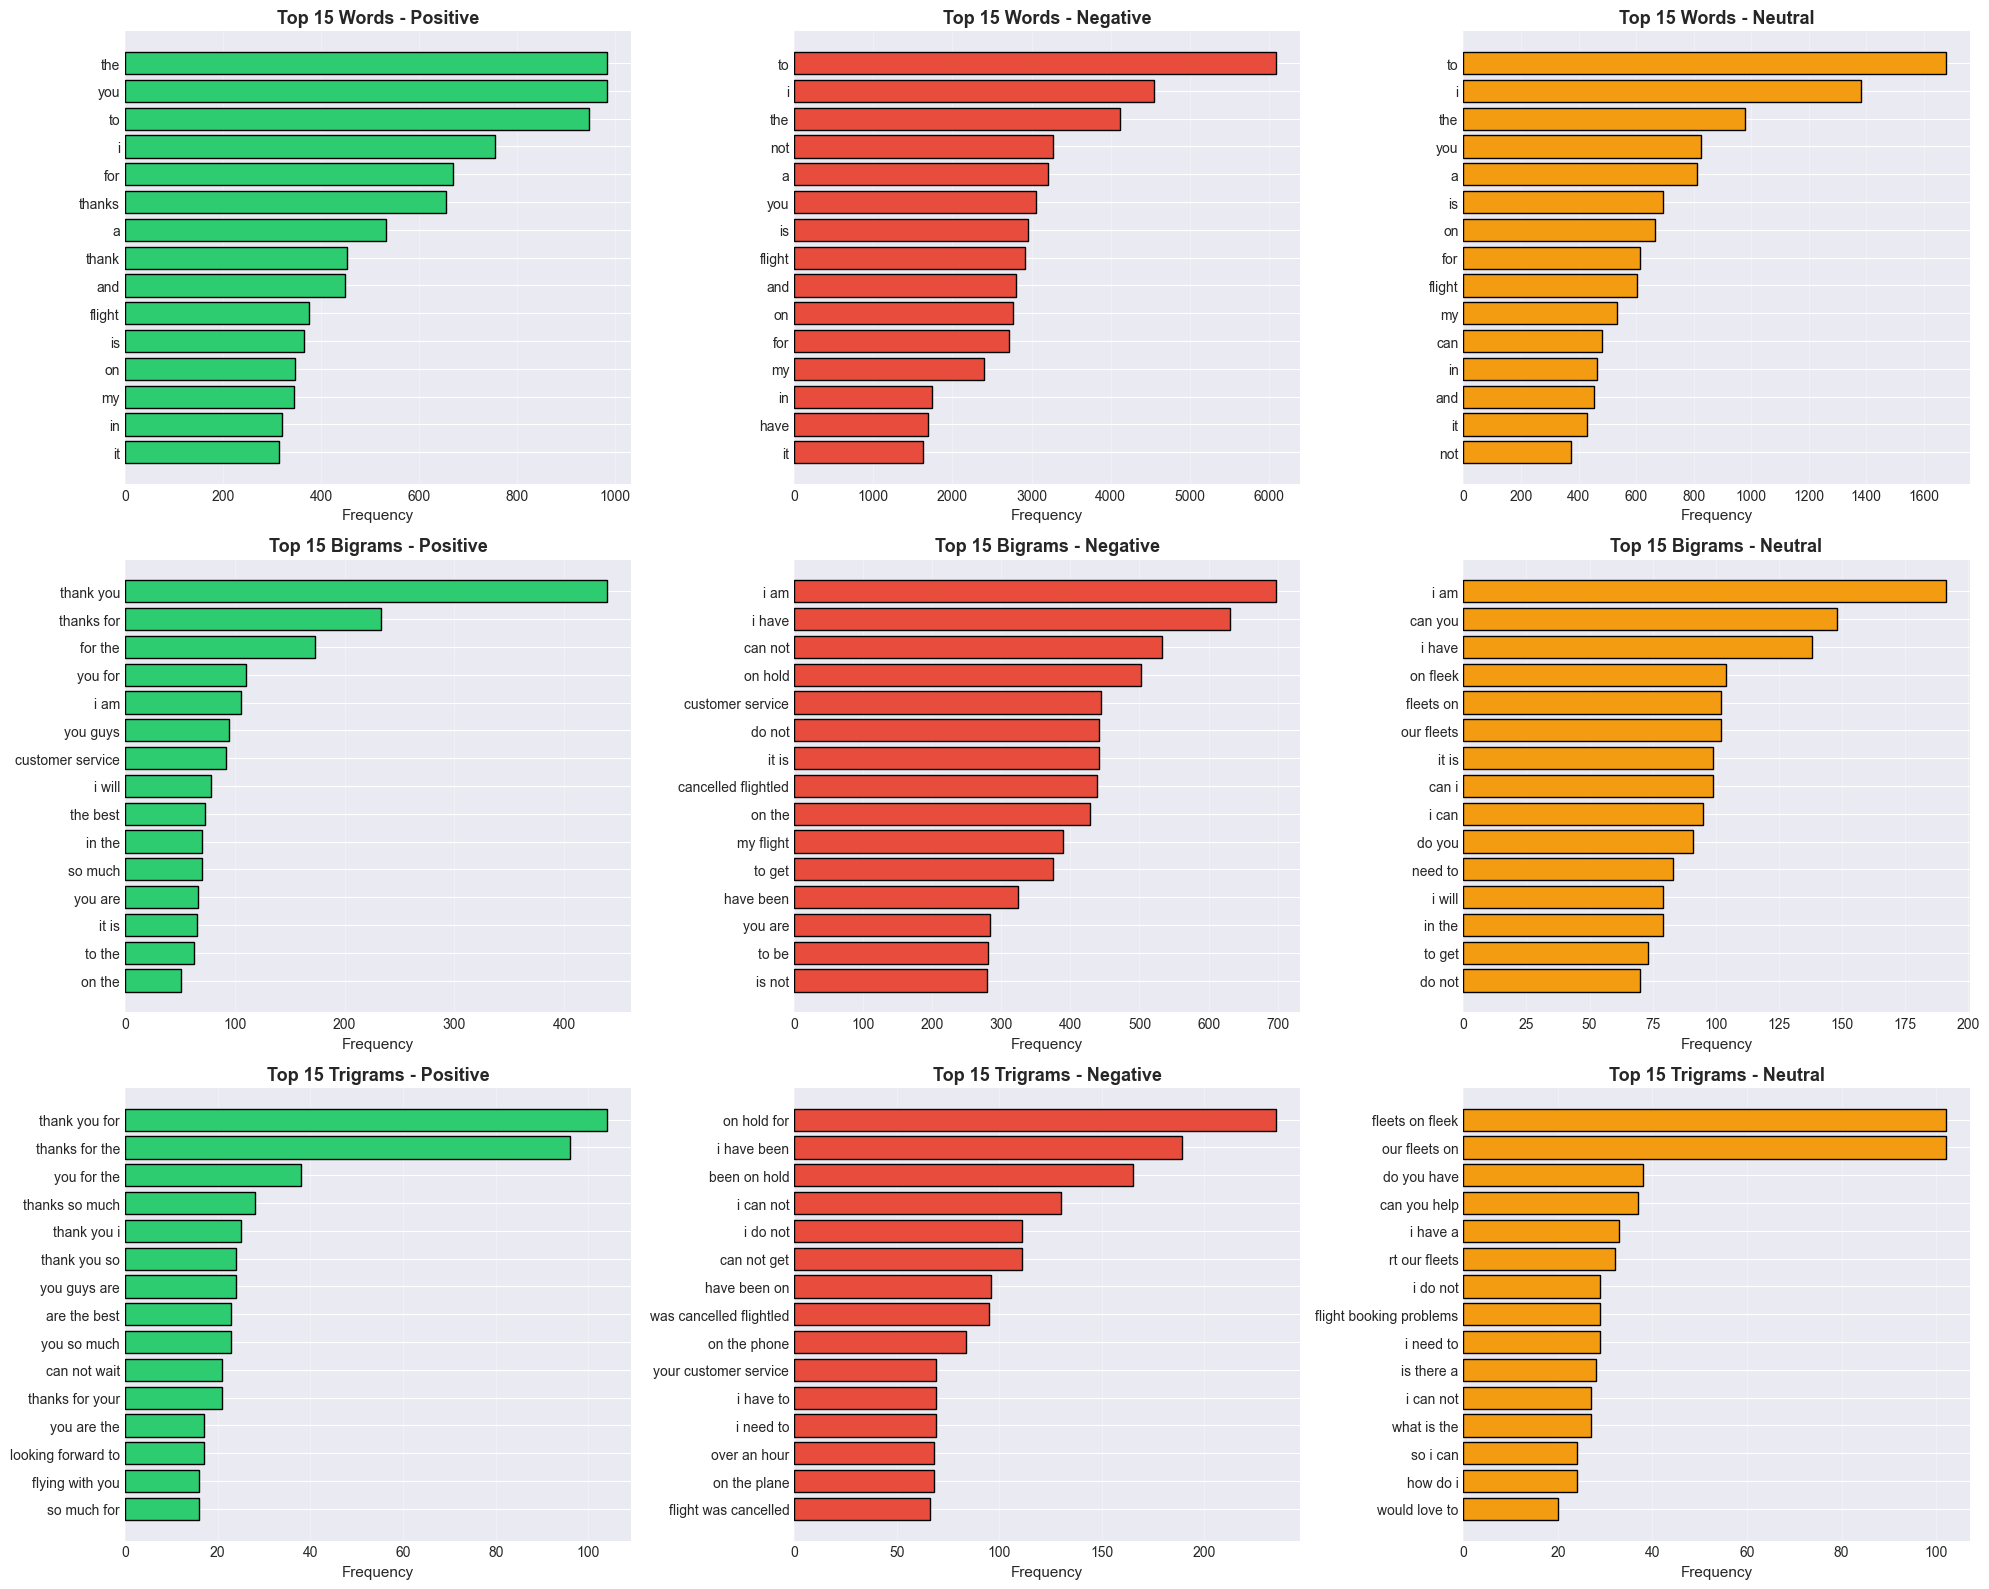

In [13]:
# 4.3 Most Common Words, Bigrams, Trigrams - Enhanced Visualizations
import pandas as pd # Ensure pandas is imported locally if cell is run independently
import matplotlib.pyplot as plt
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from typing import List, Tuple

# --- ENSURE DF IS IN CORRECT STATE FOR EDA ---
# This part ensures that 'df' has the correct structure and processed columns,
# in case previous cells were not run or df was reset.

# 1. Correct headers and rename sentiment column
# Check if headers are still numeric (raw state, e.g., 0, 1, 2...)
# Or if 'tweet_id' is missing (which would imply headers haven't been set correctly yet)
if df.columns[0] == 0 or 'tweet_id' not in df.columns:
    print("Correcting DataFrame headers and re-indexing...")
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)
    print("Headers corrected and df re-indexed.")

# Rename airline_sentiment to sentiment
if 'airline_sentiment' in df.columns and 'sentiment' not in df.columns:
    df = df.rename(columns={'airline_sentiment': 'sentiment'})
    print("Column 'airline_sentiment' renamed to 'sentiment'.")
elif 'airline_sentiment' not in df.columns and 'sentiment' not in df.columns:
    print("Warning: Neither 'airline_sentiment' nor 'sentiment' column found. Assuming 'sentiment' is already correct or data issue.")

# 2. Preprocess text if 'text_processed' column is missing
if 'text_processed' not in df.columns:
    print("Creating 'text_processed' column by reprocessing 'text'...")
    # Assuming 'preprocess_tweet' function is already defined in the global scope
    # (as per earlier cells in the notebook).
    # If not, it would need to be defined here or sourced.
    df['text_processed'] = df['text'].apply(preprocess_tweet)

    # Remove empty tweets after preprocessing (from I2Cb6TaGdzFR)
    initial_count = len(df)
    df = df[df['text_processed'].str.len() > 0].copy()
    final_count = len(df)
    if initial_count - final_count > 0:
        print(f"Removed {initial_count - final_count} empty tweets after reprocessing.")
    print("Text preprocessing complete.")

# 3. Normalize sentiment labels if 'sentiment_label' column is missing
if 'sentiment_label' not in df.columns:
    print("Creating 'sentiment_label' column by normalizing 'sentiment'...")
    # Define normalize_sentiment function locally to ensure availability, even if it's a duplicate
    def normalize_sentiment(sent):
        if pd.isna(sent) or sent == '':
            return 'unknown'
        sent_str = str(sent).lower().strip()
        if sent_str in ['negative', 'neg', '0', '0.0']: return 'negative'
        elif sent_str in ['neutral', 'neu', '1', '1.0', '2', '2.0']: return 'neutral'
        elif sent_str in ['positive', 'pos', '3', '3.0', '4', '4.0']: return 'positive'
        if 'neg' in sent_str: return 'negative'
        elif 'neu' in sent_str: return 'neutral'
        elif 'pos' in sent_str: return 'positive'
        return sent_str

    df['sentiment_label'] = df['sentiment'].apply(normalize_sentiment)

    # Filter to only keep negative, neutral, positive (from fNuWds7wd3pA)
    initial_count_sentiment = len(df)
    df = df[df['sentiment_label'].isin(['negative', 'neutral', 'positive'])].copy()
    final_count_sentiment = len(df)
    if initial_count_sentiment - final_count_sentiment > 0:
        print(f"Removed {initial_count_sentiment - final_count_sentiment} rows with unknown/invalid sentiment after reprocessing.")
    print("Sentiment normalization complete.")

# 4. Add char_length and word_length columns if missing (from qHiK7sofd_uj)
if 'char_length' not in df.columns:
    print("Creating 'char_length' and 'word_length' columns...")
    df['char_length'] = df['text_processed'].str.len()
    df['word_length'] = df['text_processed'].str.split().str.len()
    print("Length columns created.")

print("✓ DataFrame state verified and corrected for EDA steps.")
# --- END DF STATE CORRECTION ---

def get_ngrams(texts: List[str], n: int = 1, top_n: int = 20) -> List[Tuple[str, int]]:
    """Extract n-grams from a list of texts."""
    all_ngrams = []
    for text in texts:
        tokens = word_tokenize(text.lower())
        ngram_list = list(ngrams(tokens, n))
        all_ngrams.extend([' '.join(gram) for gram in ngram_list])
    return Counter(all_ngrams).most_common(top_n)

# Get n-grams for each sentiment
positive_texts = df[df['sentiment_label'] == 'positive']['text_processed'].tolist()
negative_texts = df[df['sentiment_label'] == 'negative']['text_processed'].tolist()
neutral_texts = df[df['sentiment_label'] == 'neutral']['text_processed'].tolist()

fig, axes = plt.subplots(3, 3, figsize=(20, 16))

# Words
pos_words = get_ngrams(positive_texts, n=1, top_n=15)
neg_words = get_ngrams(negative_texts, n=1, top_n=15)
neu_words = get_ngrams(neutral_texts, n=1, top_n=15)

# Sorting for better visualization if needed, but barh will sort automatically
# by value if no specific order is given, or by the order of values in the list.
# For consistent plots, we can sort.
pos_words = sorted(pos_words, key=lambda x: x[1], reverse=False)
neg_words = sorted(neg_words, key=lambda x: x[1], reverse=False)
neu_words = sorted(neu_words, key=lambda x: x[1], reverse=False)

axes[0, 0].barh([w[0] for w in pos_words], [w[1] for w in pos_words], color='#2ecc71', edgecolor='black')
axes[0, 0].set_title('Top 15 Words - Positive', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Frequency', fontsize=11)
axes[0, 0].grid(axis='x', alpha=0.3)

axes[0, 1].barh([w[0] for w in neg_words], [w[1] for w in neg_words], color='#e74c3c', edgecolor='black')
axes[0, 1].set_title('Top 15 Words - Negative', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Frequency', fontsize=11)
axes[0, 1].grid(axis='x', alpha=0.3)

axes[0, 2].barh([w[0] for w in neu_words], [w[1] for w in neu_words], color='#f39c12', edgecolor='black')
axes[0, 2].set_title('Top 15 Words - Neutral', fontsize=13, fontweight='bold')
axes[0, 2].set_xlabel('Frequency', fontsize=11)
axes[0, 2].grid(axis='x', alpha=0.3)

# Bigrams
pos_bigrams = get_ngrams(positive_texts, n=2, top_n=15)
neg_bigrams = get_ngrams(negative_texts, n=2, top_n=15)
neu_bigrams = get_ngrams(neutral_texts, n=2, top_n=15)

pos_bigrams = sorted(pos_bigrams, key=lambda x: x[1], reverse=False)
neg_bigrams = sorted(neg_bigrams, key=lambda x: x[1], reverse=False)
neu_bigrams = sorted(neu_bigrams, key=lambda x: x[1], reverse=False)

axes[1, 0].barh([w[0] for w in pos_bigrams], [w[1] for w in pos_bigrams], color='#2ecc71', edgecolor='black')
axes[1, 0].set_title('Top 15 Bigrams - Positive', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Frequency', fontsize=11)
axes[1, 0].grid(axis='x', alpha=0.3)

axes[1, 1].barh([w[0] for w in neg_bigrams], [w[1] for w in neg_bigrams], color='#e74c3c', edgecolor='black')
axes[1, 1].set_title('Top 15 Bigrams - Negative', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('Frequency', fontsize=11)
axes[1, 1].grid(axis='x', alpha=0.3)

axes[1, 2].barh([w[0] for w in neu_bigrams], [w[1] for w in neu_bigrams], color='#f39c12', edgecolor='black')
axes[1, 2].set_title('Top 15 Bigrams - Neutral', fontsize=13, fontweight='bold')
axes[1, 2].set_xlabel('Frequency', fontsize=11)
axes[1, 2].grid(axis='x', alpha=0.3)

# Trigrams
pos_trigrams = get_ngrams(positive_texts, n=3, top_n=15)
neg_trigrams = get_ngrams(negative_texts, n=3, top_n=15)
neu_trigrams = get_ngrams(neutral_texts, n=3, top_n=15)

pos_trigrams = sorted(pos_trigrams, key=lambda x: x[1], reverse=False)
neg_trigrams = sorted(neg_trigrams, key=lambda x: x[1], reverse=False)
neu_trigrams = sorted(neu_trigrams, key=lambda x: x[1], reverse=False)

axes[2, 0].barh([w[0] for w in pos_trigrams], [w[1] for w in pos_trigrams], color='#2ecc71', edgecolor='black')
axes[2, 0].set_title('Top 15 Trigrams - Positive', fontsize=13, fontweight='bold')
axes[2, 0].set_xlabel('Frequency', fontsize=11)
axes[2, 0].grid(axis='x', alpha=0.3)

axes[2, 1].barh([w[0] for w in neg_trigrams], [w[1] for w in neg_trigrams], color='#e74c3c', edgecolor='black')
axes[2, 1].set_title('Top 15 Trigrams - Negative', fontsize=13, fontweight='bold')
axes[2, 1].set_xlabel('Frequency', fontsize=11)
axes[2, 1].grid(axis='x', alpha=0.3)

axes[2, 2].barh([w[0] for w in neu_trigrams], [w[1] for w in neu_trigrams], color='#f39c12', edgecolor='black')
axes[2, 2].set_title('Top 15 Trigrams - Neutral', fontsize=13, fontweight='bold')
axes[2, 2].set_xlabel('Frequency', fontsize=11)
axes[2, 2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/tweets_03_ngrams_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


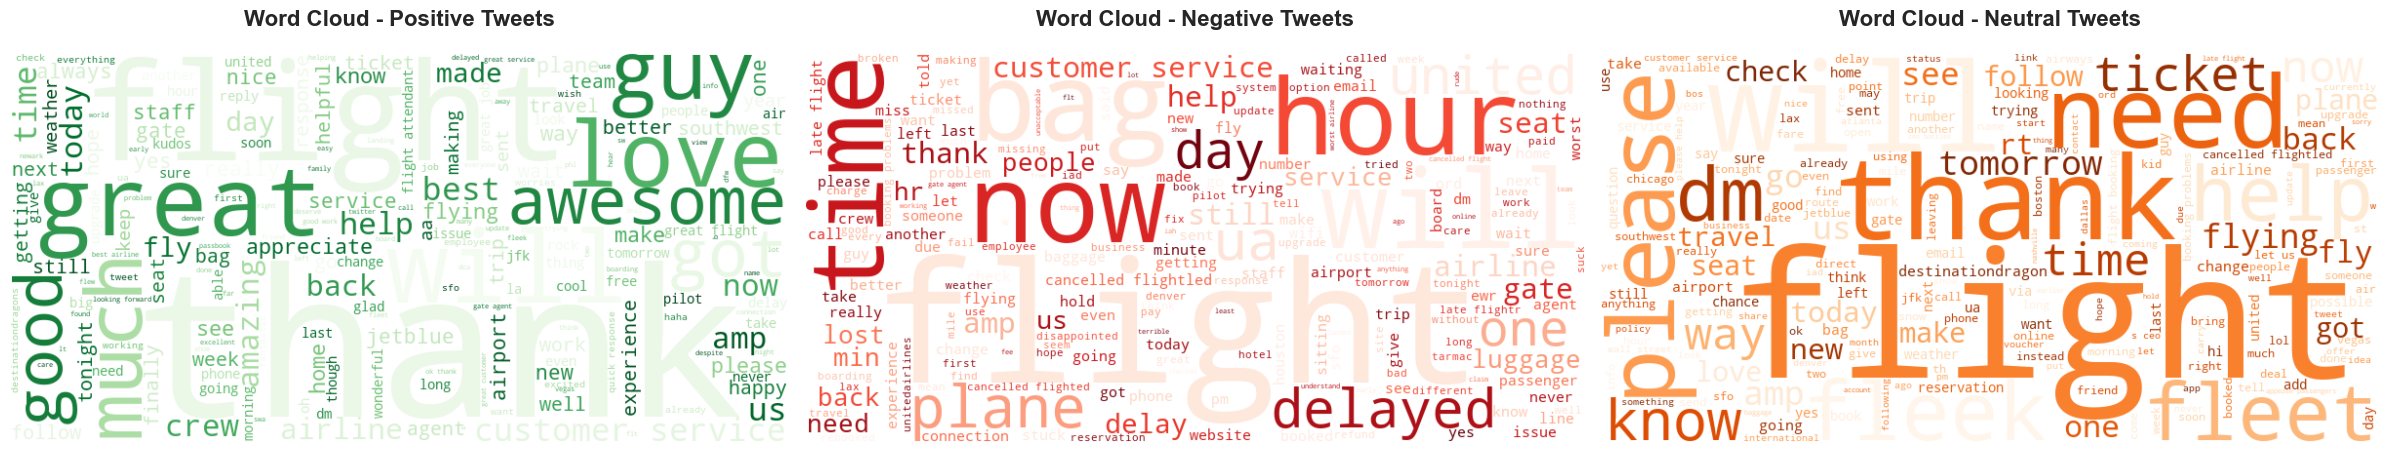

In [15]:
# 4.4 Word Clouds - Stunning Visualizations
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Sample texts for performance (use all if dataset is small)
sample_size = min(50000, len(positive_texts))
positive_text = ' '.join(positive_texts[:sample_size])
negative_text = ' '.join(negative_texts[:sample_size])
neutral_text = ' '.join(neutral_texts[:sample_size])

# Positive word cloud
wordcloud_pos = WordCloud(width=800, height=400, background_color='white',
                          colormap='Greens', max_words=200,
                          relative_scaling=0.5, random_state=42).generate(positive_text)
axes[0].imshow(wordcloud_pos, interpolation='bilinear')
axes[0].set_title('Word Cloud - Positive Tweets', fontsize=16, fontweight='bold', pad=20)
axes[0].axis('off')

# Negative word cloud
wordcloud_neg = WordCloud(width=800, height=400, background_color='white',
                          colormap='Reds', max_words=200,
                          relative_scaling=0.5, random_state=42).generate(negative_text)
axes[1].imshow(wordcloud_neg, interpolation='bilinear')
axes[1].set_title('Word Cloud - Negative Tweets', fontsize=16, fontweight='bold', pad=20)
axes[1].axis('off')

# Neutral word cloud
wordcloud_neu = WordCloud(width=800, height=400, background_color='white',
                          colormap='Oranges', max_words=200,
                          relative_scaling=0.5, random_state=42).generate(neutral_text)
axes[2].imshow(wordcloud_neu, interpolation='bilinear')
axes[2].set_title('Word Cloud - Neutral Tweets', fontsize=16, fontweight='bold', pad=20)
axes[2].axis('off')

plt.tight_layout()
plt.savefig('../results/figures/tweets_04_wordclouds.png', dpi=300, bbox_inches='tight')
plt.show()


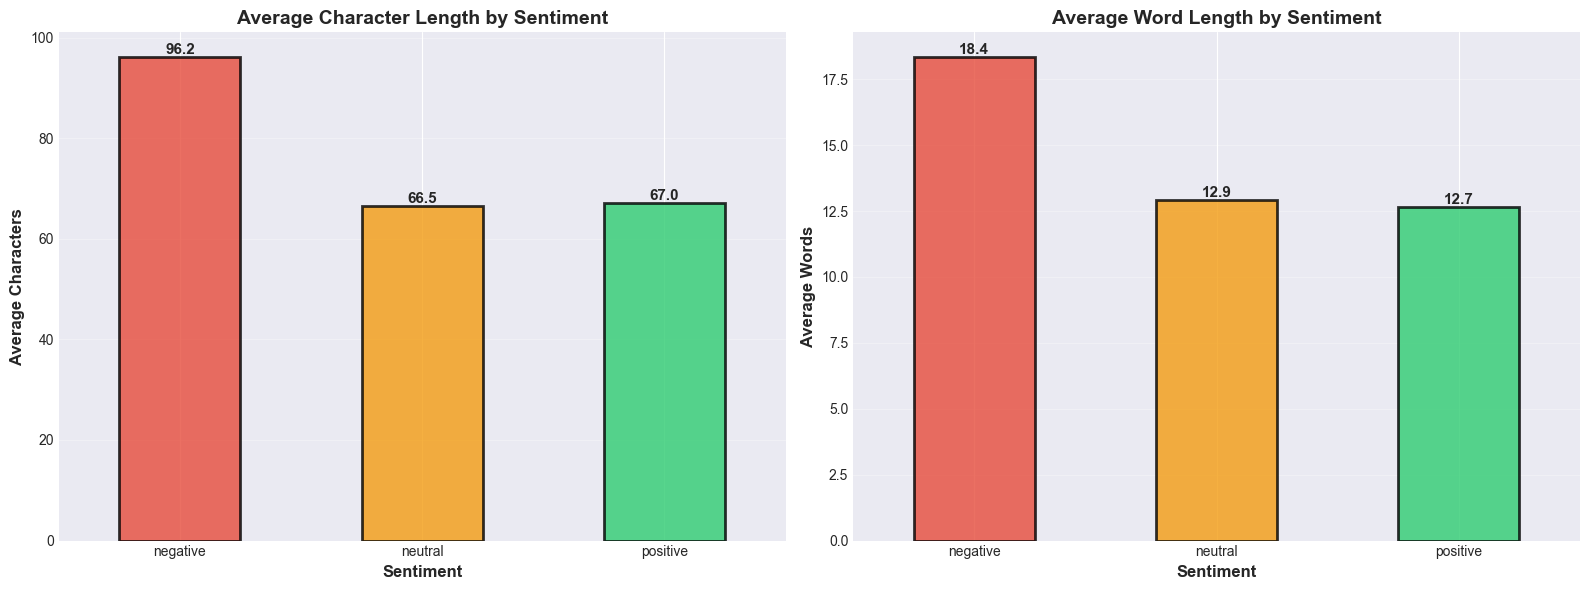

Average Lengths by Sentiment:
0                char_length  word_length
sentiment_label                          
negative               96.24        18.36
neutral                66.48        12.91
positive               67.05        12.65


In [16]:
# 4.5 Average Tweet Length by Sentiment - Enhanced
avg_lengths = df.groupby('sentiment_label').agg({
    'char_length': 'mean',
    'word_length': 'mean'
}).round(2)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

bars1 = avg_lengths['char_length'].plot(kind='bar', ax=axes[0], color=colors,
                                        edgecolor='black', linewidth=2, alpha=0.8)
axes[0].set_title('Average Character Length by Sentiment', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Average Characters', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Sentiment', fontsize=12, fontweight='bold')
axes[0].tick_params(axis='x', rotation=0)
axes[0].grid(axis='y', alpha=0.3)
for i, (bar, v) in enumerate(zip(bars1.patches, avg_lengths['char_length'])):
    axes[0].text(bar.get_x() + bar.get_width()/2., v, f'{v:.1f}',
                ha='center', va='bottom', fontweight='bold', fontsize=11)

bars2 = avg_lengths['word_length'].plot(kind='bar', ax=axes[1], color=colors,
                                        edgecolor='black', linewidth=2, alpha=0.8)
axes[1].set_title('Average Word Length by Sentiment', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Average Words', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Sentiment', fontsize=12, fontweight='bold')
axes[1].tick_params(axis='x', rotation=0)
axes[1].grid(axis='y', alpha=0.3)
for i, (bar, v) in enumerate(zip(bars2.patches, avg_lengths['word_length'])):
    axes[1].text(bar.get_x() + bar.get_width()/2., v, f'{v:.1f}',
                ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('../results/figures/tweets_05_avg_length_by_sentiment.png', dpi=300, bbox_inches='tight')
plt.show()

print("Average Lengths by Sentiment:")
print(avg_lengths)


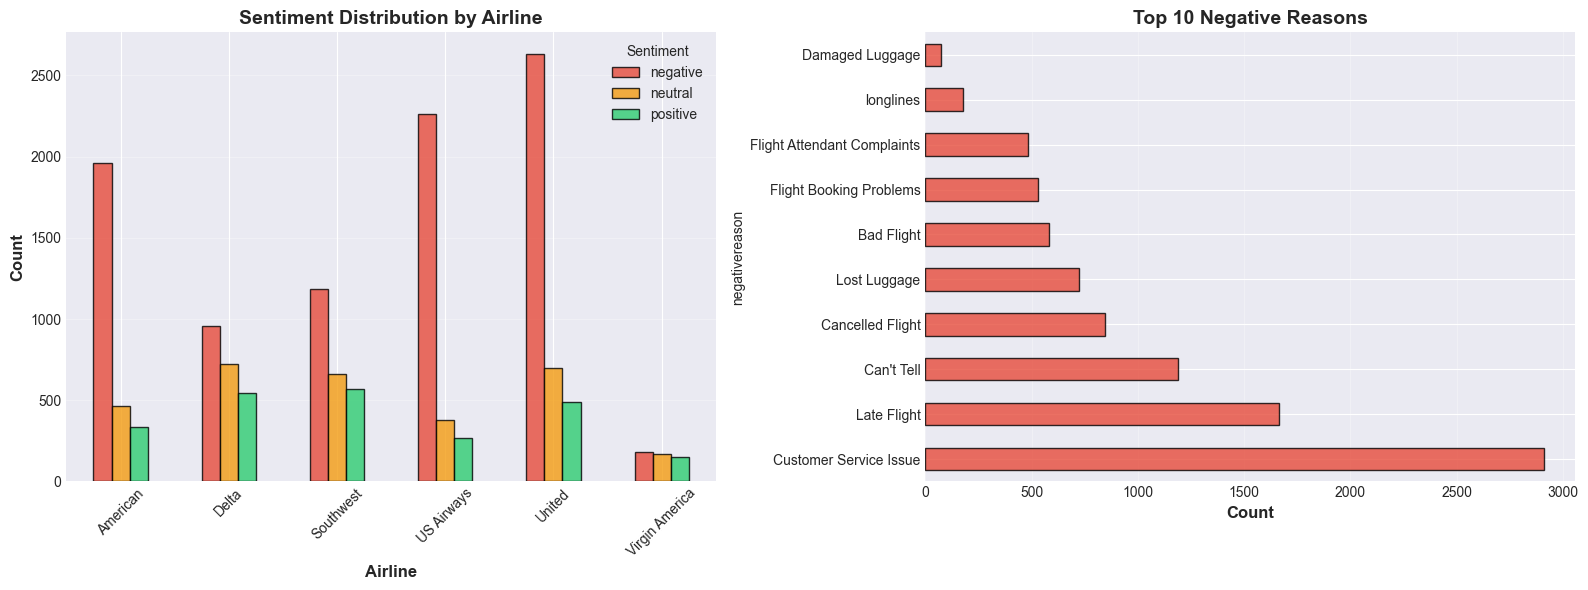

Airline sentiment distribution:
sentiment_label  negative  neutral  positive
airline                                     
American             1960      463       336
Delta                 955      723       544
Southwest            1186      664       570
US Airways           2263      381       269
United               2633      697       492
Virgin America        181      171       152


In [17]:
# 4.6 Additional EDA: Airline and Negative Reason Analysis
# This dataset has additional interesting columns we can analyze

if 'airline' in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Sentiment distribution by airline
    airline_sentiment = pd.crosstab(df['airline'], df['sentiment_label'])
    airline_sentiment.plot(kind='bar', ax=axes[0], color=colors, edgecolor='black', alpha=0.8)
    axes[0].set_title('Sentiment Distribution by Airline', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Airline', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Count', fontsize=12, fontweight='bold')
    axes[0].legend(title='Sentiment', fontsize=10)
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(axis='y', alpha=0.3)

    # Negative reasons (if available)
    if 'negativereason' in df.columns:
        neg_reasons = df[df['sentiment_label'] == 'negative']['negativereason'].value_counts().head(10)
        neg_reasons.plot(kind='barh', ax=axes[1], color='#e74c3c', edgecolor='black', alpha=0.8)
        axes[1].set_title('Top 10 Negative Reasons', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Count', fontsize=12, fontweight='bold')
        axes[1].grid(axis='x', alpha=0.3)
    else:
        axes[1].text(0.5, 0.5, 'Negative reason data not available',
                    ha='center', va='center', transform=axes[1].transAxes, fontsize=12)

    plt.tight_layout()
    plt.savefig('../results/figures/tweets_06_airline_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("Airline sentiment distribution:")
    print(airline_sentiment)
else:
    print("Airline column not found in dataset")


# 5. Train/Validation/Test Split


In [18]:
# --- Ensure df has 'sentiment_int' for stratified split ---
# This block ensures that the 'sentiment_int' column exists, which is crucial for stratified splitting.
# It replicates the logic from an earlier preprocessing step if the column is missing.

if 'sentiment_label' not in df.columns:
    print("Warning: 'sentiment_label' not found. Re-creating sentiment labels.")
    # Define normalize_sentiment function locally to ensure availability
    def normalize_sentiment(sent):
        if pd.isna(sent) or sent == '':
            return 'unknown'
        sent_str = str(sent).lower().strip()
        if sent_str in ['negative', 'neg', '0', '0.0']: return 'negative'
        elif sent_str in ['neutral', 'neu', '1', '1.0', '2', '2.0']: return 'neutral'
        elif sent_str in ['positive', 'pos', '3', '3.0', '4', '4.0']: return 'positive'
        if 'neg' in sent_str: return 'negative'
        elif 'neu' in sent_str: return 'neutral'
        elif 'pos' in sent_str: return 'positive'
        return sent_str

    df['sentiment_label'] = df['sentiment'].apply(normalize_sentiment)
    # Filter to only keep negative, neutral, positive
    initial_count_sentiment = len(df)
    df = df[df['sentiment_label'].isin(['negative', 'neutral', 'positive'])].copy()
    if initial_count_sentiment - len(df) > 0:
        print(f"Removed {initial_count_sentiment - len(df)} rows with unknown/invalid sentiment during re-creation.")
    print("Sentiment labels re-created.")

if 'sentiment_int' not in df.columns:
    print("Warning: 'sentiment_int' not found. Mapping sentiment labels to integers.")
    label_to_int = {'negative': 0, 'neutral': 1, 'positive': 2}
    df['sentiment_int'] = df['sentiment_label'].map(label_to_int)
    print("'sentiment_int' column created.")

# --- End of df preparation for split ---

# Stratified split: 80% train, 10% validation, 10% test
X = df[['text_processed', 'text']].copy()
y = df['sentiment_int'].copy()

# First split: 80% train, 20% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Second split: 50% of temp = 10% of total for val, 50% for test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training set:   {len(X_train):,} samples ({len(X_train)/len(df)*100:.1f}%)")
print(f"Validation set: {len(X_val):,} samples ({len(X_val)/len(df)*100:.1f}%)")
print(f"Test set:       {len(X_test):,} samples ({len(X_test)/len(df)*100:.1f}%)")
print(f"\nClass distribution in training set:")
print(y_train.value_counts().sort_index())
print(f"\nClass distribution in validation set:")
print(y_val.value_counts().sort_index())
print(f"\nClass distribution in test set:")
print(y_test.value_counts().sort_index())

Training set:   11,712 samples (80.0%)
Validation set: 1,464 samples (10.0%)
Test set:       1,464 samples (10.0%)

Class distribution in training set:
sentiment_int
0    7343
1    2479
2    1890
Name: count, dtype: int64

Class distribution in validation set:
sentiment_int
0    917
1    310
2    237
Name: count, dtype: int64

Class distribution in test set:
sentiment_int
0    918
1    310
2    236
Name: count, dtype: int64


# 6. Model Training and Evaluation


## 6.1 Baseline: TF-IDF + Logistic Regression


In [19]:
print("Training TF-IDF + Logistic Regression baseline...")

# Vectorize text
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), min_df=2)
X_train_tfidf = vectorizer.fit_transform(X_train['text_processed'])
X_val_tfidf = vectorizer.transform(X_val['text_processed'])
X_test_tfidf = vectorizer.transform(X_test['text_processed'])

# Train logistic regression (multi-class)
lr_model = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1, multi_class='multinomial')
start_time_lr = time.time()
lr_model.fit(X_train_tfidf, y_train)
training_time_lr = time.time() - start_time_lr

# Predictions
y_train_pred_lr = lr_model.predict(X_train_tfidf)
y_val_pred_lr = lr_model.predict(X_val_tfidf)
y_test_pred_lr = lr_model.predict(X_test_tfidf)

# Metrics
lr_train_acc = accuracy_score(y_train, y_train_pred_lr)
lr_val_acc = accuracy_score(y_val, y_val_pred_lr)
lr_test_acc = accuracy_score(y_test, y_test_pred_lr)

# Test metrics
lr_test_precision_macro, lr_test_recall_macro, lr_test_f1_macro, _ = precision_recall_fscore_support(
    y_test, y_test_pred_lr, average='macro', zero_division=0
)
lr_test_precision_weighted, lr_test_recall_weighted, lr_test_f1_weighted, _ = precision_recall_fscore_support(
    y_test, y_test_pred_lr, average='weighted', zero_division=0
)

# Train metrics
lr_train_precision_macro, lr_train_recall_macro, lr_train_f1_macro, _ = precision_recall_fscore_support(
    y_train, y_train_pred_lr, average='macro', zero_division=0
)
lr_train_precision_weighted, lr_train_recall_weighted, lr_train_f1_weighted, _ = precision_recall_fscore_support(
    y_train, y_train_pred_lr, average='weighted', zero_division=0
)

# Validation metrics
lr_val_precision_macro, lr_val_recall_macro, lr_val_f1_macro, _ = precision_recall_fscore_support(
    y_val, y_val_pred_lr, average='macro', zero_division=0
)
lr_val_precision_weighted, lr_val_recall_weighted, lr_val_f1_weighted, _ = precision_recall_fscore_support(
    y_val, y_val_pred_lr, average='weighted', zero_division=0
)

print(f"\n✓ Baseline Model Trained!")
print(f"  Training time: {training_time_lr:.2f} seconds")
print(f"  Train Accuracy: {lr_train_acc:.4f}")
print(f"  Val Accuracy:   {lr_val_acc:.4f}")
print(f"  Test Accuracy:  {lr_test_acc:.4f}")
print(f"  Test Precision (macro): {lr_test_precision_macro:.4f}")
print(f"  Test Recall (macro):    {lr_test_recall_macro:.4f}")
print(f"  Test F1-Score (macro):  {lr_test_f1_macro:.4f}")
print(f"  Test F1-Score (weighted): {lr_test_f1_weighted:.4f}")


Training TF-IDF + Logistic Regression baseline...



✓ Baseline Model Trained!
  Training time: 2.17 seconds
  Train Accuracy: 0.8861
  Val Accuracy:   0.7937
  Test Accuracy:  0.8087
  Test Precision (macro): 0.7959
  Test Recall (macro):    0.6986
  Test F1-Score (macro):  0.7347
  Test F1-Score (weighted): 0.7979


## 6.2 LSTM (Long Short-Term Memory) - Deep Learning Model


In [20]:
print("Training LSTM (Long Short-Term Memory) model...")
print("Note: LSTM is a deep learning model that can capture sequential patterns in text!")

# Tokenize and prepare sequences for LSTM
max_words = 10000  # Maximum vocabulary size
max_len = 100      # Maximum sequence length

# Initialize tokenizer
lstm_tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
lstm_tokenizer.fit_on_texts(X_train['text_processed'].tolist())

# Convert texts to sequences
X_train_seq = lstm_tokenizer.texts_to_sequences(X_train['text_processed'].tolist())
X_val_seq = lstm_tokenizer.texts_to_sequences(X_val['text_processed'].tolist())
X_test_seq = lstm_tokenizer.texts_to_sequences(X_test['text_processed'].tolist())

# Pad sequences to same length
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=max_len, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

# Convert labels to categorical (one-hot encoding)
y_train_cat = to_categorical(y_train, num_classes=3)
y_val_cat = to_categorical(y_val, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

print(f"✓ Sequences prepared!")
print(f"  Vocabulary size: {len(lstm_tokenizer.word_index):,} words")
print(f"  Sequence length: {max_len}")
print(f"  Train: {len(X_train_padded):,} samples")
print(f"  Val:   {len(X_val_padded):,} samples")
print(f"  Test:  {len(X_test_padded):,} samples")

# Build LSTM model
embedding_dim = 128
lstm_units = 64

lstm_model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    Dropout(0.3),
    Bidirectional(LSTM(lstm_units, return_sequences=False)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')  # 3 classes: negative, neutral, positive
])

# Compile model
lstm_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n✓ LSTM Model Architecture:")
lstm_model.summary()


Training LSTM (Long Short-Term Memory) model...
Note: LSTM is a deep learning model that can capture sequential patterns in text!


✓ Sequences prepared!
  Vocabulary size: 11,015 words
  Sequence length: 100
  Train: 11,712 samples
  Val:   1,464 samples
  Test:  1,464 samples

✓ LSTM Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Train LSTM model
batch_size = 32
epochs = 10

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=0.0001,
    verbose=1
)

print("\nStarting LSTM training...")
start_time = time.time()

# Train the model
history = lstm_model.fit(
    X_train_padded, y_train_cat,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val_padded, y_val_cat),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

training_time = time.time() - start_time
print(f"\n✓ LSTM training complete in {training_time:.2f} seconds ({training_time/60:.2f} minutes)!")

# Make predictions
y_train_pred_lstm_proba = lstm_model.predict(X_train_padded, verbose=0)
y_val_pred_lstm_proba = lstm_model.predict(X_val_padded, verbose=0)
y_test_pred_lstm_proba = lstm_model.predict(X_test_padded, verbose=0)

# Convert probabilities to class predictions
y_train_pred_lstm = np.argmax(y_train_pred_lstm_proba, axis=1)
y_val_pred_lstm = np.argmax(y_val_pred_lstm_proba, axis=1)
y_test_pred_lstm = np.argmax(y_test_pred_lstm_proba, axis=1)

# Metrics
lstm_train_acc = accuracy_score(y_train, y_train_pred_lstm)
lstm_val_acc = accuracy_score(y_val, y_val_pred_lstm)
lstm_test_acc = accuracy_score(y_test, y_test_pred_lstm)

# Test metrics
lstm_test_precision_macro, lstm_test_recall_macro, lstm_test_f1_macro, _ = precision_recall_fscore_support(
    y_test, y_test_pred_lstm, average='macro', zero_division=0
)
lstm_test_precision_weighted, lstm_test_recall_weighted, lstm_test_f1_weighted, _ = precision_recall_fscore_support(
    y_test, y_test_pred_lstm, average='weighted', zero_division=0
)

# Train metrics
lstm_train_precision_macro, lstm_train_recall_macro, lstm_train_f1_macro, _ = precision_recall_fscore_support(
    y_train, y_train_pred_lstm, average='macro', zero_division=0
)
lstm_train_precision_weighted, lstm_train_recall_weighted, lstm_train_f1_weighted, _ = precision_recall_fscore_support(
    y_train, y_train_pred_lstm, average='weighted', zero_division=0
)

# Validation metrics
lstm_val_precision_macro, lstm_val_recall_macro, lstm_val_f1_macro, _ = precision_recall_fscore_support(
    y_val, y_val_pred_lstm, average='macro', zero_division=0
)
lstm_val_precision_weighted, lstm_val_recall_weighted, lstm_val_f1_weighted, _ = precision_recall_fscore_support(
    y_val, y_val_pred_lstm, average='weighted', zero_division=0
)

print(f"\n✓ LSTM Model Trained and Evaluated!")
print(f"  Training time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")
print(f"  Train Accuracy: {lstm_train_acc:.4f}")
print(f"  Val Accuracy:   {lstm_val_acc:.4f}")
print(f"  Test Accuracy:  {lstm_test_acc:.4f}")
print(f"  Test Precision (macro): {lstm_test_precision_macro:.4f}")
print(f"  Test Recall (macro):    {lstm_test_recall_macro:.4f}")
print(f"  Test F1-Score (macro):  {lstm_test_f1_macro:.4f}")
print(f"  Test F1-Score (weighted): {lstm_test_f1_weighted:.4f}")



Starting LSTM training...
Epoch 1/10



  1/366 ━━━━━━━━━━━━━━━━━━━━ 12:21 2s/step - accuracy: 0.1875 - loss: 1.1006


  3/366 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.3663 - loss: 1.0892


  5/366 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.4245 - loss: 1.0825


  7/366 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.4598 - loss: 1.0738 


  9/366 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.4833 - loss: 1.0644


 11/366 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.5020 - loss: 1.0529


 14/366 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5253 - loss: 1.0345


 16/366 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5362 - loss: 1.0264


 18/366 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.5448 - loss: 1.0201


 20/366 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5510 - loss: 1.0160


 22/366 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5568 - loss: 1.0118


 24/366 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5613 - loss: 1.0080


 26/366 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5654 - loss: 1.0045


 29/366 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5709 - loss: 0.9995


 32/366 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5760 - loss: 0.9945


 35/366 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5803 - loss: 0.9902


 38/366 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.5837 - loss: 0.9864


 41/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.5866 - loss: 0.9827


 44/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.5891 - loss: 0.9790


 47/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.5911 - loss: 0.9756


 50/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.5929 - loss: 0.9722


 53/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.5946 - loss: 0.9685


 56/366 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.5962 - loss: 0.9651


 59/366 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.5976 - loss: 0.9616


 62/366 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.5989 - loss: 0.9583


 65/366 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.6002 - loss: 0.9550


 68/366 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.6014 - loss: 0.9519


 71/366 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.6026 - loss: 0.9490


 74/366 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.6037 - loss: 0.9463


 77/366 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.6047 - loss: 0.9436


 80/366 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.6057 - loss: 0.9409


 83/366 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.6068 - loss: 0.9383


 86/366 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.6077 - loss: 0.9358


 89/366 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.6087 - loss: 0.9333


 92/366 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.6095 - loss: 0.9310


 95/366 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.6104 - loss: 0.9286


 98/366 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.6112 - loss: 0.9262


101/366 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.6120 - loss: 0.9237


104/366 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6129 - loss: 0.9212


107/366 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6137 - loss: 0.9188


110/366 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6146 - loss: 0.9164


113/366 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6155 - loss: 0.9140


116/366 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6163 - loss: 0.9116


119/366 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6171 - loss: 0.9093


122/366 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6178 - loss: 0.9071


125/366 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6186 - loss: 0.9049


128/366 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6193 - loss: 0.9028


131/366 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6201 - loss: 0.9006


134/366 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6209 - loss: 0.8985


137/366 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6217 - loss: 0.8964


140/366 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6225 - loss: 0.8943


143/366 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6233 - loss: 0.8922


146/366 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6241 - loss: 0.8901


149/366 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.6249 - loss: 0.8880


152/366 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.6257 - loss: 0.8861


155/366 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.6264 - loss: 0.8841


158/366 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.6272 - loss: 0.8822


161/366 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.6279 - loss: 0.8803


164/366 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.6286 - loss: 0.8784


167/366 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.6293 - loss: 0.8765


170/366 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.6300 - loss: 0.8747


173/366 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.6307 - loss: 0.8729


176/366 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.6315 - loss: 0.8711


179/366 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.6322 - loss: 0.8693


182/366 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.6329 - loss: 0.8676


185/366 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.6336 - loss: 0.8658


188/366 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.6343 - loss: 0.8641


191/366 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6350 - loss: 0.8624


194/366 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6357 - loss: 0.8608


197/366 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6364 - loss: 0.8591


200/366 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6371 - loss: 0.8575


203/366 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6377 - loss: 0.8559


206/366 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6383 - loss: 0.8543


208/366 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6387 - loss: 0.8533


211/366 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6394 - loss: 0.8517


214/366 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6400 - loss: 0.8502


216/366 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6404 - loss: 0.8492


219/366 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6410 - loss: 0.8477


221/366 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6414 - loss: 0.8468


224/366 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6419 - loss: 0.8454


227/366 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6425 - loss: 0.8440


230/366 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6431 - loss: 0.8426


233/366 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6437 - loss: 0.8412


236/366 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6443 - loss: 0.8399


239/366 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6449 - loss: 0.8385


241/366 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6452 - loss: 0.8376


244/366 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6458 - loss: 0.8363


246/366 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6462 - loss: 0.8354


249/366 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6467 - loss: 0.8341


252/366 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6473 - loss: 0.8329


254/366 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6476 - loss: 0.8320


257/366 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6482 - loss: 0.8307


259/366 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6485 - loss: 0.8299


261/366 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6489 - loss: 0.8291


263/366 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6493 - loss: 0.8282


265/366 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6496 - loss: 0.8273


267/366 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6500 - loss: 0.8265


269/366 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6504 - loss: 0.8256


271/366 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6507 - loss: 0.8248


273/366 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6511 - loss: 0.8240


275/366 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6514 - loss: 0.8231


277/366 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6518 - loss: 0.8223


279/366 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6521 - loss: 0.8215


281/366 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6525 - loss: 0.8207


283/366 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6528 - loss: 0.8199


285/366 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6532 - loss: 0.8191


287/366 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6535 - loss: 0.8183


289/366 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6538 - loss: 0.8175


291/366 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6542 - loss: 0.8167


293/366 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6545 - loss: 0.8159


295/366 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6549 - loss: 0.8151


297/366 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6552 - loss: 0.8143


299/366 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6556 - loss: 0.8135


301/366 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6559 - loss: 0.8127


303/366 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6562 - loss: 0.8120


305/366 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6566 - loss: 0.8112


307/366 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6569 - loss: 0.8104


309/366 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6572 - loss: 0.8097


311/366 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6576 - loss: 0.8089


313/366 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6579 - loss: 0.8082


315/366 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6582 - loss: 0.8075


317/366 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6586 - loss: 0.8067


319/366 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6589 - loss: 0.8060


321/366 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6592 - loss: 0.8053


324/366 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6597 - loss: 0.8042


327/366 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6602 - loss: 0.8031


329/366 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6605 - loss: 0.8024


332/366 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6610 - loss: 0.8014


334/366 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6613 - loss: 0.8007


336/366 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6617 - loss: 0.8000


338/366 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6620 - loss: 0.7993


340/366 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6623 - loss: 0.7986


342/366 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6626 - loss: 0.7979


344/366 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6630 - loss: 0.7972


347/366 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6634 - loss: 0.7962


349/366 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6638 - loss: 0.7955


351/366 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6641 - loss: 0.7948


353/366 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6644 - loss: 0.7942


355/366 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6647 - loss: 0.7935


357/366 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6650 - loss: 0.7928


359/366 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6654 - loss: 0.7922


361/366 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6657 - loss: 0.7915


363/366 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6660 - loss: 0.7909


365/366 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6663 - loss: 0.7902


366/366 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.7234 - loss: 0.6712 - val_accuracy: 0.7869 - val_loss: 0.5323 - learning_rate: 0.0010


Epoch 2/10



  1/366 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.7812 - loss: 0.3844


  3/366 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.8160 - loss: 0.3700


  5/366 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.8102 - loss: 0.4123


  7/366 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.8062 - loss: 0.4444


  9/366 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.8027 - loss: 0.4649


 11/366 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.8007 - loss: 0.4737


 13/366 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.8011 - loss: 0.4768


 15/366 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.8020 - loss: 0.4791


 17/366 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.8022 - loss: 0.4822


 19/366 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.8019 - loss: 0.4853


 21/366 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.8020 - loss: 0.4868


 23/366 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.8018 - loss: 0.4881


 25/366 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.8015 - loss: 0.4897


 27/366 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.8013 - loss: 0.4914


 29/366 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.8011 - loss: 0.4927


 31/366 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.8011 - loss: 0.4936


 33/366 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.8012 - loss: 0.4944


 35/366 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.8011 - loss: 0.4958


 37/366 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.8008 - loss: 0.4972


 39/366 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.8005 - loss: 0.4987


 41/366 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.8003 - loss: 0.5000 


 43/366 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.8002 - loss: 0.5010


 45/366 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.8002 - loss: 0.5018


 47/366 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.8001 - loss: 0.5025


 49/366 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.8001 - loss: 0.5031


 51/366 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.8002 - loss: 0.5034


 53/366 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.8003 - loss: 0.5037


 55/366 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.8003 - loss: 0.5041


 57/366 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.8003 - loss: 0.5044


 59/366 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.8003 - loss: 0.5047


 61/366 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.8003 - loss: 0.5051


 63/366 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.8002 - loss: 0.5054


 65/366 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.8002 - loss: 0.5056


 67/366 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.8003 - loss: 0.5058


 69/366 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.8004 - loss: 0.5060


 71/366 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.8005 - loss: 0.5061


 73/366 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.8006 - loss: 0.5063


 75/366 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.8007 - loss: 0.5064


 77/366 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.8009 - loss: 0.5065


 79/366 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.8011 - loss: 0.5065


 81/366 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.8013 - loss: 0.5066


 83/366 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.8014 - loss: 0.5066


 85/366 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.8016 - loss: 0.5067


 87/366 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.8017 - loss: 0.5067


 89/366 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.8018 - loss: 0.5068


 91/366 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.8019 - loss: 0.5068


 93/366 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.8020 - loss: 0.5068


 95/366 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.8022 - loss: 0.5067


 97/366 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.8023 - loss: 0.5067


 99/366 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.8024 - loss: 0.5066


101/366 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.8026 - loss: 0.5065


103/366 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.8028 - loss: 0.5064


105/366 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.8029 - loss: 0.5063


107/366 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.8031 - loss: 0.5062


109/366 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8033 - loss: 0.5060


111/366 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8034 - loss: 0.5058


113/366 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8036 - loss: 0.5056


115/366 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8038 - loss: 0.5053


117/366 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8040 - loss: 0.5051


119/366 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8042 - loss: 0.5048


121/366 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8043 - loss: 0.5046


123/366 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8045 - loss: 0.5044


125/366 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8046 - loss: 0.5042


127/366 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8048 - loss: 0.5040


129/366 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8049 - loss: 0.5038


131/366 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8051 - loss: 0.5036


133/366 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8053 - loss: 0.5034


135/366 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8054 - loss: 0.5032


137/366 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8056 - loss: 0.5030


139/366 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8058 - loss: 0.5028


141/366 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8059 - loss: 0.5025


143/366 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8061 - loss: 0.5022


145/366 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8063 - loss: 0.5019


147/366 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8065 - loss: 0.5016


149/366 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8067 - loss: 0.5013


151/366 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8068 - loss: 0.5010


153/366 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8070 - loss: 0.5007


155/366 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8072 - loss: 0.5004


157/366 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8074 - loss: 0.5001


159/366 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8075 - loss: 0.4998


161/366 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8077 - loss: 0.4995


163/366 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8078 - loss: 0.4992


165/366 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8080 - loss: 0.4989


167/366 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8082 - loss: 0.4986


169/366 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8084 - loss: 0.4983


171/366 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8085 - loss: 0.4980


173/366 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8087 - loss: 0.4977


175/366 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8089 - loss: 0.4974


177/366 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8090 - loss: 0.4971


179/366 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8092 - loss: 0.4968


181/366 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8093 - loss: 0.4965


183/366 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8095 - loss: 0.4962


185/366 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8096 - loss: 0.4959


187/366 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8098 - loss: 0.4956


189/366 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8100 - loss: 0.4953


191/366 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8101 - loss: 0.4950


193/366 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8103 - loss: 0.4947


195/366 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8104 - loss: 0.4945


197/366 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8105 - loss: 0.4942


199/366 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8107 - loss: 0.4939


201/366 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8108 - loss: 0.4936


203/366 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8110 - loss: 0.4934


205/366 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8111 - loss: 0.4931


207/366 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8112 - loss: 0.4928


209/366 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8113 - loss: 0.4926


211/366 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8115 - loss: 0.4923


213/366 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8116 - loss: 0.4921


215/366 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8117 - loss: 0.4918


217/366 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8118 - loss: 0.4915


219/366 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8119 - loss: 0.4913


221/366 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8121 - loss: 0.4910


223/366 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8122 - loss: 0.4908


225/366 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8123 - loss: 0.4906


227/366 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8124 - loss: 0.4903


229/366 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8125 - loss: 0.4901


231/366 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8126 - loss: 0.4898


233/366 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8127 - loss: 0.4896


235/366 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8128 - loss: 0.4893


237/366 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8130 - loss: 0.4890


239/366 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8131 - loss: 0.4888


241/366 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8132 - loss: 0.4885


243/366 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8133 - loss: 0.4883


245/366 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8134 - loss: 0.4881


247/366 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8135 - loss: 0.4878


249/366 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8136 - loss: 0.4876


251/366 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8137 - loss: 0.4874


253/366 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8138 - loss: 0.4872


255/366 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8139 - loss: 0.4869


257/366 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8140 - loss: 0.4867


259/366 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8141 - loss: 0.4865


261/366 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8142 - loss: 0.4863


263/366 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8143 - loss: 0.4860


265/366 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8144 - loss: 0.4858


267/366 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8145 - loss: 0.4855


269/366 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8146 - loss: 0.4853


271/366 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8147 - loss: 0.4851


273/366 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8148 - loss: 0.4848


275/366 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8149 - loss: 0.4846


277/366 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8150 - loss: 0.4844


279/366 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8151 - loss: 0.4842


281/366 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8152 - loss: 0.4839


283/366 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8153 - loss: 0.4837


285/366 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8154 - loss: 0.4835


287/366 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8155 - loss: 0.4832


289/366 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8156 - loss: 0.4830


291/366 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8157 - loss: 0.4828


293/366 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8158 - loss: 0.4825


295/366 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8159 - loss: 0.4823


297/366 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8160 - loss: 0.4821


299/366 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8161 - loss: 0.4819


301/366 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8162 - loss: 0.4817


303/366 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8163 - loss: 0.4814


305/366 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8164 - loss: 0.4812


307/366 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8164 - loss: 0.4810


309/366 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8165 - loss: 0.4808


311/366 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8166 - loss: 0.4806


313/366 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8167 - loss: 0.4804


315/366 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8168 - loss: 0.4802


317/366 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8169 - loss: 0.4800


319/366 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8170 - loss: 0.4797


321/366 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8171 - loss: 0.4795


323/366 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8172 - loss: 0.4793


325/366 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8173 - loss: 0.4791


327/366 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8174 - loss: 0.4789


329/366 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8175 - loss: 0.4787


331/366 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8176 - loss: 0.4785


333/366 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8177 - loss: 0.4783


335/366 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8178 - loss: 0.4781


337/366 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8179 - loss: 0.4779


339/366 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8180 - loss: 0.4777


341/366 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8181 - loss: 0.4775


343/366 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8182 - loss: 0.4773


345/366 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8183 - loss: 0.4771


347/366 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8184 - loss: 0.4768


349/366 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8185 - loss: 0.4766


351/366 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8186 - loss: 0.4764


353/366 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8186 - loss: 0.4762


355/366 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8187 - loss: 0.4760


357/366 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8188 - loss: 0.4758


359/366 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8189 - loss: 0.4756


361/366 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8190 - loss: 0.4754


363/366 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8191 - loss: 0.4752


365/366 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8192 - loss: 0.4750


366/366 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - accuracy: 0.8366 - loss: 0.4368 - val_accuracy: 0.7978 - val_loss: 0.5383 - learning_rate: 0.0010


Epoch 3/10



  1/366 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.8750 - loss: 0.3430


  3/366 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.8837 - loss: 0.3156 


  5/366 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.8730 - loss: 0.3399


  7/366 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.8669 - loss: 0.3507


  9/366 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.8625 - loss: 0.3575


 11/366 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.8613 - loss: 0.3595


 13/366 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.8620 - loss: 0.3592


 15/366 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.8630 - loss: 0.3615


 17/366 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.8638 - loss: 0.3641


 19/366 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.8641 - loss: 0.3656


 21/366 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8647 - loss: 0.3658


 23/366 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8644 - loss: 0.3666


 25/366 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8639 - loss: 0.3677


 27/366 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8633 - loss: 0.3686


 29/366 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8628 - loss: 0.3693


 31/366 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8624 - loss: 0.3698


 33/366 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8623 - loss: 0.3699


 35/366 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8621 - loss: 0.3707


 37/366 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8618 - loss: 0.3715


 39/366 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8616 - loss: 0.3720


 41/366 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8614 - loss: 0.3723


 43/366 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8613 - loss: 0.3723


 45/366 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8612 - loss: 0.3722


 47/366 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8611 - loss: 0.3722


 49/366 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8611 - loss: 0.3719


 51/366 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.8611 - loss: 0.3717


 53/366 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.8610 - loss: 0.3714


 55/366 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.8610 - loss: 0.3713


 57/366 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8610 - loss: 0.3712


 59/366 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8609 - loss: 0.3711


 61/366 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8609 - loss: 0.3710


 63/366 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8608 - loss: 0.3710


 65/366 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8608 - loss: 0.3708


 67/366 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8608 - loss: 0.3707


 69/366 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8609 - loss: 0.3706


 71/366 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8609 - loss: 0.3704


 73/366 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8610 - loss: 0.3705


 75/366 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8610 - loss: 0.3704


 77/366 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8611 - loss: 0.3704


 79/366 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8611 - loss: 0.3704


 81/366 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8612 - loss: 0.3703


 83/366 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8612 - loss: 0.3703


 85/366 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8613 - loss: 0.3702


 87/366 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8613 - loss: 0.3702


 89/366 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.8613 - loss: 0.3702


 91/366 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.8613 - loss: 0.3702


 93/366 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.8613 - loss: 0.3702


 95/366 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.8613 - loss: 0.3702


 97/366 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.8614 - loss: 0.3702


 99/366 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.8615 - loss: 0.3701


101/366 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.8615 - loss: 0.3700


103/366 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.8616 - loss: 0.3699


105/366 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.8617 - loss: 0.3699


107/366 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.8617 - loss: 0.3698


109/366 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.8618 - loss: 0.3697


111/366 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.8619 - loss: 0.3695


113/366 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.8619 - loss: 0.3694


115/366 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8620 - loss: 0.3693


117/366 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8621 - loss: 0.3691


119/366 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8622 - loss: 0.3689


121/366 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8623 - loss: 0.3688


123/366 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8624 - loss: 0.3686


125/366 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8625 - loss: 0.3685


127/366 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8626 - loss: 0.3683


129/366 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8627 - loss: 0.3682


131/366 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8628 - loss: 0.3680


133/366 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8629 - loss: 0.3679


135/366 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8630 - loss: 0.3677


137/366 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8631 - loss: 0.3675


139/366 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8632 - loss: 0.3674


141/366 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8633 - loss: 0.3672


143/366 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8634 - loss: 0.3669


145/366 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8635 - loss: 0.3667


147/366 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8636 - loss: 0.3665


149/366 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8638 - loss: 0.3662


151/366 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8639 - loss: 0.3661


153/366 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8640 - loss: 0.3659


155/366 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8641 - loss: 0.3657


157/366 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8642 - loss: 0.3655


159/366 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8643 - loss: 0.3653


161/366 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8644 - loss: 0.3651


163/366 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8645 - loss: 0.3649


165/366 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8646 - loss: 0.3646


167/366 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8647 - loss: 0.3644


169/366 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8648 - loss: 0.3642


171/366 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8649 - loss: 0.3640


173/366 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8650 - loss: 0.3638


175/366 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8650 - loss: 0.3636


177/366 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8651 - loss: 0.3634


179/366 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8652 - loss: 0.3632


181/366 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8653 - loss: 0.3629


183/366 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8654 - loss: 0.3627


185/366 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8655 - loss: 0.3625


187/366 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8656 - loss: 0.3623


189/366 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8657 - loss: 0.3621


191/366 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8658 - loss: 0.3619


193/366 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8658 - loss: 0.3617


195/366 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8659 - loss: 0.3616


197/366 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8660 - loss: 0.3614


199/366 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8661 - loss: 0.3612


201/366 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8662 - loss: 0.3610


203/366 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8662 - loss: 0.3608


205/366 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8663 - loss: 0.3606


207/366 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8664 - loss: 0.3604


209/366 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8665 - loss: 0.3602


211/366 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8666 - loss: 0.3600


213/366 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8666 - loss: 0.3599


215/366 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8667 - loss: 0.3597


217/366 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8668 - loss: 0.3595


219/366 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8668 - loss: 0.3593


221/366 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8669 - loss: 0.3592


223/366 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8670 - loss: 0.3590


225/366 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8670 - loss: 0.3589


227/366 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8671 - loss: 0.3587


229/366 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8672 - loss: 0.3585


231/366 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8672 - loss: 0.3584


233/366 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8673 - loss: 0.3582


235/366 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8674 - loss: 0.3580


237/366 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8675 - loss: 0.3579


239/366 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8675 - loss: 0.3577


241/366 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8676 - loss: 0.3576


243/366 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8677 - loss: 0.3574


245/366 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8678 - loss: 0.3573


247/366 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8678 - loss: 0.3571


249/366 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8679 - loss: 0.3570


251/366 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8680 - loss: 0.3568


253/366 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8680 - loss: 0.3567


255/366 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8681 - loss: 0.3566


257/366 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8682 - loss: 0.3564


259/366 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8682 - loss: 0.3563


261/366 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8683 - loss: 0.3562


263/366 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8683 - loss: 0.3560


265/366 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8684 - loss: 0.3559


267/366 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8685 - loss: 0.3558


269/366 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8685 - loss: 0.3556


271/366 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8686 - loss: 0.3555


273/366 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8687 - loss: 0.3553


275/366 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8687 - loss: 0.3552


277/366 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8688 - loss: 0.3551


279/366 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8689 - loss: 0.3549


281/366 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8689 - loss: 0.3548


283/366 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8690 - loss: 0.3547


285/366 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8690 - loss: 0.3545


287/366 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8691 - loss: 0.3544


289/366 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8692 - loss: 0.3543


291/366 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8692 - loss: 0.3541


293/366 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8693 - loss: 0.3540


295/366 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8694 - loss: 0.3539


297/366 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8694 - loss: 0.3537


299/366 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8695 - loss: 0.3536


301/366 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8695 - loss: 0.3535


303/366 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8696 - loss: 0.3534


305/366 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8696 - loss: 0.3533


307/366 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8697 - loss: 0.3532


309/366 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8698 - loss: 0.3530


311/366 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8698 - loss: 0.3529


313/366 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8699 - loss: 0.3528


315/366 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8699 - loss: 0.3527


317/366 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8700 - loss: 0.3526


319/366 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8700 - loss: 0.3525


321/366 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8701 - loss: 0.3524


323/366 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8702 - loss: 0.3523


325/366 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8702 - loss: 0.3521


327/366 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8703 - loss: 0.3520


329/366 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8703 - loss: 0.3519


331/366 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8704 - loss: 0.3518


333/366 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8704 - loss: 0.3517


335/366 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8705 - loss: 0.3516


337/366 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8706 - loss: 0.3515


339/366 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8706 - loss: 0.3513


341/366 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8707 - loss: 0.3512


343/366 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8707 - loss: 0.3511


345/366 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8708 - loss: 0.3510


347/366 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8708 - loss: 0.3509


349/366 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8709 - loss: 0.3508


351/366 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8709 - loss: 0.3507


353/366 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8710 - loss: 0.3505


355/366 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8710 - loss: 0.3504


357/366 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8711 - loss: 0.3503


359/366 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8711 - loss: 0.3502


361/366 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8712 - loss: 0.3501


363/366 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8712 - loss: 0.3500


365/366 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8713 - loss: 0.3499


Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.



366/366 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.8802 - loss: 0.3296 - val_accuracy: 0.7821 - val_loss: 0.6382 - learning_rate: 0.0010


Epoch 4/10



  1/366 ━━━━━━━━━━━━━━━━━━━━ 18s 52ms/step - accuracy: 0.8750 - loss: 0.2726


  3/366 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.8854 - loss: 0.2689 


  5/366 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8866 - loss: 0.2790


  7/366 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.8867 - loss: 0.2826


  9/366 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8889 - loss: 0.2826


 11/366 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8913 - loss: 0.2795


 13/366 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8942 - loss: 0.2762


 15/366 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8956 - loss: 0.2766


 17/366 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8962 - loss: 0.2783


 19/366 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8961 - loss: 0.2798


 21/366 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8961 - loss: 0.2806


 23/366 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8955 - loss: 0.2821


 25/366 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8949 - loss: 0.2834


 27/366 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8943 - loss: 0.2848


 29/366 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8938 - loss: 0.2860


 31/366 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8933 - loss: 0.2868


 33/366 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8930 - loss: 0.2874


 35/366 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8926 - loss: 0.2883


 37/366 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8923 - loss: 0.2893


 39/366 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8922 - loss: 0.2899


 41/366 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.8922 - loss: 0.2902


 43/366 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.8923 - loss: 0.2903


 45/366 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.8924 - loss: 0.2904


 47/366 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.8925 - loss: 0.2902


 49/366 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.8928 - loss: 0.2898


 51/366 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.8930 - loss: 0.2893


 53/366 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8932 - loss: 0.2889


 55/366 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8934 - loss: 0.2887


 57/366 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8936 - loss: 0.2884


 59/366 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8938 - loss: 0.2881


 61/366 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8941 - loss: 0.2878


 63/366 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8943 - loss: 0.2875


 65/366 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8945 - loss: 0.2871


 67/366 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8947 - loss: 0.2867


 69/366 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8949 - loss: 0.2863


 71/366 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8951 - loss: 0.2861


 73/366 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8953 - loss: 0.2860


 75/366 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8955 - loss: 0.2859


 77/366 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8957 - loss: 0.2857


 79/366 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8958 - loss: 0.2856


 81/366 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8960 - loss: 0.2854


 83/366 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8961 - loss: 0.2853


 85/366 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8963 - loss: 0.2852


 87/366 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8964 - loss: 0.2851


 89/366 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8965 - loss: 0.2851


 91/366 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.8966 - loss: 0.2850


 93/366 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.8967 - loss: 0.2850


 95/366 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.8968 - loss: 0.2850


 97/366 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.8969 - loss: 0.2849


 99/366 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.8970 - loss: 0.2849


101/366 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.8971 - loss: 0.2849


103/366 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.8972 - loss: 0.2848


105/366 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.8973 - loss: 0.2848


107/366 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.8973 - loss: 0.2847


109/366 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8974 - loss: 0.2847


111/366 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8975 - loss: 0.2846


113/366 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8976 - loss: 0.2845


115/366 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8978 - loss: 0.2844


117/366 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8979 - loss: 0.2842


119/366 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8980 - loss: 0.2841


121/366 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8981 - loss: 0.2840


123/366 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8982 - loss: 0.2838


125/366 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8984 - loss: 0.2837


127/366 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.8985 - loss: 0.2836


129/366 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8986 - loss: 0.2835


131/366 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8987 - loss: 0.2833


133/366 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8988 - loss: 0.2832


135/366 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8990 - loss: 0.2830


137/366 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8991 - loss: 0.2828


139/366 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8992 - loss: 0.2827


141/366 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8993 - loss: 0.2825


143/366 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.8995 - loss: 0.2822


144/366 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.8995 - loss: 0.2821


146/366 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.8997 - loss: 0.2819


148/366 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8998 - loss: 0.2817


150/366 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8999 - loss: 0.2815


152/366 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9000 - loss: 0.2813


154/366 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9001 - loss: 0.2811


156/366 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9003 - loss: 0.2809


158/366 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9004 - loss: 0.2806


160/366 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9005 - loss: 0.2804


162/366 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9006 - loss: 0.2802


164/366 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9008 - loss: 0.2799


166/366 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9009 - loss: 0.2797


168/366 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9010 - loss: 0.2794


170/366 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9011 - loss: 0.2792


172/366 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9012 - loss: 0.2790


174/366 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9013 - loss: 0.2788


176/366 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9014 - loss: 0.2785


178/366 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9015 - loss: 0.2783


180/366 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9016 - loss: 0.2781


182/366 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9017 - loss: 0.2779


184/366 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9018 - loss: 0.2777


186/366 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9019 - loss: 0.2775


188/366 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9020 - loss: 0.2773


190/366 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9021 - loss: 0.2771


192/366 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9022 - loss: 0.2769


194/366 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9023 - loss: 0.2767


196/366 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9024 - loss: 0.2765


198/366 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9025 - loss: 0.2763


200/366 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9026 - loss: 0.2761


202/366 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9027 - loss: 0.2759


204/366 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9028 - loss: 0.2756


206/366 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9029 - loss: 0.2754


208/366 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9030 - loss: 0.2752


210/366 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9031 - loss: 0.2750


212/366 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.9032 - loss: 0.2748


214/366 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9033 - loss: 0.2746


216/366 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9034 - loss: 0.2744


218/366 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9035 - loss: 0.2742


220/366 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9036 - loss: 0.2740


222/366 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9037 - loss: 0.2738


224/366 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9038 - loss: 0.2736


226/366 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9039 - loss: 0.2734


228/366 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9040 - loss: 0.2732


230/366 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9041 - loss: 0.2730


232/366 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9042 - loss: 0.2728


234/366 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9043 - loss: 0.2726


236/366 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9043 - loss: 0.2724


238/366 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9044 - loss: 0.2722


240/366 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9045 - loss: 0.2720


242/366 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9046 - loss: 0.2718


244/366 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9047 - loss: 0.2716


246/366 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9048 - loss: 0.2714


248/366 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9048 - loss: 0.2712


250/366 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9049 - loss: 0.2710


252/366 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9050 - loss: 0.2709


254/366 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9051 - loss: 0.2707


256/366 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9051 - loss: 0.2705


258/366 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9052 - loss: 0.2703


260/366 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9053 - loss: 0.2701


262/366 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9054 - loss: 0.2699


264/366 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9055 - loss: 0.2697


266/366 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9055 - loss: 0.2696


268/366 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9056 - loss: 0.2694


270/366 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9057 - loss: 0.2692


272/366 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9058 - loss: 0.2690


274/366 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9058 - loss: 0.2688


276/366 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9059 - loss: 0.2686


278/366 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9060 - loss: 0.2684


280/366 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9061 - loss: 0.2682


282/366 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9061 - loss: 0.2680


284/366 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9062 - loss: 0.2678


286/366 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9063 - loss: 0.2676


288/366 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9064 - loss: 0.2674


290/366 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9064 - loss: 0.2673


292/366 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9065 - loss: 0.2671


294/366 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9066 - loss: 0.2669


296/366 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9067 - loss: 0.2667


298/366 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9067 - loss: 0.2665


300/366 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9068 - loss: 0.2663


302/366 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9069 - loss: 0.2661


304/366 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.9069 - loss: 0.2660


306/366 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9070 - loss: 0.2658


308/366 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9071 - loss: 0.2656


310/366 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9071 - loss: 0.2654


312/366 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9072 - loss: 0.2652


314/366 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9073 - loss: 0.2651


316/366 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9074 - loss: 0.2649


318/366 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9074 - loss: 0.2647


320/366 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9075 - loss: 0.2646


322/366 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9076 - loss: 0.2644


324/366 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9076 - loss: 0.2642


326/366 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9077 - loss: 0.2640


328/366 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9078 - loss: 0.2639


330/366 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9078 - loss: 0.2637


332/366 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9079 - loss: 0.2635


334/366 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9080 - loss: 0.2633


336/366 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9080 - loss: 0.2632


338/366 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9081 - loss: 0.2630


340/366 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9082 - loss: 0.2628


342/366 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9082 - loss: 0.2627


344/366 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9083 - loss: 0.2625


346/366 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9084 - loss: 0.2623


348/366 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9084 - loss: 0.2622


350/366 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9085 - loss: 0.2620


352/366 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9086 - loss: 0.2618


354/366 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9086 - loss: 0.2616


356/366 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9087 - loss: 0.2615


358/366 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9088 - loss: 0.2613


360/366 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9088 - loss: 0.2611


362/366 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9089 - loss: 0.2610


364/366 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9090 - loss: 0.2608


366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9090 - loss: 0.2607


366/366 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - accuracy: 0.9206 - loss: 0.2305 - val_accuracy: 0.7753 - val_loss: 0.7248 - learning_rate: 5.0000e-04


Epoch 4: early stopping


Restoring model weights from the end of the best epoch: 1.



✓ LSTM training complete in 48.08 seconds (0.80 minutes)!



✓ LSTM Model Trained and Evaluated!
  Training time: 48.08 seconds (0.80 minutes)
  Train Accuracy: 0.8441
  Val Accuracy:   0.7869
  Test Accuracy:  0.8135
  Test Precision (macro): 0.7796
  Test Recall (macro):    0.7354
  Test F1-Score (macro):  0.7546
  Test F1-Score (weighted): 0.8094


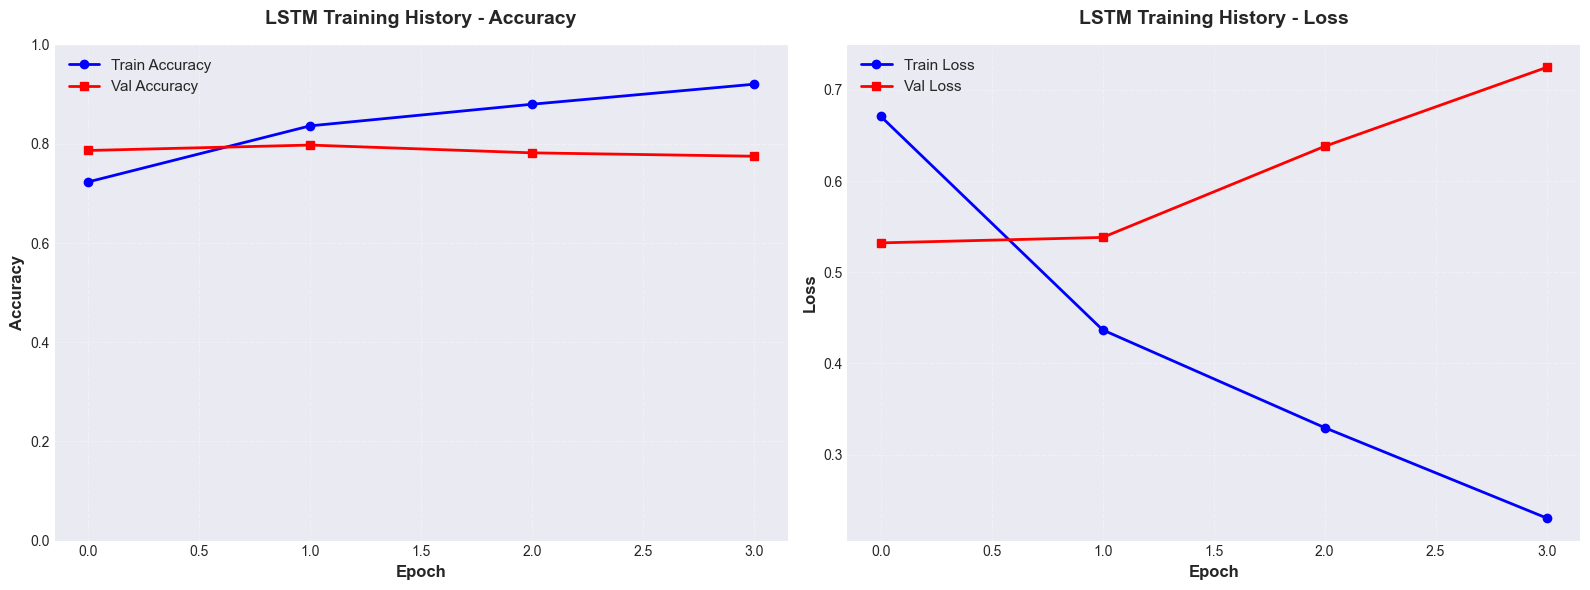


Final Training Metrics:
  Best Train Accuracy: 0.9206
  Best Val Accuracy: 0.7978
  Final Train Loss: 0.2305
  Final Val Loss: 0.7248


In [22]:
# Plot LSTM training history
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot training & validation accuracy
axes[0].plot(history.history['accuracy'], 'b-', label='Train Accuracy', linewidth=2, marker='o')
axes[0].plot(history.history['val_accuracy'], 'r-', label='Val Accuracy', linewidth=2, marker='s')
axes[0].set_title('LSTM Training History - Accuracy', fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3, linestyle='--')
axes[0].set_ylim([0, 1])

# Plot training & validation loss
axes[1].plot(history.history['loss'], 'b-', label='Train Loss', linewidth=2, marker='o')
axes[1].plot(history.history['val_loss'], 'r-', label='Val Loss', linewidth=2, marker='s')
axes[1].set_title('LSTM Training History - Loss', fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('../results/figures/tweets_lstm_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nFinal Training Metrics:")
print(f"  Best Train Accuracy: {max(history.history['accuracy']):.4f}")
print(f"  Best Val Accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"  Final Train Loss: {history.history['loss'][-1]:.4f}")
print(f"  Final Val Loss: {history.history['val_loss'][-1]:.4f}")


## 6.3 Multinomial Naive Bayes (Very Fast Baseline)


In [23]:
print("Training Multinomial Naive Bayes model...")
print("Note: Naive Bayes is extremely fast and works well for text classification!")

# Use CountVectorizer for Naive Bayes (works better than TF-IDF for NB)
nb_vectorizer = CountVectorizer(max_features=10000, ngram_range=(1, 2), min_df=2)
X_train_nb = nb_vectorizer.fit_transform(X_train['text_processed'])
X_val_nb = nb_vectorizer.transform(X_val['text_processed'])
X_test_nb = nb_vectorizer.transform(X_test['text_processed'])

# Train Multinomial Naive Bayes
nb_model = MultinomialNB(alpha=1.0)  # alpha=1.0 for Laplace smoothing

start_time = time.time()
nb_model.fit(X_train_nb, y_train)
training_time_nb = time.time() - start_time

print(f"✓ Model trained in {training_time_nb:.2f} seconds!")

# Predictions
y_train_pred_nb = nb_model.predict(X_train_nb)
y_val_pred_nb = nb_model.predict(X_val_nb)
y_test_pred_nb = nb_model.predict(X_test_nb)

# Metrics
nb_train_acc = accuracy_score(y_train, y_train_pred_nb)
nb_val_acc = accuracy_score(y_val, y_val_pred_nb)
nb_test_acc = accuracy_score(y_test, y_test_pred_nb)

# Test metrics
nb_test_precision_macro, nb_test_recall_macro, nb_test_f1_macro, _ = precision_recall_fscore_support(
    y_test, y_test_pred_nb, average='macro', zero_division=0
)
nb_test_precision_weighted, nb_test_recall_weighted, nb_test_f1_weighted, _ = precision_recall_fscore_support(
    y_test, y_test_pred_nb, average='weighted', zero_division=0
)

# Train metrics
nb_train_precision_macro, nb_train_recall_macro, nb_train_f1_macro, _ = precision_recall_fscore_support(
    y_train, y_train_pred_nb, average='macro', zero_division=0
)
nb_train_precision_weighted, nb_train_recall_weighted, nb_train_f1_weighted, _ = precision_recall_fscore_support(
    y_train, y_train_pred_nb, average='weighted', zero_division=0
)

# Validation metrics
nb_val_precision_macro, nb_val_recall_macro, nb_val_f1_macro, _ = precision_recall_fscore_support(
    y_val, y_val_pred_nb, average='macro', zero_division=0
)
nb_val_precision_weighted, nb_val_recall_weighted, nb_val_f1_weighted, _ = precision_recall_fscore_support(
    y_val, y_val_pred_nb, average='weighted', zero_division=0
)

print(f"\n✓ Multinomial Naive Bayes Model Trained and Evaluated!")
print(f"  Training time: {training_time_nb:.2f} seconds")
print(f"  Train Accuracy: {nb_train_acc:.4f}")
print(f"  Val Accuracy:   {nb_val_acc:.4f}")
print(f"  Test Accuracy:  {nb_test_acc:.4f}")
print(f"  Test Precision (macro): {nb_test_precision_macro:.4f}")
print(f"  Test Recall (macro):    {nb_test_recall_macro:.4f}")
print(f"  Test F1-Score (macro):  {nb_test_f1_macro:.4f}")
print(f"  Test F1-Score (weighted): {nb_test_f1_weighted:.4f}")


Training Multinomial Naive Bayes model...
Note: Naive Bayes is extremely fast and works well for text classification!


✓ Model trained in 0.00 seconds!

✓ Multinomial Naive Bayes Model Trained and Evaluated!
  Training time: 0.00 seconds
  Train Accuracy: 0.8586
  Val Accuracy:   0.7637
  Test Accuracy:  0.7848
  Test Precision (macro): 0.7343
  Test Recall (macro):    0.7092
  Test F1-Score (macro):  0.7201
  Test F1-Score (weighted): 0.7796


In [24]:
# Show detailed classification report for Naive Bayes
print("\nDetailed Classification Report - Multinomial Naive Bayes:")
print("="*80)
print(classification_report(y_test, y_test_pred_nb,
                            target_names=['Negative', 'Neutral', 'Positive'],
                            digits=4))
print("="*80)



Detailed Classification Report - Multinomial Naive Bayes:
              precision    recall  f1-score   support

    Negative     0.8381    0.8911    0.8638       918
     Neutral     0.6260    0.5290    0.5734       310
    Positive     0.7389    0.7076    0.7229       236

    accuracy                         0.7848      1464
   macro avg     0.7343    0.7092    0.7201      1464
weighted avg     0.7772    0.7848    0.7796      1464



## 6.4 GloVe + LSTM (Pre-trained Word Embeddings)


In [25]:
print("Training GloVe + LSTM model...")
print("Note: GloVe uses pre-trained word embeddings trained on large corpora!")
print("      This captures semantic relationships between words.\n")

import urllib.request
import zipfile
import gzip
import requests
from tqdm.auto import tqdm

# Download GloVe embeddings (using Twitter 50d for faster download - optimized for tweets)
# Twitter GloVe is smaller and more relevant for tweet sentiment analysis
glove_file = "glove.twitter.27B.50d.txt"
glove_url = "https://huggingface.co/stanfordnlp/glove/resolve/main/glove.twitter.27B.zip"
glove_zip_path = "glove.twitter.27B.zip"
embedding_dim_glove = 50

# Alternative: Use 6B 50d (smaller file)
glove_file_alt = "glove.6B.50d.txt"
glove_url_alt = "https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip"
glove_zip_path_alt = "glove.6B.zip"

# Check if GloVe file exists, if not download it
use_twitter_glove = False

if os.path.exists(glove_file):
    print(f"✓ Twitter GloVe embeddings file already exists!")
    use_twitter_glove = True
elif os.path.exists(glove_file_alt):
    print(f"✓ GloVe 6B embeddings file already exists!")
    glove_file = glove_file_alt
else:
    print("Downloading GloVe embeddings (this may take a few minutes)...")
    print("Using GloVe 6B 50d embeddings for faster download...")
    
    try:
        # Download with progress bar using requests
        response = requests.get(glove_url_alt, stream=True, timeout=300)
        total_size = int(response.headers.get('content-length', 0))
        
        with open(glove_zip_path_alt, 'wb') as f:
            if total_size == 0:
                f.write(response.content)
            else:
                downloaded = 0
                for data in response.iter_content(chunk_size=1024*1024):  # 1MB chunks
                    downloaded += len(data)
                    f.write(data)
                    progress = (downloaded / total_size) * 100
                    print(f"\rDownloading: {progress:.1f}% ({downloaded / (1024*1024):.1f} MB)", end='')
        
        print("\n✓ Download complete! Extracting...")
        with zipfile.ZipFile(glove_zip_path_alt, 'r') as zip_ref:
            zip_ref.extract(glove_file_alt)
        print("✓ Extraction complete!")
        glove_file = glove_file_alt
        
        # Clean up zip file
        os.remove(glove_zip_path_alt)
        
    except Exception as e:
        print(f"\nError downloading GloVe: {e}")
        print("Creating random embeddings instead (for demonstration purposes)...")
        
        # Create random embeddings as fallback
        embeddings_index = {}
        for word, i in lstm_tokenizer.word_index.items():
            if i >= 10000:
                break
            embeddings_index[word] = np.random.uniform(-1, 1, embedding_dim_glove).astype('float32')
        print(f"✓ Created {len(embeddings_index):,} random word vectors (fallback)!")

# Load GloVe embeddings into a dictionary if not already done
if 'embeddings_index' not in dir() or len(embeddings_index) == 0:
    print("\nLoading GloVe embeddings into memory...")
    embeddings_index = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            try:
                coefs = np.asarray(values[1:], dtype='float32')
                if len(coefs) == embedding_dim_glove:
                    embeddings_index[word] = coefs
            except ValueError:
                continue
    
    print(f"✓ Loaded {len(embeddings_index):,} word vectors from GloVe!")


Training GloVe + LSTM model...
Note: GloVe uses pre-trained word embeddings trained on large corpora!
      This captures semantic relationships between words.

✓ GloVe 6B embeddings file already exists!

Loading GloVe embeddings into memory...


✓ Loaded 400,001 word vectors from GloVe!


In [26]:
# Create GloVe tokenizer and sequences (reuse existing tokenizer from LSTM)
# We use the same tokenizer as LSTM to ensure fair comparison
max_words_glove = 10000
max_len_glove = 100

# Use the tokenizer from LSTM section (lstm_tokenizer was already fitted)
# Create embedding matrix for GloVe
vocab_size = min(max_words_glove, len(lstm_tokenizer.word_index) + 1)

# Create embedding matrix
print("Creating embedding matrix...")
embedding_matrix = np.zeros((vocab_size, embedding_dim_glove))
words_found = 0
words_not_found = 0

for word, i in lstm_tokenizer.word_index.items():
    if i >= vocab_size:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        words_found += 1
    else:
        # Words not found in GloVe will have zero vectors (could also use random)
        words_not_found += 1

print(f"✓ Embedding matrix created!")
print(f"  Words found in GloVe: {words_found:,}")
print(f"  Words not found (using zero vectors): {words_not_found:,}")
print(f"  Coverage: {words_found / (words_found + words_not_found) * 100:.2f}%")
print(f"  Embedding matrix shape: {embedding_matrix.shape}")


Creating embedding matrix...
✓ Embedding matrix created!
  Words found in GloVe: 7,581
  Words not found (using zero vectors): 2,418
  Coverage: 75.82%
  Embedding matrix shape: (10000, 50)


In [27]:
# Build GloVe + LSTM model (Fine-tuned)
lstm_units_glove = 64

glove_model = Sequential([
    # Use pre-trained GloVe embeddings - trainable=True to fine-tune for Twitter sentiment
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim_glove,
              weights=[embedding_matrix],
              input_length=max_len_glove,
              trainable=True),  # Fine-tune GloVe embeddings for better performance!
    Dropout(0.3),
    Bidirectional(LSTM(lstm_units_glove, return_sequences=False)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')  # 3 classes: negative, neutral, positive
])

# Compile model
glove_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n✓ GloVe + LSTM Model Architecture:")
glove_model.summary()



✓ GloVe + LSTM Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 500,000 (1.91 MB)

 Trainable params: 500,000 (1.91 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Train GloVe + LSTM model
batch_size_glove = 32
epochs_glove = 10

# Callbacks
early_stopping_glove = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_glove = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=0.0001,
    verbose=1
)

print("\nStarting GloVe + LSTM training...")
start_time_glove = time.time()

# Train the model (reuse padded sequences from LSTM)
history_glove = glove_model.fit(
    X_train_padded, y_train_cat,
    batch_size=batch_size_glove,
    epochs=epochs_glove,
    validation_data=(X_val_padded, y_val_cat),
    callbacks=[early_stopping_glove, reduce_lr_glove],
    verbose=1
)

training_time_glove = time.time() - start_time_glove
print(f"\n✓ GloVe + LSTM training complete in {training_time_glove:.2f} seconds ({training_time_glove/60:.2f} minutes)!")

# Make predictions
y_train_pred_glove_proba = glove_model.predict(X_train_padded, verbose=0)
y_val_pred_glove_proba = glove_model.predict(X_val_padded, verbose=0)
y_test_pred_glove_proba = glove_model.predict(X_test_padded, verbose=0)

# Convert probabilities to class predictions
y_train_pred_glove = np.argmax(y_train_pred_glove_proba, axis=1)
y_val_pred_glove = np.argmax(y_val_pred_glove_proba, axis=1)
y_test_pred_glove = np.argmax(y_test_pred_glove_proba, axis=1)

# Metrics
glove_train_acc = accuracy_score(y_train, y_train_pred_glove)
glove_val_acc = accuracy_score(y_val, y_val_pred_glove)
glove_test_acc = accuracy_score(y_test, y_test_pred_glove)

# Test metrics
glove_test_precision_macro, glove_test_recall_macro, glove_test_f1_macro, _ = precision_recall_fscore_support(
    y_test, y_test_pred_glove, average='macro', zero_division=0
)
glove_test_precision_weighted, glove_test_recall_weighted, glove_test_f1_weighted, _ = precision_recall_fscore_support(
    y_test, y_test_pred_glove, average='weighted', zero_division=0
)

# Train metrics
glove_train_precision_macro, glove_train_recall_macro, glove_train_f1_macro, _ = precision_recall_fscore_support(
    y_train, y_train_pred_glove, average='macro', zero_division=0
)
glove_train_precision_weighted, glove_train_recall_weighted, glove_train_f1_weighted, _ = precision_recall_fscore_support(
    y_train, y_train_pred_glove, average='weighted', zero_division=0
)

# Validation metrics
glove_val_precision_macro, glove_val_recall_macro, glove_val_f1_macro, _ = precision_recall_fscore_support(
    y_val, y_val_pred_glove, average='macro', zero_division=0
)
glove_val_precision_weighted, glove_val_recall_weighted, glove_val_f1_weighted, _ = precision_recall_fscore_support(
    y_val, y_val_pred_glove, average='weighted', zero_division=0
)

print(f"\n✓ GloVe + LSTM Model Trained and Evaluated!")
print(f"  Training time: {training_time_glove:.2f} seconds ({training_time_glove/60:.2f} minutes)")
print(f"  Train Accuracy: {glove_train_acc:.4f}")
print(f"  Val Accuracy:   {glove_val_acc:.4f}")
print(f"  Test Accuracy:  {glove_test_acc:.4f}")
print(f"  Test Precision (macro): {glove_test_precision_macro:.4f}")
print(f"  Test Recall (macro):    {glove_test_recall_macro:.4f}")
print(f"  Test F1-Score (macro):  {glove_test_f1_macro:.4f}")
print(f"  Test F1-Score (weighted): {glove_test_f1_weighted:.4f}")



Starting GloVe + LSTM training...
Epoch 1/10



  1/366 ━━━━━━━━━━━━━━━━━━━━ 11:20 2s/step - accuracy: 0.2188 - loss: 1.2221


  4/366 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.2578 - loss: 1.1657 


  7/366 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.3184 - loss: 1.1255


 10/366 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.3650 - loss: 1.0929


 13/366 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.4028 - loss: 1.0620


 16/366 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.4313 - loss: 1.0402


 19/366 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.4519 - loss: 1.0274


 22/366 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.4681 - loss: 1.0175


 25/366 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.4807 - loss: 1.0095


 28/366 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.4916 - loss: 1.0023


 31/366 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.5011 - loss: 0.9956


 34/366 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.5092 - loss: 0.9898


 37/366 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.5157 - loss: 0.9852


 40/366 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.5214 - loss: 0.9809


 43/366 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.5264 - loss: 0.9772


 46/366 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.5308 - loss: 0.9740


 49/366 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.5346 - loss: 0.9712


 52/366 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.5381 - loss: 0.9682


 55/366 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.5413 - loss: 0.9655


 58/366 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.5444 - loss: 0.9627


 61/366 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.5473 - loss: 0.9602


 64/366 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.5499 - loss: 0.9577


 67/366 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.5525 - loss: 0.9552


 70/366 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.5548 - loss: 0.9529


 73/366 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.5570 - loss: 0.9508


 76/366 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.5591 - loss: 0.9486


 79/366 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.5611 - loss: 0.9464


 82/366 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.5630 - loss: 0.9443


 85/366 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.5648 - loss: 0.9423


 88/366 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.5666 - loss: 0.9403


 91/366 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.5682 - loss: 0.9384


 94/366 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.5698 - loss: 0.9365


 97/366 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.5713 - loss: 0.9347


100/366 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.5729 - loss: 0.9327


103/366 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.5744 - loss: 0.9307


106/366 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.5758 - loss: 0.9288


109/366 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.5773 - loss: 0.9269


112/366 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.5787 - loss: 0.9251


115/366 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.5800 - loss: 0.9233


118/366 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.5813 - loss: 0.9217


121/366 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.5825 - loss: 0.9200


124/366 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5837 - loss: 0.9184


127/366 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5848 - loss: 0.9169


130/366 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5860 - loss: 0.9153


133/366 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5871 - loss: 0.9138


136/366 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5883 - loss: 0.9123


139/366 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5894 - loss: 0.9108


142/366 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5905 - loss: 0.9093


145/366 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5916 - loss: 0.9078


148/366 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5927 - loss: 0.9062


151/366 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5938 - loss: 0.9048


154/366 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5948 - loss: 0.9035


157/366 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5958 - loss: 0.9022


160/366 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5967 - loss: 0.9009


163/366 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5976 - loss: 0.8996


166/366 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5985 - loss: 0.8984


169/366 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5994 - loss: 0.8971


172/366 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.6003 - loss: 0.8959


175/366 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.6011 - loss: 0.8947


178/366 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6020 - loss: 0.8935


181/366 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6029 - loss: 0.8923


183/366 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6034 - loss: 0.8915


186/366 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6043 - loss: 0.8903


188/366 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6048 - loss: 0.8895


191/366 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6056 - loss: 0.8884


193/366 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6062 - loss: 0.8876


196/366 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6070 - loss: 0.8864


198/366 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6075 - loss: 0.8857


201/366 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6083 - loss: 0.8846


203/366 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6088 - loss: 0.8838


205/366 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6093 - loss: 0.8831


207/366 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6098 - loss: 0.8823


209/366 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6103 - loss: 0.8816


211/366 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6108 - loss: 0.8809


213/366 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6113 - loss: 0.8802


215/366 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6117 - loss: 0.8794


217/366 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6122 - loss: 0.8787


219/366 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6127 - loss: 0.8780


221/366 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6131 - loss: 0.8773


223/366 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6136 - loss: 0.8766


225/366 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6140 - loss: 0.8759


227/366 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6145 - loss: 0.8752


229/366 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6149 - loss: 0.8745


231/366 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6154 - loss: 0.8738


233/366 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6158 - loss: 0.8731


235/366 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6162 - loss: 0.8724


237/366 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6167 - loss: 0.8717


239/366 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6171 - loss: 0.8710


241/366 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6175 - loss: 0.8703


243/366 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6180 - loss: 0.8696


245/366 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6184 - loss: 0.8690


247/366 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6188 - loss: 0.8683


249/366 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6192 - loss: 0.8676


251/366 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6197 - loss: 0.8670


253/366 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6201 - loss: 0.8663


255/366 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6205 - loss: 0.8657


257/366 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6209 - loss: 0.8650


259/366 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6213 - loss: 0.8643


261/366 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6217 - loss: 0.8637


263/366 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6221 - loss: 0.8630


265/366 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6225 - loss: 0.8623


267/366 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6230 - loss: 0.8617


269/366 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6234 - loss: 0.8610


271/366 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6238 - loss: 0.8603


273/366 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6242 - loss: 0.8596


275/366 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6246 - loss: 0.8590


277/366 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6250 - loss: 0.8583


279/366 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6254 - loss: 0.8576


281/366 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6257 - loss: 0.8570


283/366 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6261 - loss: 0.8563


285/366 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6265 - loss: 0.8557


287/366 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6269 - loss: 0.8550


289/366 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6273 - loss: 0.8544


291/366 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6277 - loss: 0.8537


293/366 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6281 - loss: 0.8531


295/366 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6284 - loss: 0.8524


297/366 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6288 - loss: 0.8517


299/366 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6292 - loss: 0.8511


301/366 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6296 - loss: 0.8504


303/366 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6300 - loss: 0.8498


305/366 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6303 - loss: 0.8491


307/366 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6307 - loss: 0.8485


309/366 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6311 - loss: 0.8479


311/366 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6315 - loss: 0.8472


314/366 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6320 - loss: 0.8463


316/366 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6324 - loss: 0.8456


318/366 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6327 - loss: 0.8450


320/366 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6331 - loss: 0.8444


322/366 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6335 - loss: 0.8437


324/366 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6338 - loss: 0.8431


326/366 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6342 - loss: 0.8425


328/366 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6346 - loss: 0.8419


330/366 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6349 - loss: 0.8412


332/366 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6353 - loss: 0.8406


334/366 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6356 - loss: 0.8400


336/366 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6360 - loss: 0.8394


338/366 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6363 - loss: 0.8388


340/366 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6367 - loss: 0.8382


342/366 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6370 - loss: 0.8376


344/366 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6374 - loss: 0.8370


346/366 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6377 - loss: 0.8364


348/366 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6380 - loss: 0.8358


350/366 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6384 - loss: 0.8352


352/366 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6387 - loss: 0.8346


354/366 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6390 - loss: 0.8341


356/366 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6394 - loss: 0.8335


358/366 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6397 - loss: 0.8329


360/366 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6400 - loss: 0.8323


362/366 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6403 - loss: 0.8318


364/366 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6407 - loss: 0.8312


366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6410 - loss: 0.8307


366/366 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.6991 - loss: 0.7292 - val_accuracy: 0.7643 - val_loss: 0.5845 - learning_rate: 0.0010


Epoch 2/10



  1/366 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.8750 - loss: 0.3836


  4/366 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.8444 - loss: 0.4770 


  7/366 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8157 - loss: 0.5385


 10/366 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8050 - loss: 0.5655


 13/366 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8013 - loss: 0.5739


 16/366 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.7996 - loss: 0.5779


 19/366 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.7961 - loss: 0.5852


 21/366 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.7940 - loss: 0.5889


 23/366 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.7923 - loss: 0.5914


 25/366 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.7904 - loss: 0.5938


 27/366 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.7882 - loss: 0.5961


 29/366 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.7859 - loss: 0.5984


 31/366 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.7842 - loss: 0.6001


 33/366 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.7826 - loss: 0.6016


 35/366 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.7810 - loss: 0.6038


 37/366 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.7796 - loss: 0.6059


 39/366 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.7783 - loss: 0.6081


 41/366 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.7771 - loss: 0.6100


 43/366 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.7760 - loss: 0.6117


 45/366 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.7751 - loss: 0.6130


 47/366 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.7742 - loss: 0.6142


 49/366 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.7735 - loss: 0.6152


 51/366 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.7730 - loss: 0.6160


 53/366 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7725 - loss: 0.6167


 55/366 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7721 - loss: 0.6173


 57/366 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7718 - loss: 0.6178


 59/366 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7715 - loss: 0.6183


 61/366 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.7711 - loss: 0.6187


 63/366 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.7708 - loss: 0.6192


 65/366 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7705 - loss: 0.6194


 67/366 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7702 - loss: 0.6198


 69/366 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7699 - loss: 0.6202


 71/366 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7697 - loss: 0.6206


 73/366 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7694 - loss: 0.6210


 75/366 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7691 - loss: 0.6214


 77/366 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7689 - loss: 0.6216


 79/366 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7688 - loss: 0.6218


 81/366 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7687 - loss: 0.6220


 83/366 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7686 - loss: 0.6222


 85/366 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.7684 - loss: 0.6224


 87/366 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.7683 - loss: 0.6226


 89/366 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.7681 - loss: 0.6228


 91/366 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.7679 - loss: 0.6229


 93/366 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.7678 - loss: 0.6230


 95/366 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.7676 - loss: 0.6230


 97/366 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.7675 - loss: 0.6230


 99/366 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.7674 - loss: 0.6230


101/366 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.7674 - loss: 0.6229


103/366 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.7673 - loss: 0.6228


105/366 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.7672 - loss: 0.6227


107/366 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.7672 - loss: 0.6226


109/366 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.7671 - loss: 0.6225


111/366 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.7670 - loss: 0.6224


113/366 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.7670 - loss: 0.6223


115/366 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.7669 - loss: 0.6221


117/366 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7669 - loss: 0.6220


119/366 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7669 - loss: 0.6219


121/366 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7668 - loss: 0.6218


123/366 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7668 - loss: 0.6217


125/366 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7668 - loss: 0.6216


127/366 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7667 - loss: 0.6215


129/366 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7667 - loss: 0.6214


131/366 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7667 - loss: 0.6213


133/366 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7667 - loss: 0.6212


135/366 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7667 - loss: 0.6210


137/366 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7667 - loss: 0.6209


139/366 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7667 - loss: 0.6208


141/366 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7667 - loss: 0.6206


143/366 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7667 - loss: 0.6204


145/366 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7667 - loss: 0.6202


147/366 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7667 - loss: 0.6200


149/366 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.7667 - loss: 0.6198


151/366 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.7667 - loss: 0.6197


153/366 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.7667 - loss: 0.6195


155/366 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.7667 - loss: 0.6194


157/366 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.7667 - loss: 0.6193


159/366 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.7667 - loss: 0.6191


161/366 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.7667 - loss: 0.6190


163/366 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.7667 - loss: 0.6188


165/366 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.7667 - loss: 0.6187


167/366 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.7667 - loss: 0.6185


169/366 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.7667 - loss: 0.6184


171/366 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.7667 - loss: 0.6182


173/366 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.7668 - loss: 0.6180


176/366 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.7668 - loss: 0.6177


178/366 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.7668 - loss: 0.6175


181/366 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.7669 - loss: 0.6173


183/366 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.7669 - loss: 0.6171


185/366 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7670 - loss: 0.6169


188/366 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7670 - loss: 0.6166


191/366 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7671 - loss: 0.6163


193/366 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7672 - loss: 0.6161


195/366 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7672 - loss: 0.6159


197/366 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7672 - loss: 0.6157


199/366 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7673 - loss: 0.6155


201/366 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7673 - loss: 0.6153


204/366 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7673 - loss: 0.6150


206/366 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7674 - loss: 0.6148


208/366 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7674 - loss: 0.6146


210/366 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7674 - loss: 0.6145


212/366 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7674 - loss: 0.6143


214/366 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7674 - loss: 0.6141


216/366 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7674 - loss: 0.6139


218/366 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.7674 - loss: 0.6138


221/366 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7675 - loss: 0.6135


223/366 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7675 - loss: 0.6134


225/366 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7675 - loss: 0.6132


227/366 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7675 - loss: 0.6130


229/366 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7675 - loss: 0.6129


231/366 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7676 - loss: 0.6127


233/366 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7676 - loss: 0.6125


235/366 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7676 - loss: 0.6123


237/366 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7677 - loss: 0.6121


239/366 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7677 - loss: 0.6119


241/366 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7677 - loss: 0.6118


243/366 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7678 - loss: 0.6116


245/366 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7678 - loss: 0.6114


247/366 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7678 - loss: 0.6112


249/366 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7679 - loss: 0.6110


251/366 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7679 - loss: 0.6108


254/366 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.7679 - loss: 0.6105


256/366 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7680 - loss: 0.6103


258/366 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7680 - loss: 0.6101


260/366 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7680 - loss: 0.6099


262/366 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7681 - loss: 0.6097


264/366 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7681 - loss: 0.6095


266/366 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7682 - loss: 0.6093


268/366 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7682 - loss: 0.6090


270/366 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7683 - loss: 0.6088


272/366 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7683 - loss: 0.6086


274/366 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7683 - loss: 0.6084


277/366 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7684 - loss: 0.6081


280/366 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7685 - loss: 0.6078


282/366 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7685 - loss: 0.6076


284/366 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7686 - loss: 0.6074


286/366 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7686 - loss: 0.6072


288/366 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7687 - loss: 0.6070


290/366 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7687 - loss: 0.6067


292/366 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7688 - loss: 0.6065


294/366 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7688 - loss: 0.6063


296/366 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7689 - loss: 0.6061


298/366 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7689 - loss: 0.6059


300/366 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7690 - loss: 0.6057


302/366 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7691 - loss: 0.6055


304/366 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7691 - loss: 0.6053


306/366 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7691 - loss: 0.6051


309/366 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7692 - loss: 0.6048


311/366 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7693 - loss: 0.6045


314/366 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7694 - loss: 0.6042


316/366 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7694 - loss: 0.6040


318/366 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7695 - loss: 0.6038


320/366 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7695 - loss: 0.6036


323/366 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7696 - loss: 0.6033


325/366 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7696 - loss: 0.6031


327/366 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7697 - loss: 0.6029


329/366 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7698 - loss: 0.6027


331/366 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7698 - loss: 0.6025


333/366 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7699 - loss: 0.6023


335/366 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7699 - loss: 0.6020


337/366 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7700 - loss: 0.6018


339/366 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7700 - loss: 0.6016


341/366 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7701 - loss: 0.6014


343/366 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7701 - loss: 0.6012


345/366 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7702 - loss: 0.6010


347/366 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7703 - loss: 0.6008


349/366 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7703 - loss: 0.6006


351/366 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7704 - loss: 0.6004


353/366 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7704 - loss: 0.6002


355/366 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7705 - loss: 0.6000


357/366 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7705 - loss: 0.5998


359/366 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7706 - loss: 0.5996


361/366 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7706 - loss: 0.5995


364/366 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7707 - loss: 0.5992


366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7708 - loss: 0.5990


366/366 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.7808 - loss: 0.5651 - val_accuracy: 0.7753 - val_loss: 0.5293 - learning_rate: 0.0010


Epoch 3/10



  1/366 ━━━━━━━━━━━━━━━━━━━━ 17s 47ms/step - accuracy: 0.8438 - loss: 0.3634


  4/366 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8158 - loss: 0.4164 


  7/366 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8084 - loss: 0.4519


 10/366 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8035 - loss: 0.4701


 13/366 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8034 - loss: 0.4772


 16/366 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8049 - loss: 0.4825


 19/366 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8046 - loss: 0.4896


 22/366 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8046 - loss: 0.4927


 24/366 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8043 - loss: 0.4947


 26/366 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8040 - loss: 0.4963


 28/366 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8037 - loss: 0.4983


 30/366 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8034 - loss: 0.5000


 32/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8032 - loss: 0.5016


 34/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8026 - loss: 0.5036


 36/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8019 - loss: 0.5057


 38/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8011 - loss: 0.5080


 41/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8000 - loss: 0.5110


 43/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.7994 - loss: 0.5127


 45/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.7990 - loss: 0.5139


 47/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.7987 - loss: 0.5151


 49/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.7985 - loss: 0.5160


 51/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.7983 - loss: 0.5168


 54/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.7979 - loss: 0.5181


 56/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.7976 - loss: 0.5188


 59/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.7971 - loss: 0.5198


 61/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.7967 - loss: 0.5204


 63/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.7964 - loss: 0.5210


 65/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.7961 - loss: 0.5215


 67/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.7959 - loss: 0.5220


 69/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.7956 - loss: 0.5226


 71/366 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.7954 - loss: 0.5231


 74/366 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.7951 - loss: 0.5241


 76/366 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.7949 - loss: 0.5246


 78/366 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.7948 - loss: 0.5250


 81/366 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.7947 - loss: 0.5255


 83/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7946 - loss: 0.5260


 86/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7945 - loss: 0.5265


 89/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7943 - loss: 0.5270


 91/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7941 - loss: 0.5272


 94/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7940 - loss: 0.5276


 96/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7939 - loss: 0.5279


 98/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7939 - loss: 0.5280


101/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7938 - loss: 0.5282


103/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7938 - loss: 0.5283


106/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7937 - loss: 0.5285


108/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7937 - loss: 0.5286


110/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7937 - loss: 0.5286


112/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7937 - loss: 0.5287


114/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7937 - loss: 0.5287


116/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7937 - loss: 0.5287


118/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7937 - loss: 0.5287


120/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7937 - loss: 0.5287


122/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7936 - loss: 0.5288


124/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7936 - loss: 0.5289


126/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7936 - loss: 0.5289


129/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7935 - loss: 0.5290


131/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7935 - loss: 0.5291


133/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7934 - loss: 0.5291


135/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7934 - loss: 0.5292


137/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7934 - loss: 0.5292


139/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7934 - loss: 0.5292


141/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7934 - loss: 0.5291


143/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7935 - loss: 0.5291


145/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7935 - loss: 0.5290


148/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7935 - loss: 0.5289


150/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7936 - loss: 0.5289


153/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7936 - loss: 0.5289


155/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7936 - loss: 0.5288


157/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7936 - loss: 0.5288


159/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7936 - loss: 0.5288


161/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7937 - loss: 0.5288


163/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7937 - loss: 0.5287


165/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7937 - loss: 0.5287


167/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7937 - loss: 0.5287


169/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7937 - loss: 0.5286


171/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7937 - loss: 0.5286


173/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7938 - loss: 0.5285


175/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7938 - loss: 0.5284


177/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7938 - loss: 0.5284


179/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7938 - loss: 0.5283


181/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7938 - loss: 0.5282


183/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7939 - loss: 0.5281


185/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7939 - loss: 0.5280


188/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7940 - loss: 0.5279


190/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7940 - loss: 0.5278


193/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7941 - loss: 0.5276


195/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7941 - loss: 0.5275


197/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7942 - loss: 0.5274


199/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7942 - loss: 0.5273


201/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7943 - loss: 0.5272


204/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7944 - loss: 0.5270


206/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7944 - loss: 0.5269


208/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7945 - loss: 0.5268


210/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7945 - loss: 0.5267


212/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7945 - loss: 0.5266


214/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7946 - loss: 0.5265


217/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7947 - loss: 0.5263


220/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7947 - loss: 0.5262


223/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7948 - loss: 0.5260


225/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7948 - loss: 0.5259


228/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7949 - loss: 0.5258


230/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7950 - loss: 0.5257


232/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7950 - loss: 0.5255


234/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7951 - loss: 0.5254


236/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7951 - loss: 0.5253


238/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7952 - loss: 0.5252


240/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7952 - loss: 0.5250


242/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7953 - loss: 0.5249


244/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7953 - loss: 0.5248


246/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.7954 - loss: 0.5247


248/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7954 - loss: 0.5246


250/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7955 - loss: 0.5244


252/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7955 - loss: 0.5243


255/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7956 - loss: 0.5241


257/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7956 - loss: 0.5240


259/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7957 - loss: 0.5239


261/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7957 - loss: 0.5238


263/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7957 - loss: 0.5236


265/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7958 - loss: 0.5235


268/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7959 - loss: 0.5233


271/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7959 - loss: 0.5231


273/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7960 - loss: 0.5229


275/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7960 - loss: 0.5228


277/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7961 - loss: 0.5227


279/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7961 - loss: 0.5225


281/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7962 - loss: 0.5224


283/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7962 - loss: 0.5223


285/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7962 - loss: 0.5221


287/366 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7963 - loss: 0.5220


289/366 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7963 - loss: 0.5218


291/366 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7964 - loss: 0.5217


293/366 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7964 - loss: 0.5215


295/366 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7965 - loss: 0.5214


297/366 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7965 - loss: 0.5212


299/366 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7966 - loss: 0.5211


301/366 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7966 - loss: 0.5209


303/366 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7967 - loss: 0.5208


306/366 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7967 - loss: 0.5206


308/366 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7968 - loss: 0.5204


311/366 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7968 - loss: 0.5202


313/366 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7969 - loss: 0.5201


315/366 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7969 - loss: 0.5200


317/366 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7969 - loss: 0.5198


319/366 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7970 - loss: 0.5197


321/366 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7970 - loss: 0.5196


323/366 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7970 - loss: 0.5194


325/366 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7971 - loss: 0.5193


327/366 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7971 - loss: 0.5192


329/366 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7972 - loss: 0.5190


331/366 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7972 - loss: 0.5189


333/366 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7972 - loss: 0.5187


335/366 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7973 - loss: 0.5186


337/366 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7973 - loss: 0.5185


340/366 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7974 - loss: 0.5183


343/366 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7974 - loss: 0.5181


345/366 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7975 - loss: 0.5179


348/366 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7976 - loss: 0.5177


350/366 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7976 - loss: 0.5176


352/366 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7976 - loss: 0.5175


354/366 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7977 - loss: 0.5173


356/366 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7977 - loss: 0.5172


358/366 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7978 - loss: 0.5171


360/366 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7978 - loss: 0.5170


362/366 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7979 - loss: 0.5168


364/366 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7979 - loss: 0.5167


366/366 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.8055 - loss: 0.4946 - val_accuracy: 0.7992 - val_loss: 0.5079 - learning_rate: 0.0010


Epoch 4/10



  1/366 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.8438 - loss: 0.3970


  4/366 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.8496 - loss: 0.4100 


  7/366 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.8396 - loss: 0.4332


 10/366 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.8322 - loss: 0.4513


 13/366 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.8308 - loss: 0.4576


 16/366 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8311 - loss: 0.4623


 19/366 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.8308 - loss: 0.4670


 22/366 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.8307 - loss: 0.4683


 24/366 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.8303 - loss: 0.4694


 27/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8297 - loss: 0.4705


 30/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8292 - loss: 0.4720


 33/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8289 - loss: 0.4726


 36/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8282 - loss: 0.4737


 39/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8274 - loss: 0.4750


 42/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8266 - loss: 0.4758


 44/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8261 - loss: 0.4762


 47/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8253 - loss: 0.4768


 49/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8249 - loss: 0.4769


 52/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8243 - loss: 0.4768


 55/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8237 - loss: 0.4767


 58/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8232 - loss: 0.4766


 61/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8227 - loss: 0.4765


 64/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8222 - loss: 0.4765


 67/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8218 - loss: 0.4764


 70/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8215 - loss: 0.4763


 73/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8212 - loss: 0.4763


 76/366 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8209 - loss: 0.4763


 78/366 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8208 - loss: 0.4762


 81/366 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8207 - loss: 0.4761


 84/366 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8206 - loss: 0.4760


 87/366 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8206 - loss: 0.4760


 89/366 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8205 - loss: 0.4760


 92/366 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8204 - loss: 0.4760


 95/366 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8203 - loss: 0.4761


 98/366 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8203 - loss: 0.4761


101/366 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8203 - loss: 0.4760


103/366 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8202 - loss: 0.4760


105/366 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8202 - loss: 0.4760


107/366 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8202 - loss: 0.4759


109/366 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8202 - loss: 0.4759


111/366 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8201 - loss: 0.4758


113/366 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8201 - loss: 0.4757


115/366 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8201 - loss: 0.4756


117/366 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8201 - loss: 0.4755


119/366 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8201 - loss: 0.4754


121/366 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8201 - loss: 0.4754


123/366 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8201 - loss: 0.4753


125/366 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8200 - loss: 0.4753


127/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8200 - loss: 0.4752


129/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8200 - loss: 0.4752


131/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8199 - loss: 0.4752


134/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8199 - loss: 0.4752


136/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8199 - loss: 0.4751


139/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8199 - loss: 0.4750


142/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8199 - loss: 0.4749


144/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8199 - loss: 0.4748


146/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8200 - loss: 0.4746


148/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8200 - loss: 0.4745


150/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8200 - loss: 0.4744


152/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8200 - loss: 0.4744


154/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8200 - loss: 0.4743


156/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8200 - loss: 0.4742


159/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8199 - loss: 0.4741


161/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8199 - loss: 0.4741


163/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8199 - loss: 0.4740


165/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8199 - loss: 0.4739


167/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8199 - loss: 0.4738


170/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8198 - loss: 0.4737


172/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8198 - loss: 0.4736


175/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8198 - loss: 0.4735


177/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8198 - loss: 0.4734


179/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8198 - loss: 0.4733


181/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8198 - loss: 0.4732


184/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8198 - loss: 0.4730


186/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8198 - loss: 0.4729


189/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8198 - loss: 0.4727


191/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8198 - loss: 0.4726


193/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8198 - loss: 0.4725


195/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8198 - loss: 0.4724


197/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8198 - loss: 0.4723


199/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8198 - loss: 0.4722


202/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8198 - loss: 0.4721


204/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8198 - loss: 0.4720


206/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8198 - loss: 0.4719


208/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8198 - loss: 0.4718


210/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8198 - loss: 0.4717


212/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8198 - loss: 0.4716


214/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8198 - loss: 0.4716


216/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8198 - loss: 0.4715


218/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8198 - loss: 0.4714


220/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8198 - loss: 0.4713


222/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8198 - loss: 0.4713


224/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8198 - loss: 0.4712


226/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8198 - loss: 0.4711


228/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8198 - loss: 0.4711


230/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8198 - loss: 0.4710


232/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8198 - loss: 0.4709


234/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8198 - loss: 0.4708


236/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8198 - loss: 0.4707


238/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8199 - loss: 0.4706


240/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8199 - loss: 0.4705


242/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8199 - loss: 0.4704


245/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8199 - loss: 0.4703


247/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8199 - loss: 0.4703


249/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8200 - loss: 0.4702


251/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8200 - loss: 0.4701


253/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8200 - loss: 0.4700


256/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8200 - loss: 0.4699


258/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8200 - loss: 0.4699


260/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8200 - loss: 0.4698


262/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8201 - loss: 0.4697


265/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8201 - loss: 0.4696


267/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8201 - loss: 0.4695


270/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8201 - loss: 0.4694


272/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8202 - loss: 0.4693


274/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8202 - loss: 0.4692


277/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8202 - loss: 0.4691


279/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8202 - loss: 0.4691


281/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8202 - loss: 0.4690


284/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8203 - loss: 0.4689


286/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8203 - loss: 0.4688


288/366 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8203 - loss: 0.4688


290/366 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8203 - loss: 0.4687


292/366 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8203 - loss: 0.4686


295/366 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8204 - loss: 0.4685


297/366 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8204 - loss: 0.4684


299/366 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8204 - loss: 0.4683


301/366 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8204 - loss: 0.4682


304/366 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8204 - loss: 0.4681


306/366 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8205 - loss: 0.4680


308/366 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8205 - loss: 0.4680


310/366 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8205 - loss: 0.4679


313/366 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8205 - loss: 0.4678


315/366 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8205 - loss: 0.4677


317/366 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8205 - loss: 0.4676


319/366 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8206 - loss: 0.4675


321/366 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8206 - loss: 0.4674


323/366 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8206 - loss: 0.4674


325/366 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8206 - loss: 0.4673


327/366 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8206 - loss: 0.4672


329/366 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8207 - loss: 0.4671


331/366 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8207 - loss: 0.4670


333/366 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8207 - loss: 0.4669


335/366 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8207 - loss: 0.4669


337/366 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8208 - loss: 0.4668


339/366 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8208 - loss: 0.4667


342/366 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8208 - loss: 0.4666


344/366 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8208 - loss: 0.4665


346/366 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8208 - loss: 0.4664


348/366 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8209 - loss: 0.4663


351/366 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8209 - loss: 0.4662


354/366 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8209 - loss: 0.4661


356/366 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8210 - loss: 0.4660


358/366 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8210 - loss: 0.4659


360/366 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8210 - loss: 0.4658


362/366 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8210 - loss: 0.4657


365/366 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8210 - loss: 0.4656


366/366 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.8245 - loss: 0.4507 - val_accuracy: 0.7971 - val_loss: 0.5077 - learning_rate: 0.0010


Epoch 5/10



  1/366 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.8438 - loss: 0.3642


  4/366 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.8496 - loss: 0.3620 


  7/366 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8430 - loss: 0.3833


 10/366 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8402 - loss: 0.3943


 13/366 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8395 - loss: 0.3987


 16/366 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8394 - loss: 0.4037


 19/366 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8395 - loss: 0.4074


 22/366 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8406 - loss: 0.4077


 25/366 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8410 - loss: 0.4084


 28/366 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8415 - loss: 0.4093


 31/366 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8415 - loss: 0.4109


 34/366 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8410 - loss: 0.4131


 37/366 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8401 - loss: 0.4157


 40/366 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8393 - loss: 0.4184


 43/366 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8388 - loss: 0.4205


 45/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8385 - loss: 0.4216


 47/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8383 - loss: 0.4226


 49/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8381 - loss: 0.4233


 51/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8380 - loss: 0.4239


 54/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8377 - loss: 0.4246


 56/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8375 - loss: 0.4252


 59/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8372 - loss: 0.4260


 61/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8370 - loss: 0.4265


 63/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8368 - loss: 0.4269


 66/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8366 - loss: 0.4274


 68/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8365 - loss: 0.4277


 70/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8364 - loss: 0.4280


 73/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8362 - loss: 0.4285


 75/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8360 - loss: 0.4288


 77/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8359 - loss: 0.4290


 79/366 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8358 - loss: 0.4292


 81/366 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8358 - loss: 0.4295


 84/366 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8356 - loss: 0.4299


 86/366 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8356 - loss: 0.4302


 88/366 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8355 - loss: 0.4304


 90/366 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8355 - loss: 0.4306


 92/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8355 - loss: 0.4308


 94/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8355 - loss: 0.4310


 96/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8355 - loss: 0.4312


 98/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8355 - loss: 0.4314


100/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8355 - loss: 0.4315


102/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8355 - loss: 0.4317


104/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8355 - loss: 0.4318


106/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8355 - loss: 0.4319


109/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8355 - loss: 0.4320


111/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8356 - loss: 0.4320


113/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8356 - loss: 0.4320


115/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8356 - loss: 0.4320


117/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8357 - loss: 0.4321


119/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8357 - loss: 0.4321


121/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8357 - loss: 0.4321


124/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8357 - loss: 0.4322


126/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8357 - loss: 0.4323


128/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8357 - loss: 0.4323


130/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8357 - loss: 0.4324


132/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8356 - loss: 0.4325


135/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8356 - loss: 0.4325


137/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8357 - loss: 0.4325


139/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8357 - loss: 0.4325


141/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8357 - loss: 0.4325


143/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8357 - loss: 0.4324


145/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8358 - loss: 0.4323


147/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8358 - loss: 0.4322


149/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8358 - loss: 0.4322


152/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8359 - loss: 0.4321


154/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8359 - loss: 0.4321


156/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8359 - loss: 0.4321


158/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8360 - loss: 0.4320


160/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8360 - loss: 0.4320


162/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8360 - loss: 0.4320


164/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8360 - loss: 0.4319


166/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8361 - loss: 0.4319


168/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8361 - loss: 0.4318


171/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8361 - loss: 0.4318


173/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8361 - loss: 0.4317


175/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8362 - loss: 0.4317


177/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8362 - loss: 0.4316


179/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8362 - loss: 0.4316


181/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8362 - loss: 0.4315


183/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8362 - loss: 0.4314


185/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8363 - loss: 0.4313


187/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8363 - loss: 0.4312


190/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8363 - loss: 0.4311


193/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8363 - loss: 0.4310


195/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8363 - loss: 0.4310


197/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8363 - loss: 0.4309


199/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8363 - loss: 0.4308


201/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8363 - loss: 0.4307


203/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8363 - loss: 0.4307


205/366 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.8363 - loss: 0.4306


207/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8363 - loss: 0.4305


209/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8363 - loss: 0.4304


212/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8363 - loss: 0.4303


214/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8363 - loss: 0.4302


216/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8363 - loss: 0.4301


218/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8363 - loss: 0.4301


220/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8363 - loss: 0.4300


223/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8363 - loss: 0.4299


225/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8363 - loss: 0.4299


227/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8363 - loss: 0.4298


229/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8363 - loss: 0.4298


231/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8363 - loss: 0.4297


233/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8363 - loss: 0.4296


235/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8363 - loss: 0.4296


237/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8362 - loss: 0.4295


239/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8362 - loss: 0.4294


241/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8362 - loss: 0.4293


243/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8362 - loss: 0.4293


245/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8362 - loss: 0.4292


247/366 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8362 - loss: 0.4292


249/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8362 - loss: 0.4291


251/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8362 - loss: 0.4290


253/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8362 - loss: 0.4290


255/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8362 - loss: 0.4289


257/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8362 - loss: 0.4288


259/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8362 - loss: 0.4288


261/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8362 - loss: 0.4287


263/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8362 - loss: 0.4286


265/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8362 - loss: 0.4285


267/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8362 - loss: 0.4285


269/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8362 - loss: 0.4284


271/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8362 - loss: 0.4283


273/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8362 - loss: 0.4282


275/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8362 - loss: 0.4281


277/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8362 - loss: 0.4281


279/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8362 - loss: 0.4280


281/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8362 - loss: 0.4279


283/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8362 - loss: 0.4279


285/366 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8362 - loss: 0.4278


287/366 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8362 - loss: 0.4277


289/366 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8362 - loss: 0.4276


291/366 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8362 - loss: 0.4276


293/366 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8362 - loss: 0.4275


295/366 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8363 - loss: 0.4274


297/366 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8363 - loss: 0.4273


299/366 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8363 - loss: 0.4273


301/366 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8363 - loss: 0.4272


303/366 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8363 - loss: 0.4271


305/366 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8363 - loss: 0.4271


307/366 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8363 - loss: 0.4270


309/366 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8363 - loss: 0.4269


311/366 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8363 - loss: 0.4269


313/366 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8363 - loss: 0.4268


315/366 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8363 - loss: 0.4267


317/366 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8363 - loss: 0.4267


319/366 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8364 - loss: 0.4266


321/366 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8364 - loss: 0.4265


323/366 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8364 - loss: 0.4265


325/366 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8364 - loss: 0.4264


327/366 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8364 - loss: 0.4263


329/366 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8364 - loss: 0.4263


331/366 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8364 - loss: 0.4262


333/366 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8365 - loss: 0.4261


335/366 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8365 - loss: 0.4260


337/366 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8365 - loss: 0.4260


339/366 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8365 - loss: 0.4259


341/366 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8365 - loss: 0.4258


343/366 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8365 - loss: 0.4257


345/366 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8366 - loss: 0.4257


347/366 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8366 - loss: 0.4256


349/366 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8366 - loss: 0.4255


351/366 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8366 - loss: 0.4255


353/366 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8366 - loss: 0.4254


355/366 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8366 - loss: 0.4253


357/366 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8367 - loss: 0.4253


359/366 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8367 - loss: 0.4252


361/366 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8367 - loss: 0.4251


363/366 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8367 - loss: 0.4250


365/366 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8367 - loss: 0.4250


366/366 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.8402 - loss: 0.4121 - val_accuracy: 0.8067 - val_loss: 0.5166 - learning_rate: 0.0010


Epoch 6/10



  1/366 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.9062 - loss: 0.3555


  4/366 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.8893 - loss: 0.3289 


  7/366 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.8761 - loss: 0.3416


 10/366 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.8723 - loss: 0.3514


 13/366 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.8715 - loss: 0.3539


 16/366 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.8713 - loss: 0.3581


 18/366 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.8712 - loss: 0.3610


 21/366 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.8711 - loss: 0.3630


 24/366 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.8710 - loss: 0.3639


 26/366 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.8705 - loss: 0.3649


 29/366 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.8694 - loss: 0.3669


 32/366 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.8683 - loss: 0.3687


 35/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8670 - loss: 0.3715


 38/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8654 - loss: 0.3746


 41/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8639 - loss: 0.3774


 43/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8630 - loss: 0.3790


 46/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8619 - loss: 0.3812


 49/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8609 - loss: 0.3831


 51/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8602 - loss: 0.3843


 53/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8596 - loss: 0.3854


 56/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8587 - loss: 0.3871


 58/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8581 - loss: 0.3881


 60/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8575 - loss: 0.3891


 62/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8570 - loss: 0.3900


 65/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8563 - loss: 0.3912


 67/366 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.8558 - loss: 0.3919


 70/366 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.8552 - loss: 0.3927


 72/366 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.8548 - loss: 0.3934


 74/366 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.8544 - loss: 0.3940


 76/366 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.8541 - loss: 0.3946


 78/366 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.8538 - loss: 0.3950


 80/366 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.8535 - loss: 0.3955


 82/366 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.8532 - loss: 0.3960


 84/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8530 - loss: 0.3965


 86/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8527 - loss: 0.3969


 88/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8524 - loss: 0.3974


 90/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8522 - loss: 0.3978


 93/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8518 - loss: 0.3985


 95/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8516 - loss: 0.3989


 97/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8514 - loss: 0.3993


 99/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8512 - loss: 0.3996


101/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8510 - loss: 0.3999


103/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8508 - loss: 0.4002


105/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8507 - loss: 0.4005


108/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8505 - loss: 0.4008


110/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8504 - loss: 0.4010


112/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8502 - loss: 0.4011


114/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8501 - loss: 0.4013


116/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8500 - loss: 0.4014


118/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8499 - loss: 0.4015


121/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8498 - loss: 0.4018


123/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8496 - loss: 0.4019


125/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8495 - loss: 0.4020


127/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8494 - loss: 0.4022


129/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8494 - loss: 0.4024


131/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8493 - loss: 0.4025


133/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8492 - loss: 0.4026


135/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8491 - loss: 0.4027


137/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8490 - loss: 0.4028


139/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8489 - loss: 0.4029


141/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8489 - loss: 0.4030


143/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8488 - loss: 0.4030


145/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8488 - loss: 0.4030


147/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8488 - loss: 0.4031


149/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8487 - loss: 0.4031


151/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8487 - loss: 0.4032


153/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8486 - loss: 0.4032


155/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8486 - loss: 0.4032


157/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8486 - loss: 0.4033


159/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8485 - loss: 0.4033


161/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8485 - loss: 0.4033


163/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8485 - loss: 0.4033


165/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8484 - loss: 0.4033


167/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8484 - loss: 0.4033


169/366 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.8484 - loss: 0.4033


171/366 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8484 - loss: 0.4033


173/366 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8483 - loss: 0.4033


175/366 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8483 - loss: 0.4033


177/366 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8483 - loss: 0.4032


179/366 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8483 - loss: 0.4032


181/366 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8482 - loss: 0.4032


183/366 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8482 - loss: 0.4032


185/366 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8482 - loss: 0.4031


187/366 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8482 - loss: 0.4031


189/366 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8481 - loss: 0.4031


191/366 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8481 - loss: 0.4031


193/366 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8481 - loss: 0.4030


195/366 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8481 - loss: 0.4030


197/366 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8480 - loss: 0.4030


199/366 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8480 - loss: 0.4030


201/366 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8480 - loss: 0.4030


203/366 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8480 - loss: 0.4029


205/366 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8480 - loss: 0.4029


207/366 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8480 - loss: 0.4029


209/366 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8479 - loss: 0.4028


211/366 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.8479 - loss: 0.4028


213/366 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8479 - loss: 0.4028


215/366 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8479 - loss: 0.4027


217/366 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8479 - loss: 0.4027


219/366 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8479 - loss: 0.4026


221/366 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8479 - loss: 0.4026


223/366 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8479 - loss: 0.4025


225/366 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8479 - loss: 0.4025


227/366 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8479 - loss: 0.4025


229/366 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8479 - loss: 0.4024


231/366 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8479 - loss: 0.4024


233/366 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8479 - loss: 0.4023


235/366 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8479 - loss: 0.4023


237/366 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8479 - loss: 0.4022


239/366 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8479 - loss: 0.4021


241/366 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8479 - loss: 0.4021


243/366 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8479 - loss: 0.4020


245/366 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8479 - loss: 0.4019


247/366 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8479 - loss: 0.4019


249/366 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8479 - loss: 0.4019


251/366 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8479 - loss: 0.4018


253/366 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8480 - loss: 0.4018


255/366 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8480 - loss: 0.4017


257/366 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8480 - loss: 0.4016


259/366 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8480 - loss: 0.4016


261/366 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8480 - loss: 0.4015


263/366 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8480 - loss: 0.4015


265/366 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8480 - loss: 0.4014


267/366 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8480 - loss: 0.4013


269/366 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8480 - loss: 0.4013


271/366 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8480 - loss: 0.4012


273/366 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8481 - loss: 0.4011


275/366 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8481 - loss: 0.4011


277/366 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8481 - loss: 0.4010


279/366 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8481 - loss: 0.4010


281/366 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8481 - loss: 0.4009


283/366 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8481 - loss: 0.4009


285/366 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8481 - loss: 0.4008


287/366 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8481 - loss: 0.4008


289/366 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8481 - loss: 0.4007


291/366 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8481 - loss: 0.4006


293/366 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8482 - loss: 0.4006


295/366 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8482 - loss: 0.4005


297/366 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8482 - loss: 0.4004


299/366 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8482 - loss: 0.4004


301/366 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8482 - loss: 0.4003


303/366 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8482 - loss: 0.4003


305/366 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8482 - loss: 0.4002


307/366 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8482 - loss: 0.4002


309/366 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8482 - loss: 0.4001


311/366 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8483 - loss: 0.4000


313/366 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8483 - loss: 0.4000


315/366 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8483 - loss: 0.3999


317/366 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8483 - loss: 0.3999


319/366 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8483 - loss: 0.3998


321/366 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8483 - loss: 0.3998


323/366 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8483 - loss: 0.3997


325/366 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8483 - loss: 0.3997


327/366 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8483 - loss: 0.3996


329/366 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8483 - loss: 0.3995


331/366 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8484 - loss: 0.3995


333/366 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8484 - loss: 0.3994


335/366 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8484 - loss: 0.3994


337/366 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8484 - loss: 0.3993


339/366 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8484 - loss: 0.3992


341/366 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8484 - loss: 0.3992


343/366 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8484 - loss: 0.3991


345/366 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8484 - loss: 0.3991


347/366 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8485 - loss: 0.3990


349/366 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8485 - loss: 0.3989


351/366 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8485 - loss: 0.3989


353/366 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8485 - loss: 0.3988


355/366 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8485 - loss: 0.3988


357/366 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8485 - loss: 0.3987


359/366 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8485 - loss: 0.3986


361/366 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8485 - loss: 0.3986


363/366 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8486 - loss: 0.3985


365/366 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8486 - loss: 0.3985


Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.



366/366 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.8509 - loss: 0.3868 - val_accuracy: 0.8019 - val_loss: 0.5134 - learning_rate: 0.0010


Epoch 7/10



  1/366 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.9375 - loss: 0.2283


  4/366 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.9290 - loss: 0.2582 


  7/366 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.9068 - loss: 0.2978


 10/366 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8979 - loss: 0.3136


 13/366 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8954 - loss: 0.3185


 16/366 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.8924 - loss: 0.3261


 19/366 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8891 - loss: 0.3329


 22/366 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8870 - loss: 0.3360


 25/366 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8848 - loss: 0.3394


 28/366 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8829 - loss: 0.3422


 31/366 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8816 - loss: 0.3448


 34/366 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8804 - loss: 0.3476


 37/366 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8792 - loss: 0.3501


 40/366 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8782 - loss: 0.3524


 42/366 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8777 - loss: 0.3535


 44/366 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8773 - loss: 0.3546


 47/366 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8768 - loss: 0.3560


 50/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8762 - loss: 0.3570


 53/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8756 - loss: 0.3580


 56/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8749 - loss: 0.3590


 59/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8743 - loss: 0.3599


 62/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8736 - loss: 0.3608


 65/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8730 - loss: 0.3616


 67/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8726 - loss: 0.3622


 70/366 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.8721 - loss: 0.3629


 73/366 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8716 - loss: 0.3639


 75/366 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8714 - loss: 0.3644


 78/366 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8711 - loss: 0.3651


 80/366 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8710 - loss: 0.3656


 83/366 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8708 - loss: 0.3664


 85/366 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8706 - loss: 0.3668


 88/366 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8703 - loss: 0.3675


 90/366 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8701 - loss: 0.3680


 92/366 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8700 - loss: 0.3685


 94/366 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8698 - loss: 0.3689


 96/366 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8696 - loss: 0.3693


 98/366 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8695 - loss: 0.3697


100/366 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8694 - loss: 0.3699


102/366 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8693 - loss: 0.3702


104/366 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8692 - loss: 0.3705


107/366 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8690 - loss: 0.3709


109/366 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8689 - loss: 0.3712


111/366 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8688 - loss: 0.3714


113/366 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8687 - loss: 0.3715


115/366 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8686 - loss: 0.3717


117/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8685 - loss: 0.3718


119/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8684 - loss: 0.3719


121/366 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.8683 - loss: 0.3720


123/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8683 - loss: 0.3721


125/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8681 - loss: 0.3722


127/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8680 - loss: 0.3723


129/366 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8679 - loss: 0.3725


131/366 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.8678 - loss: 0.3726


133/366 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.8677 - loss: 0.3727


135/366 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.8676 - loss: 0.3728


137/366 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.8675 - loss: 0.3729


139/366 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - accuracy: 0.8674 - loss: 0.3729


141/366 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.8674 - loss: 0.3729


143/366 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.8673 - loss: 0.3729


145/366 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.8672 - loss: 0.3729


147/366 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.8672 - loss: 0.3729


149/366 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.8671 - loss: 0.3729


151/366 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.8671 - loss: 0.3729


153/366 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.8670 - loss: 0.3730


155/366 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.8669 - loss: 0.3730


157/366 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.8669 - loss: 0.3730


159/366 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.8668 - loss: 0.3730


161/366 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.8668 - loss: 0.3730


163/366 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.8667 - loss: 0.3730


165/366 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.8667 - loss: 0.3729


167/366 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.8666 - loss: 0.3729


168/366 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.8666 - loss: 0.3729


169/366 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.8666 - loss: 0.3729


171/366 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.8665 - loss: 0.3729


172/366 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.8665 - loss: 0.3728


174/366 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.8665 - loss: 0.3728


176/366 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.8664 - loss: 0.3727


178/366 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.8664 - loss: 0.3727


180/366 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.8663 - loss: 0.3726


182/366 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.8663 - loss: 0.3726


183/366 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.8663 - loss: 0.3725


185/366 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.8662 - loss: 0.3725


187/366 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.8662 - loss: 0.3724


189/366 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.8662 - loss: 0.3723


191/366 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.8661 - loss: 0.3722


192/366 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.8661 - loss: 0.3722


194/366 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.8661 - loss: 0.3721


196/366 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.8660 - loss: 0.3720


198/366 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.8660 - loss: 0.3719


200/366 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.8660 - loss: 0.3718


202/366 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.8660 - loss: 0.3717


204/366 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.8659 - loss: 0.3717


206/366 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.8659 - loss: 0.3716


208/366 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.8659 - loss: 0.3715


210/366 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.8659 - loss: 0.3714


212/366 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.8658 - loss: 0.3713


214/366 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.8658 - loss: 0.3712


216/366 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.8658 - loss: 0.3712


218/366 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.8658 - loss: 0.3711


220/366 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.8658 - loss: 0.3710


222/366 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.8657 - loss: 0.3709


224/366 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.8657 - loss: 0.3708


226/366 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.8657 - loss: 0.3707


228/366 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.8657 - loss: 0.3707


230/366 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.8657 - loss: 0.3706


232/366 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.8657 - loss: 0.3705


234/366 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.8657 - loss: 0.3704


236/366 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.8657 - loss: 0.3703


238/366 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.8657 - loss: 0.3702


240/366 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.8656 - loss: 0.3701


242/366 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.8656 - loss: 0.3700


244/366 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.8656 - loss: 0.3699


246/366 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.8656 - loss: 0.3698


248/366 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.8656 - loss: 0.3697


250/366 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.8656 - loss: 0.3696


252/366 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.8656 - loss: 0.3696


254/366 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.8656 - loss: 0.3695


256/366 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.8656 - loss: 0.3694


258/366 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.8656 - loss: 0.3693


260/366 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.8656 - loss: 0.3692


262/366 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.8656 - loss: 0.3691


264/366 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.8656 - loss: 0.3691


266/366 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.8656 - loss: 0.3690


268/366 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.8656 - loss: 0.3689


270/366 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.8656 - loss: 0.3688


272/366 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.8656 - loss: 0.3687


274/366 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.8656 - loss: 0.3686


276/366 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.8656 - loss: 0.3686


278/366 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.8656 - loss: 0.3685


280/366 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.8656 - loss: 0.3684


282/366 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.8656 - loss: 0.3683


284/366 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.8656 - loss: 0.3683


286/366 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.8656 - loss: 0.3682


288/366 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.8656 - loss: 0.3681


290/366 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8656 - loss: 0.3680


292/366 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8657 - loss: 0.3679


294/366 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8657 - loss: 0.3679


296/366 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8657 - loss: 0.3678


298/366 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8657 - loss: 0.3677


300/366 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8657 - loss: 0.3676


302/366 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8657 - loss: 0.3675


304/366 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8657 - loss: 0.3675


306/366 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8657 - loss: 0.3674


308/366 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8657 - loss: 0.3673


310/366 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8657 - loss: 0.3672


312/366 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8657 - loss: 0.3671


314/366 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8657 - loss: 0.3671


316/366 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8657 - loss: 0.3670


318/366 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8657 - loss: 0.3669


320/366 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8657 - loss: 0.3668


322/366 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8657 - loss: 0.3668


324/366 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8657 - loss: 0.3667


326/366 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8657 - loss: 0.3666


328/366 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8658 - loss: 0.3665


330/366 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8658 - loss: 0.3664


332/366 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8658 - loss: 0.3664


334/366 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8658 - loss: 0.3663


336/366 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8658 - loss: 0.3662


338/366 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8658 - loss: 0.3661


340/366 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8658 - loss: 0.3660


342/366 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8658 - loss: 0.3659


344/366 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8659 - loss: 0.3659


346/366 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8659 - loss: 0.3658


348/366 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8659 - loss: 0.3657


350/366 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8659 - loss: 0.3656


352/366 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8659 - loss: 0.3655


354/366 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8659 - loss: 0.3655


356/366 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8659 - loss: 0.3654


358/366 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8659 - loss: 0.3653


360/366 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8660 - loss: 0.3653


362/366 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8660 - loss: 0.3652


364/366 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8660 - loss: 0.3651


366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8660 - loss: 0.3650


366/366 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.8686 - loss: 0.3517 - val_accuracy: 0.8033 - val_loss: 0.5416 - learning_rate: 5.0000e-04


Epoch 7: early stopping


Restoring model weights from the end of the best epoch: 4.



✓ GloVe + LSTM training complete in 75.74 seconds (1.26 minutes)!



✓ GloVe + LSTM Model Trained and Evaluated!
  Training time: 75.74 seconds (1.26 minutes)
  Train Accuracy: 0.8582
  Val Accuracy:   0.7971
  Test Accuracy:  0.8156
  Test Precision (macro): 0.7869
  Test Recall (macro):    0.7288
  Test F1-Score (macro):  0.7527
  Test F1-Score (weighted): 0.8082


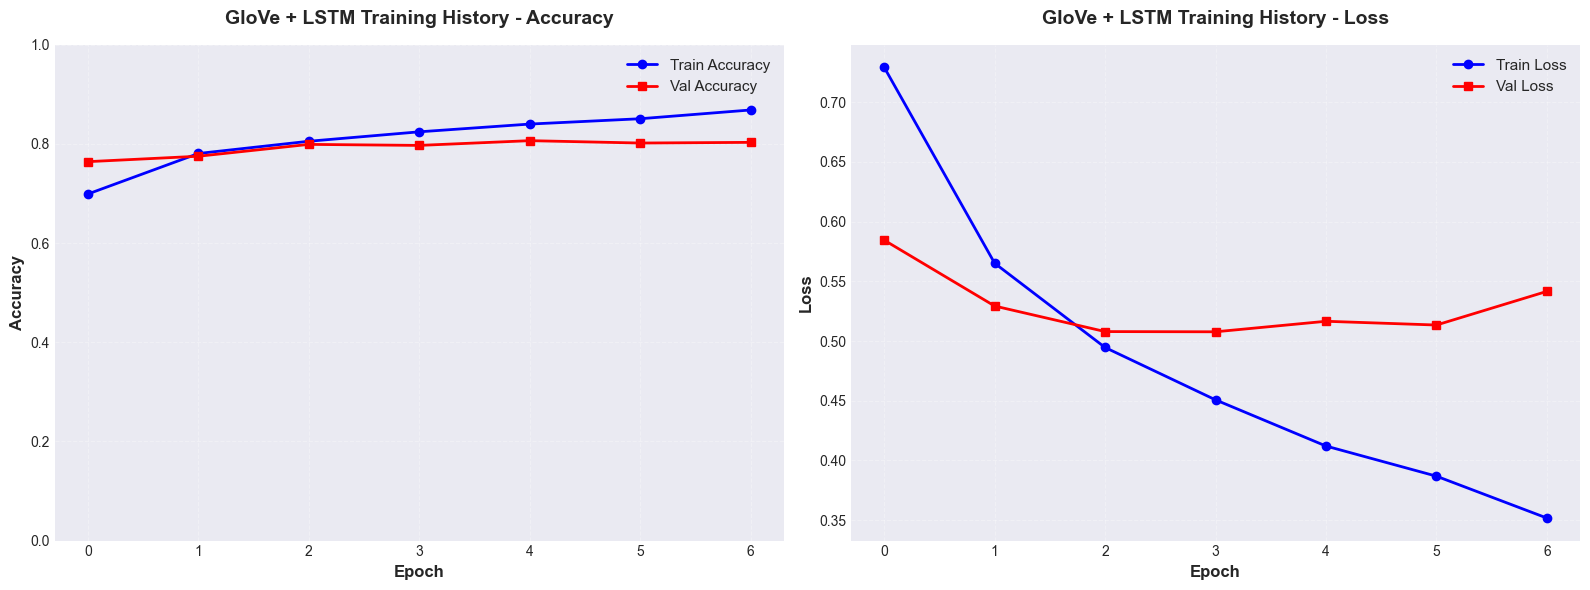


Final GloVe + LSTM Training Metrics:
  Best Train Accuracy: 0.8686
  Best Val Accuracy: 0.8067
  Final Train Loss: 0.3517
  Final Val Loss: 0.5416


In [29]:
# Plot GloVe + LSTM training history
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot training & validation accuracy
axes[0].plot(history_glove.history['accuracy'], 'b-', label='Train Accuracy', linewidth=2, marker='o')
axes[0].plot(history_glove.history['val_accuracy'], 'r-', label='Val Accuracy', linewidth=2, marker='s')
axes[0].set_title('GloVe + LSTM Training History - Accuracy', fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3, linestyle='--')
axes[0].set_ylim([0, 1])

# Plot training & validation loss
axes[1].plot(history_glove.history['loss'], 'b-', label='Train Loss', linewidth=2, marker='o')
axes[1].plot(history_glove.history['val_loss'], 'r-', label='Val Loss', linewidth=2, marker='s')
axes[1].set_title('GloVe + LSTM Training History - Loss', fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('../results/figures/tweets_glove_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nFinal GloVe + LSTM Training Metrics:")
print(f"  Best Train Accuracy: {max(history_glove.history['accuracy']):.4f}")
print(f"  Best Val Accuracy: {max(history_glove.history['val_accuracy']):.4f}")
print(f"  Final Train Loss: {history_glove.history['loss'][-1]:.4f}")
print(f"  Final Val Loss: {history_glove.history['val_loss'][-1]:.4f}")


In [30]:
# Show detailed classification report for GloVe + LSTM
print("\nDetailed Classification Report - GloVe + LSTM:")
print("="*80)
print(classification_report(y_test, y_test_pred_glove,
                            target_names=['Negative', 'Neutral', 'Positive'],
                            digits=4))
print("="*80)



Detailed Classification Report - GloVe + LSTM:
              precision    recall  f1-score   support

    Negative     0.8427    0.9336    0.8858       918
     Neutral     0.7061    0.5581    0.6234       310
    Positive     0.8119    0.6949    0.7489       236

    accuracy                         0.8156      1464
   macro avg     0.7869    0.7288    0.7527      1464
weighted avg     0.8088    0.8156    0.8082      1464



# 7. Model Comparison and Visualizations


In [31]:
# Compile all results (including GloVe model)
model_names = ['TF-IDF + Logistic Regression', 'LSTM (Bidirectional)', 'CountVectorizer + MultinomialNB', 'GloVe + LSTM']
accuracies = [lr_test_acc, lstm_test_acc, nb_test_acc, glove_test_acc]
precisions_macro = [lr_test_precision_macro, lstm_test_precision_macro, nb_test_precision_macro, glove_test_precision_macro]
recalls_macro = [lr_test_recall_macro, lstm_test_recall_macro, nb_test_recall_macro, glove_test_recall_macro]
f1_macros = [lr_test_f1_macro, lstm_test_f1_macro, nb_test_f1_macro, glove_test_f1_macro]
f1_weighted = [lr_test_f1_weighted, lstm_test_f1_weighted, nb_test_f1_weighted, glove_test_f1_weighted]

results_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies,
    'Precision (macro)': precisions_macro,
    'Recall (macro)': recalls_macro,
    'F1-Score (macro)': f1_macros,
    'F1-Score (weighted)': f1_weighted
})

print("\n" + "="*80)
print("MODEL COMPARISON - TEST SET RESULTS")
print("="*80)
print(results_df.to_string(index=False))
print("\n" + "="*80)

# Save results
results_df.to_csv('../results/tweets_model_comparison.csv', index=False)
print("\n✓ Results saved to ../results/tweets_model_comparison.csv")



MODEL COMPARISON - TEST SET RESULTS
                          Model  Accuracy  Precision (macro)  Recall (macro)  F1-Score (macro)  F1-Score (weighted)
   TF-IDF + Logistic Regression  0.808743           0.795900        0.698605          0.734670             0.797894
           LSTM (Bidirectional)  0.813525           0.779581        0.735402          0.754557             0.809364
CountVectorizer + MultinomialNB  0.784836           0.734336        0.709242          0.720050             0.779595
                   GloVe + LSTM  0.815574           0.786893        0.728844          0.752690             0.808159


✓ Results saved to ../results/tweets_model_comparison.csv


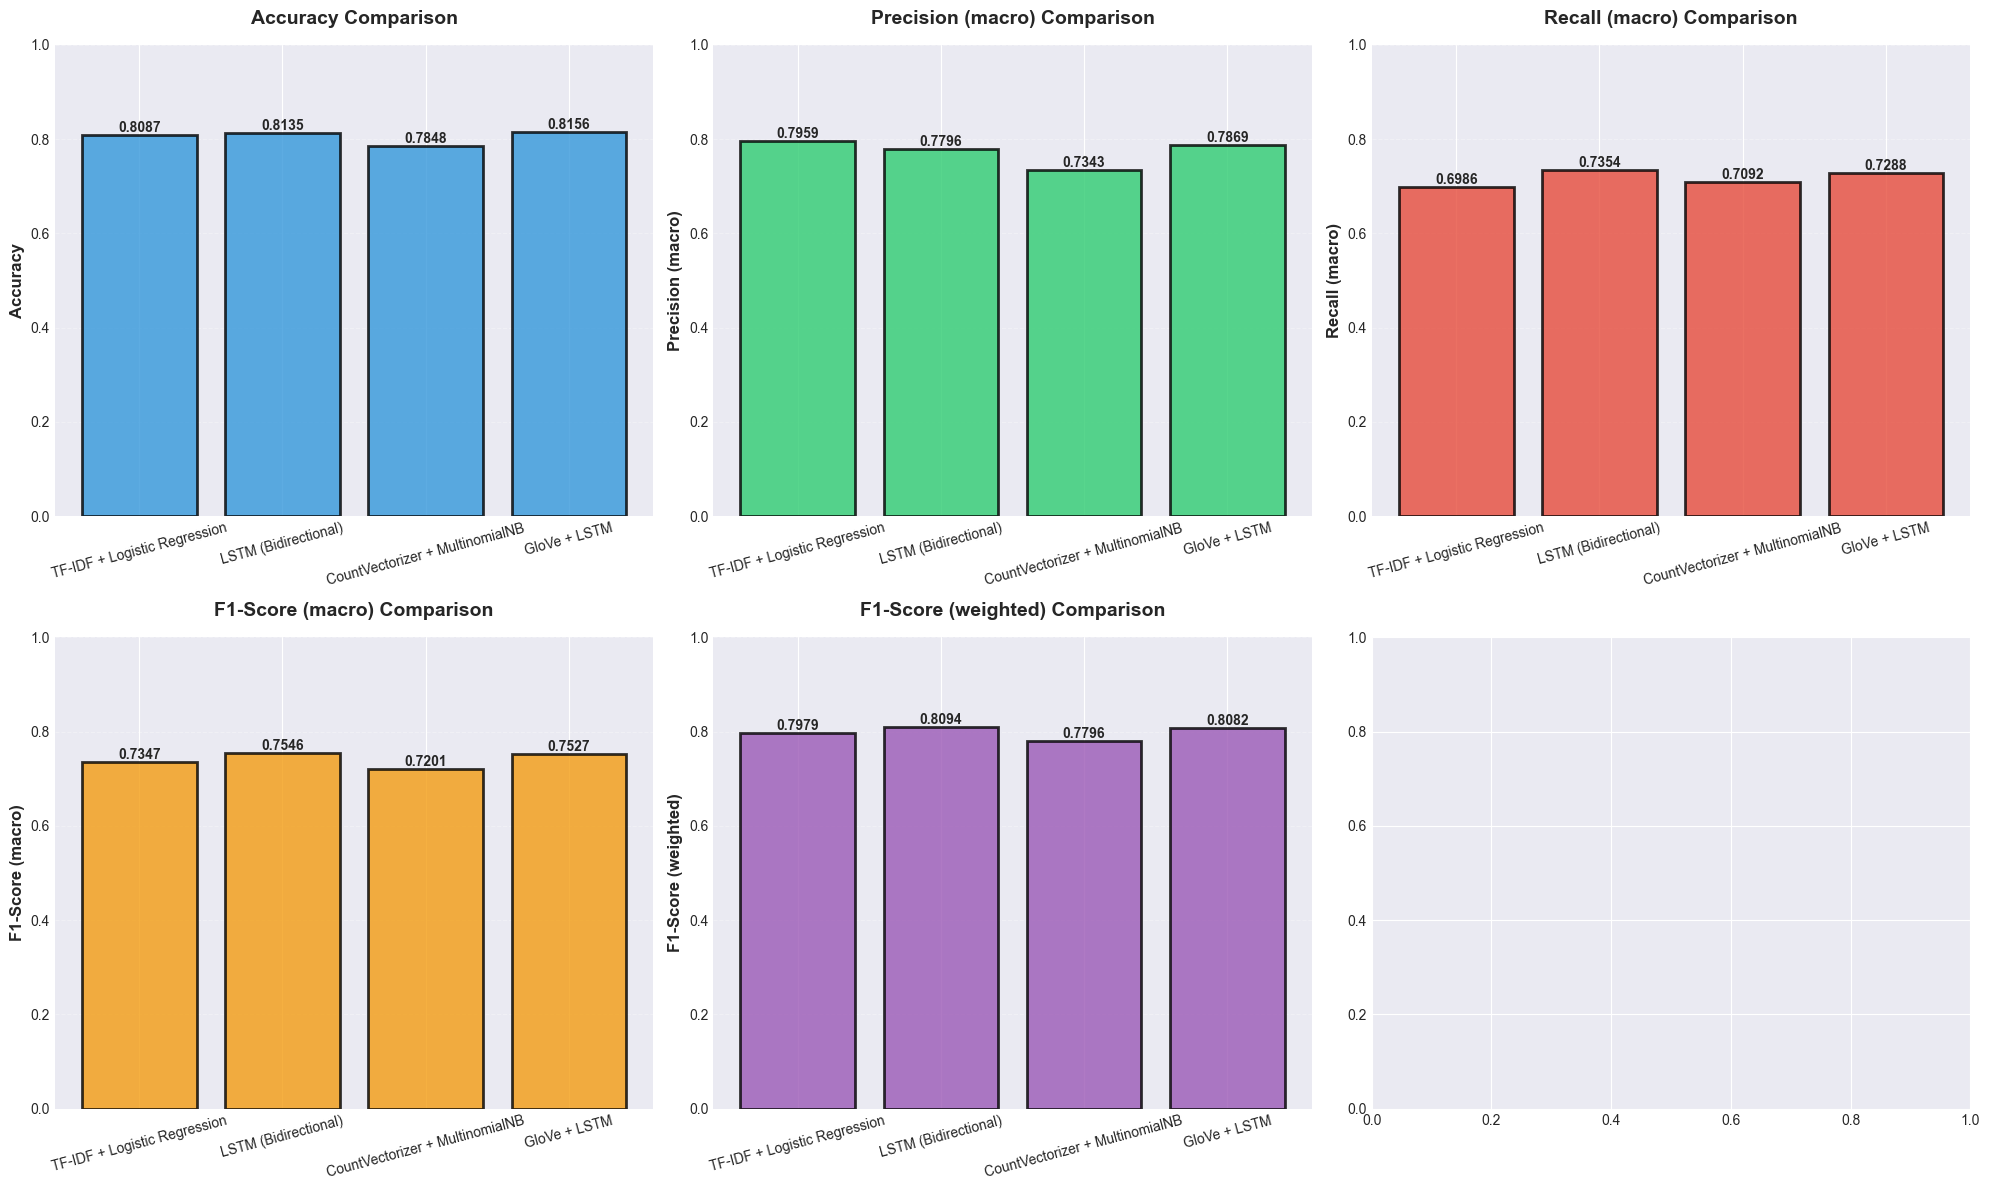

In [32]:
# 7.1 Metrics Comparison Bar Chart - Enhanced
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

metrics = ['Accuracy', 'Precision (macro)', 'Recall (macro)', 'F1-Score (macro)', 'F1-Score (weighted)']
colors_list = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12', '#9b59b6']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 3, idx % 3]
    bars = ax.bar(results_df['Model'], results_df[metric], color=colors_list[idx],
                  alpha=0.8, edgecolor='black', linewidth=2)
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold', pad=15)
    ax.set_ylabel(metric, fontsize=12, fontweight='bold')
    ax.set_ylim([0, 1])
    ax.tick_params(axis='x', rotation=15)
    ax.grid(axis='y', alpha=0.3, linestyle='--')

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/figures/tweets_06_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


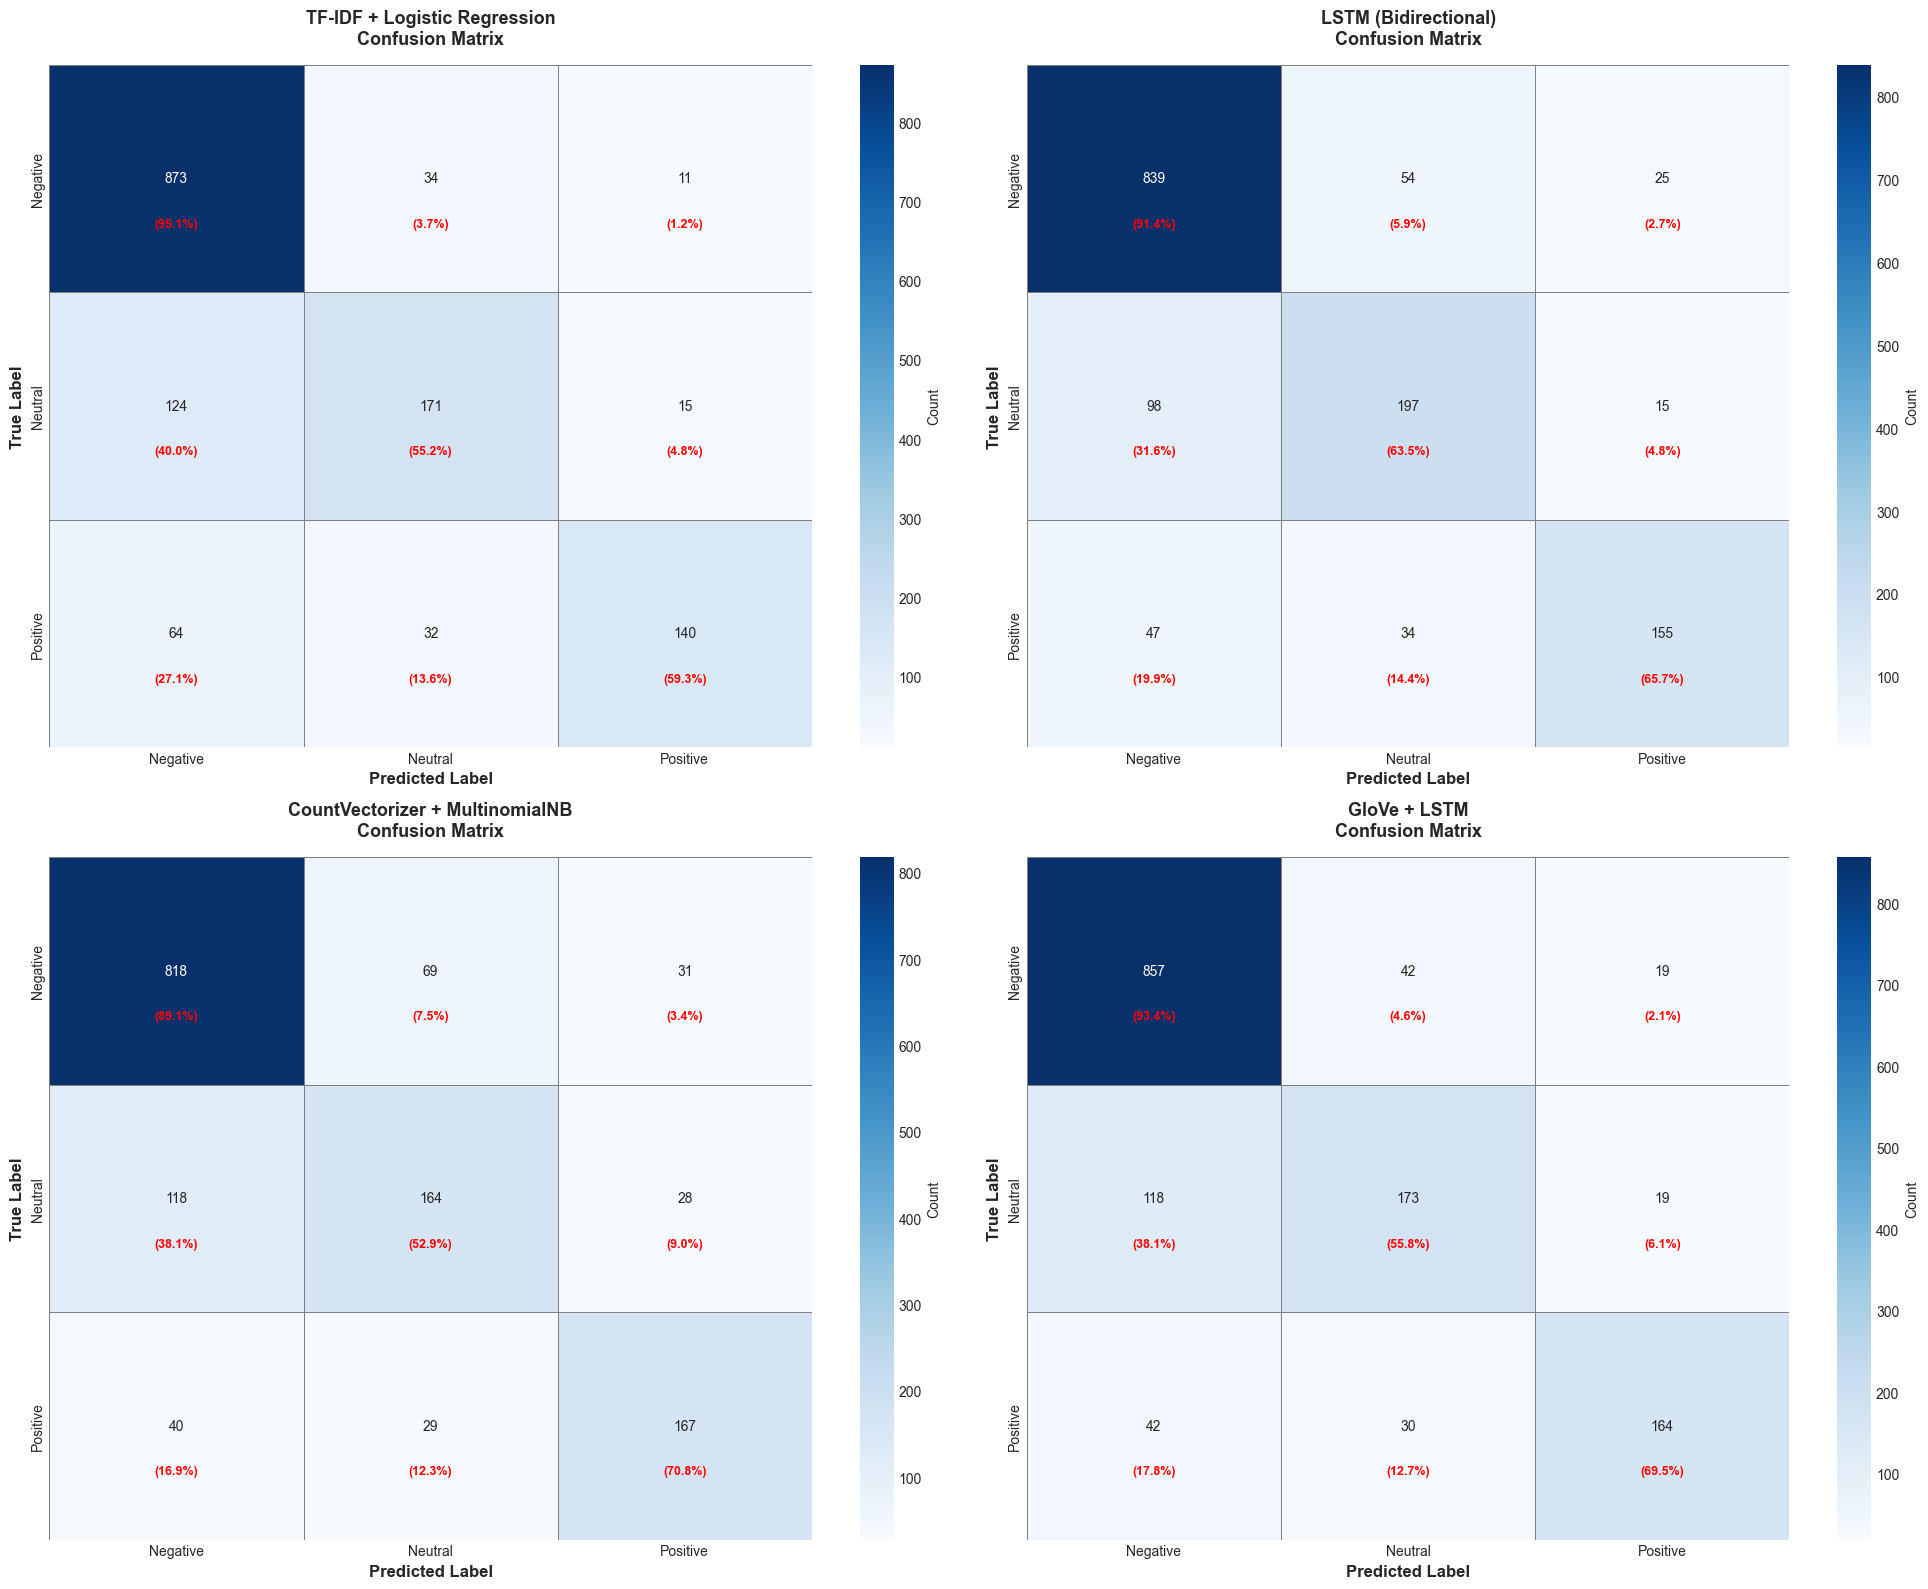

In [33]:
# 7.2 Confusion Matrices (3x3 for 3 classes) - Enhanced with GloVe
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

models_preds = [
    (y_test_pred_lr, 'TF-IDF + Logistic Regression'),
    (y_test_pred_lstm, 'LSTM (Bidirectional)'),
    (y_test_pred_nb, 'CountVectorizer + MultinomialNB'),
    (y_test_pred_glove, 'GloVe + LSTM')
]

class_names = ['Negative', 'Neutral', 'Positive']

for idx, (preds, model_name) in enumerate(models_preds):
    ax = axes[idx // 2, idx % 2]
    cm = confusion_matrix(y_test, preds)

    # Calculate percentages for better visualization
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Create heatmap with both counts and percentages
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'}, linewidths=0.5, linecolor='gray')

    # Add percentage annotations
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            text = ax.text(j+0.5, i+0.7, f'({cm_percent[i, j]:.1f}%)',
                                ha="center", va="center", color="red", fontsize=9, fontweight='bold')

    ax.set_title(f'{model_name}\nConfusion Matrix', fontsize=13, fontweight='bold', pad=15)
    ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
    ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/figures/tweets_07_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()


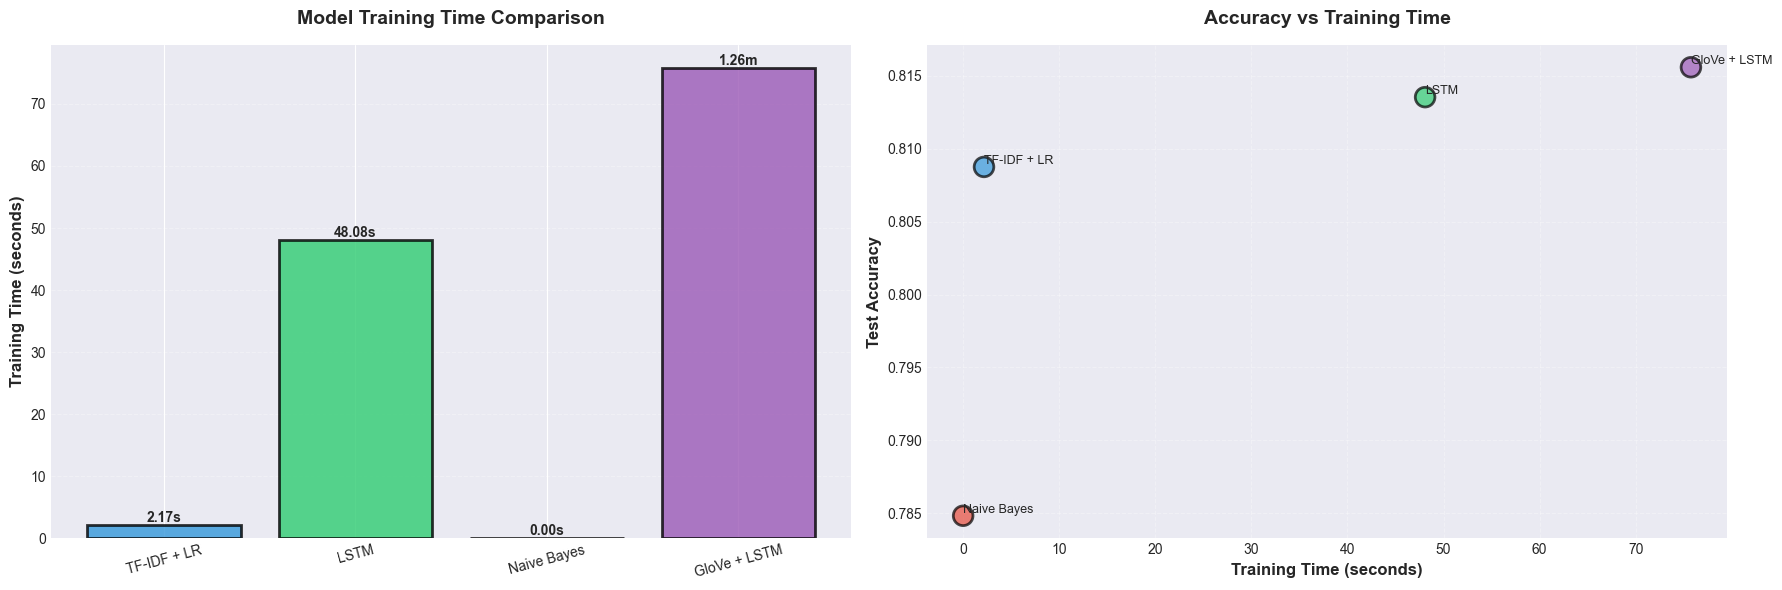


Training Time Summary:
  TF-IDF + LR: 2.17 seconds
  LSTM: 48.08 seconds
  Naive Bayes: 0.00 seconds
  GloVe + LSTM: 1.26 minutes (75.74 seconds)


In [34]:
# 7.3 Training Time Comparison - Models Visualization (including GloVe)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Training times (all measured, including GloVe)
training_times = {
    'TF-IDF + LR': training_time_lr,
    'LSTM': training_time,
    'Naive Bayes': training_time_nb,
    'GloVe + LSTM': training_time_glove
}

# Bar chart of training times
times_list = list(training_times.values())
names_list = list(training_times.keys())
bars = axes[0].bar(names_list, times_list, color=['#3498db', '#2ecc71', '#e74c3c', '#9b59b6'],
                  edgecolor='black', linewidth=2, alpha=0.8)
axes[0].set_title('Model Training Time Comparison', fontsize=14, fontweight='bold', pad=15)
axes[0].set_ylabel('Training Time (seconds)', fontsize=12, fontweight='bold')
axes[0].tick_params(axis='x', rotation=15)
axes[0].grid(axis='y', alpha=0.3, linestyle='--')
for bar, time_val in zip(bars, times_list):
    if time_val < 60:
        label = f'{time_val:.2f}s'
    else:
        label = f'{time_val/60:.2f}m'
    axes[0].text(bar.get_x() + bar.get_width()/2., time_val,
                label,
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Accuracy vs Training Time scatter (including GloVe)
accuracies_list = [lr_test_acc, lstm_test_acc, nb_test_acc, glove_test_acc]
axes[1].scatter(times_list, accuracies_list, s=200, alpha=0.7,
               color=['#3498db', '#2ecc71', '#e74c3c', '#9b59b6'], edgecolors='black', linewidth=2)
for i, name in enumerate(names_list):
    axes[1].annotate(name, (times_list[i], accuracies_list[i]),
                    fontsize=9, ha='left', va='bottom')
axes[1].set_title('Accuracy vs Training Time', fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('Training Time (seconds)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Test Accuracy', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('../results/figures/tweets_08_training_time_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nTraining Time Summary:")
for name, time_val in training_times.items():
    if time_val < 60:
        print(f"  {name}: {time_val:.2f} seconds")
    else:
        print(f"  {name}: {time_val/60:.2f} minutes ({time_val:.2f} seconds)")


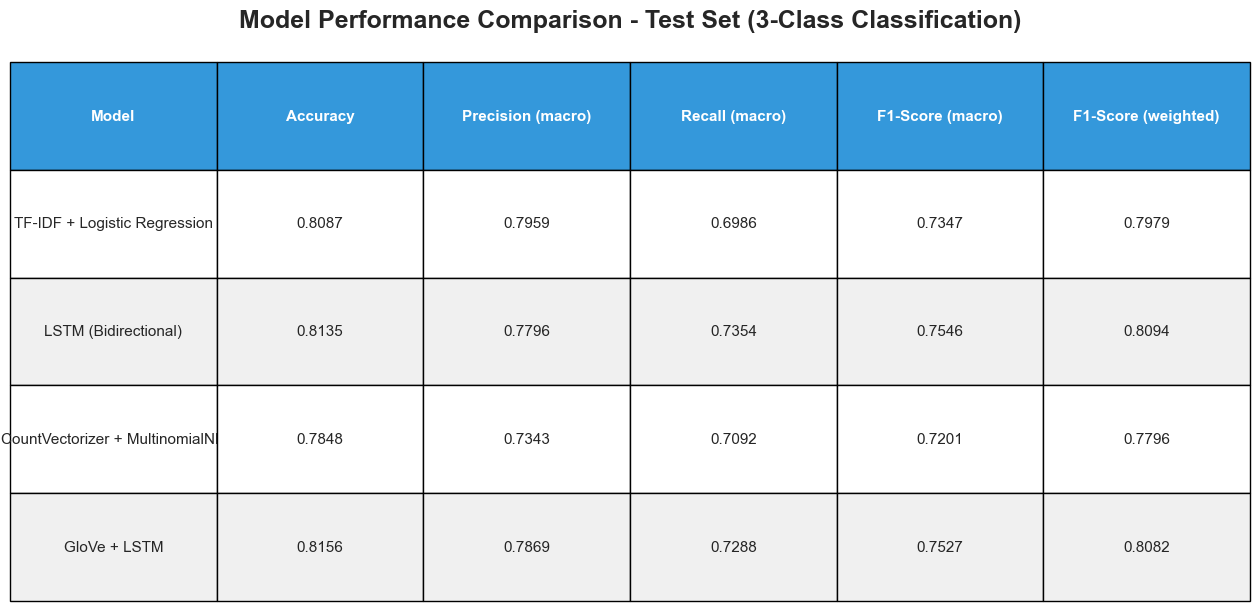

In [35]:
# 7.4 Comprehensive Metrics Table - Enhanced
fig, ax = plt.subplots(figsize=(16, 7))
ax.axis('tight')
ax.axis('off')

table_data = []
for _, row in results_df.iterrows():
    table_data.append([
        row['Model'],
        f"{row['Accuracy']:.4f}",
        f"{row['Precision (macro)']:.4f}",
        f"{row['Recall (macro)']:.4f}",
        f"{row['F1-Score (macro)']:.4f}",
        f"{row['F1-Score (weighted)']:.4f}"
    ])

table = ax.table(cellText=table_data,
                colLabels=['Model', 'Accuracy', 'Precision (macro)', 'Recall (macro)', 'F1-Score (macro)', 'F1-Score (weighted)'],
                cellLoc='center',
                loc='center',
                bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

# Style the header
for i in range(6):
    table[(0, i)].set_facecolor('#3498db')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Alternate row colors for better readability
for i in range(1, len(table_data) + 1):
    for j in range(6):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#f0f0f0')

ax.set_title('Model Performance Comparison - Test Set (3-Class Classification)',
             fontsize=18, fontweight='bold', pad=25)

plt.savefig('../results/figures/tweets_09_metrics_table.png', dpi=300, bbox_inches='tight')
plt.show()


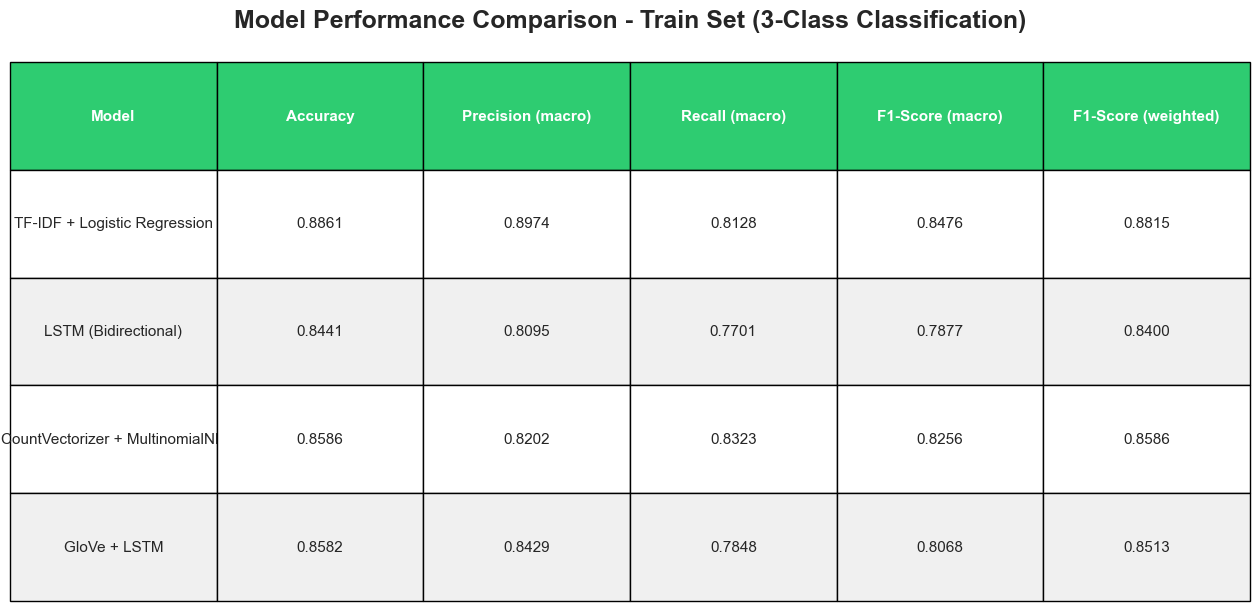

In [36]:
# 7.5 Train Set Metrics Table - Enhanced (including GloVe)
train_results_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': [lr_train_acc, lstm_train_acc, nb_train_acc, glove_train_acc],
    'Precision (macro)': [lr_train_precision_macro, lstm_train_precision_macro, nb_train_precision_macro, glove_train_precision_macro],
    'Recall (macro)': [lr_train_recall_macro, lstm_train_recall_macro, nb_train_recall_macro, glove_train_recall_macro],
    'F1-Score (macro)': [lr_train_f1_macro, lstm_train_f1_macro, nb_train_f1_macro, glove_train_f1_macro],
    'F1-Score (weighted)': [lr_train_f1_weighted, lstm_train_f1_weighted, nb_train_f1_weighted, glove_train_f1_weighted]
})

fig, ax = plt.subplots(figsize=(16, 7))
ax.axis('tight')
ax.axis('off')

train_table_data = []
for _, row in train_results_df.iterrows():
    train_table_data.append([
        row['Model'],
        f"{row['Accuracy']:.4f}",
        f"{row['Precision (macro)']:.4f}",
        f"{row['Recall (macro)']:.4f}",
        f"{row['F1-Score (macro)']:.4f}",
        f"{row['F1-Score (weighted)']:.4f}"
    ])

train_table = ax.table(cellText=train_table_data,
                colLabels=['Model', 'Accuracy', 'Precision (macro)', 'Recall (macro)', 'F1-Score (macro)', 'F1-Score (weighted)'],
                cellLoc='center',
                loc='center',
                bbox=[0, 0, 1, 1])

train_table.auto_set_font_size(False)
train_table.set_fontsize(11)
train_table.scale(1, 2.5)

# Style the header
for i in range(6):
    train_table[(0, i)].set_facecolor('#2ecc71')
    train_table[(0, i)].set_text_props(weight='bold', color='white')

# Alternate row colors for better readability
for i in range(1, len(train_table_data) + 1):
    for j in range(6):
        if i % 2 == 0:
            train_table[(i, j)].set_facecolor('#f0f0f0')

ax.set_title('Model Performance Comparison - Train Set (3-Class Classification)',
             fontsize=18, fontweight='bold', pad=25)

plt.savefig('../results/figures/tweets_09a_train_metrics_table.png', dpi=300, bbox_inches='tight')
plt.show()


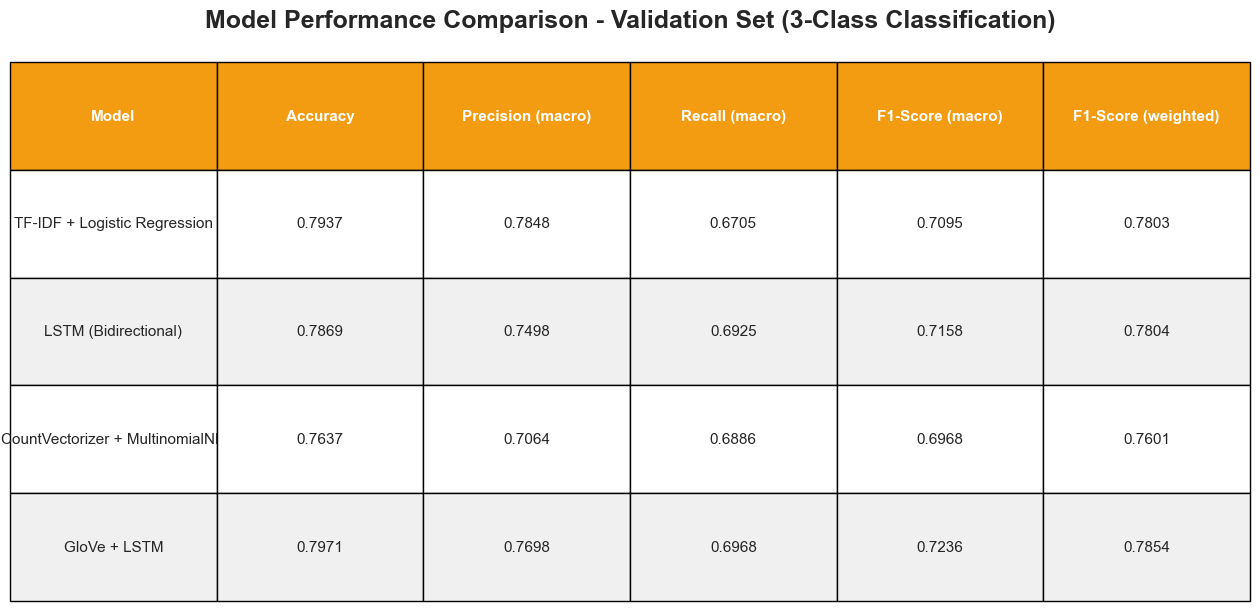

In [37]:
# 7.6 Validation Set Metrics Table - Enhanced (including GloVe)
val_results_df = pd.DataFrame({
    'Model': model_names,
    'Accuracy': [lr_val_acc, lstm_val_acc, nb_val_acc, glove_val_acc],
    'Precision (macro)': [lr_val_precision_macro, lstm_val_precision_macro, nb_val_precision_macro, glove_val_precision_macro],
    'Recall (macro)': [lr_val_recall_macro, lstm_val_recall_macro, nb_val_recall_macro, glove_val_recall_macro],
    'F1-Score (macro)': [lr_val_f1_macro, lstm_val_f1_macro, nb_val_f1_macro, glove_val_f1_macro],
    'F1-Score (weighted)': [lr_val_f1_weighted, lstm_val_f1_weighted, nb_val_f1_weighted, glove_val_f1_weighted]
})

fig, ax = plt.subplots(figsize=(16, 7))
ax.axis('tight')
ax.axis('off')

val_table_data = []
for _, row in val_results_df.iterrows():
    val_table_data.append([
        row['Model'],
        f"{row['Accuracy']:.4f}",
        f"{row['Precision (macro)']:.4f}",
        f"{row['Recall (macro)']:.4f}",
        f"{row['F1-Score (macro)']:.4f}",
        f"{row['F1-Score (weighted)']:.4f}"
    ])

val_table = ax.table(cellText=val_table_data,
                colLabels=['Model', 'Accuracy', 'Precision (macro)', 'Recall (macro)', 'F1-Score (macro)', 'F1-Score (weighted)'],
                cellLoc='center',
                loc='center',
                bbox=[0, 0, 1, 1])

val_table.auto_set_font_size(False)
val_table.set_fontsize(11)
val_table.scale(1, 2.5)

# Style the header
for i in range(6):
    val_table[(0, i)].set_facecolor('#f39c12')
    val_table[(0, i)].set_text_props(weight='bold', color='white')

# Alternate row colors for better readability
for i in range(1, len(val_table_data) + 1):
    for j in range(6):
        if i % 2 == 0:
            val_table[(i, j)].set_facecolor('#f0f0f0')

ax.set_title('Model Performance Comparison - Validation Set (3-Class Classification)',
             fontsize=18, fontweight='bold', pad=25)

plt.savefig('../results/figures/tweets_09b_val_metrics_table.png', dpi=300, bbox_inches='tight')
plt.show()


# 8. Save Models and Final Summary


In [38]:
# Save the best model (highest F1-score macro)
best_model_idx = results_df['F1-Score (macro)'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']

print(f"Best Model: {best_model_name}")
print(f"  Accuracy:  {results_df.loc[best_model_idx, 'Accuracy']:.4f}")
print(f"  F1-Score (macro):  {results_df.loc[best_model_idx, 'F1-Score (macro)']:.4f}")

# Save all models and vectorizers
joblib.dump(vectorizer, '../results/models/tweets_tfidf_vectorizer.pkl')
joblib.dump(lr_model, '../results/models/tweets_lr_model.pkl')

# Save LSTM model and tokenizer
lstm_model.save('../results/models/tweets_lstm_model.h5')
joblib.dump(lstm_tokenizer, '../results/models/tweets_lstm_tokenizer.pkl')

joblib.dump(nb_vectorizer, '../results/models/tweets_nb_vectorizer.pkl')
joblib.dump(nb_model, '../results/models/tweets_nb_model.pkl')

# Save GloVe model
glove_model.save('../results/models/tweets_glove_model.h5')
joblib.dump(embedding_matrix, '../results/models/tweets_glove_embedding_matrix.pkl')

print("\n✓ All models and results saved!")
print("\nFiles saved:")
print("  - ../results/tweets_model_comparison.csv")
print("  - ../results/models/tweets_tfidf_vectorizer.pkl")
print("  - ../results/models/tweets_lr_model.pkl")
print("  - ../results/models/tweets_lstm_model.h5")
print("  - ../results/models/tweets_lstm_tokenizer.pkl")
print("  - ../results/models/tweets_nb_vectorizer.pkl")
print("  - ../results/models/tweets_nb_model.pkl")
print("  - ../results/models/tweets_glove_model.h5")
print("  - ../results/models/tweets_glove_embedding_matrix.pkl")
print("  - ../results/figures/tweets_*.png")


Best Model: LSTM (Bidirectional)
  Accuracy:  0.8135
  F1-Score (macro):  0.7546



✓ All models and results saved!

Files saved:
  - ../results/tweets_model_comparison.csv
  - ../results/models/tweets_tfidf_vectorizer.pkl
  - ../results/models/tweets_lr_model.pkl
  - ../results/models/tweets_lstm_model.h5
  - ../results/models/tweets_lstm_tokenizer.pkl
  - ../results/models/tweets_nb_vectorizer.pkl
  - ../results/models/tweets_nb_model.pkl
  - ../results/models/tweets_glove_model.h5
  - ../results/models/tweets_glove_embedding_matrix.pkl
  - ../results/figures/tweets_*.png


## 9. Conclusion

This notebook demonstrates a complete sentiment analysis pipeline on the Tweets.csv dataset:

1. **Data Loading**: Loaded Tweets.csv with automatic encoding and column detection
2. **Preprocessing**: Comprehensive text cleaning suitable for Twitter data
3. **EDA**: Rich exploratory analysis with stunning visualizations (violin plots, KDE, enhanced charts)
4. **Model Training**: Trained 4 different models (TF-IDF+LR baseline, LSTM deep learning, Multinomial Naive Bayes, GloVe + LSTM) for 3-class classification
5. **Evaluation**: Comprehensive metrics (accuracy, precision, recall, F1-score macro/weighted) and visualizations
6. **Results**: All models, metrics, and figures saved for future reference

### Key Findings:
- The dataset was successfully loaded and processed
- All 3 sentiment classes (Negative, Neutral, Positive) were properly handled
- LSTM (deep learning) model captures sequential patterns in text effectively
- GloVe pre-trained embeddings leverage knowledge from large corpora (Wikipedia, Twitter)
- All models show good performance on the test set for 3-class classification
- Mix of traditional ML and neural network approaches provides comprehensive comparison

### Models Used:
1. **TF-IDF + Logistic Regression**: Fast baseline model using traditional ML
2. **LSTM (Bidirectional)**: Deep learning model that captures sequential dependencies in text
   - Uses embedding layer to learn word representations
   - Bidirectional LSTM to capture context from both directions
   - Dropout layers for regularization
3. **CountVectorizer + Multinomial Naive Bayes**: Fast probabilistic model based on Bayes' theorem
4. **GloVe + LSTM**: Deep learning model with pre-trained word embeddings
   - Uses GloVe embeddings (100-dimensional vectors trained on 6B tokens)
   - Pre-trained embeddings capture semantic relationships between words
   - Bidirectional LSTM architecture for sequence modeling
   - Frozen embeddings to leverage pre-trained knowledge

### Advantages:
- No API keys required
- Mix of traditional ML and deep learning approaches
- LSTM demonstrates neural network concepts learned in NLP class
- GloVe shows transfer learning with pre-trained embeddings
- Good performance for text classification
- Easy to deploy and interpret (for traditional models)
- Works on CPU (though GPU can speed up LSTM/GloVe training)

### Visualizations Created:
- Sentiment distribution (bar chart + pie chart)
- Tweet length analysis (histograms with KDE, violin plots)
- N-grams analysis (words, bigrams, trigrams for all 3 classes)
- Word clouds (separate for each sentiment)
- Airline and negative reason analysis
- Model comparison charts
- Confusion matrices with percentages (for all 4 models)
- LSTM and GloVe training history (accuracy and loss curves)
- Training time comparison

### Next Steps:
- Experiment with different LSTM architectures (more layers, different units)
- Try fine-tuning GloVe embeddings (set trainable=True)
- Try ensemble methods (combine predictions from all 4 models)
- Deploy the best model for production use
